In [1]:
from readfiles import *
import sys
import numpy.linalg as LA
import copy
from unit import *
from qutip import *
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit

# Writing main Hamiltonian

In [2]:
# Now defining Units and conversion factors. 
h = 6.62607015e-34 # planck's constant in joules second
c = 2.99792458e10 # speed of light in cm per second
e = 1.60217663e-19 # charge of electron in coulombs
hbar = 0.658211951 # in eV-fs or meV-ps or ueV-ns
cm2ev = c*h/e  # conversion factor from 1/cm to eV
cm2mev = cm2ev * 1.e3  # conversion from 1/cm to meV
ev2au = e/4.3597447222071e-18  # converison from eV to atomic mass units
cm2au = cm2ev * ev2au  # conversion from 1/cm to atomic mass units

kB = 8.617333262e-2 # meV/K, Boltzmann constant

In [3]:
free_e_gyro = 28024.9514242E6 # Hz/T gyromagnetic ratio of an electron.
hz2meV = 4.1357E-12 # 1Hz = 4.1357E-15 eV = 4.1357E-12 meV
free_e_gfactor = 2.00231930437378 # free electron g factor 2.00231930437378
alpha = (free_e_gyro*hz2meV)/free_e_gfactor # gyromagnetic ratio/gfactor in meV per tesla
print("alpha in units of meV per tesla = "+str(alpha))
print("hbar is contained in the definition of alpha")

alpha in units of meV per tesla = 0.057884270182028845
hbar is contained in the definition of alpha


In [4]:
eS = jmat(1/2)
eS

(Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
 Qobj data =
 [[0.  0.5]
  [0.5 0. ]],
 Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
 Qobj data =
 [[0.+0.j  0.-0.5j]
  [0.+0.5j 0.+0.j ]],
 Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
 Qobj data =
 [[ 0.5  0. ]
  [ 0.  -0.5]])

In [5]:
sigma_vec = [sigmax(), sigmay(), sigmaz()]
sigma_vec

[Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
 Qobj data =
 [[0. 1.]
  [1. 0.]],
 Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
 Qobj data =
 [[0.+0.j 0.-1.j]
  [0.+1.j 0.+0.j]],
 Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
 Qobj data =
 [[ 1.  0.]
  [ 0. -1.]]]

In [6]:

# NOTE: using the pauli vector instead of spin half operators. Defining a single spin half operators
#eS = jmat(1/2) # list of electronic spin operators [Sx, Sy, Sz] 
# NOTE: In qutip, the eigensolver transforms the Matrix with eigen values in ascending order.

# Loading the gtensor for the basic Hamiltonian.
fname = 'data files/gtensor.dat' # loading the gtensor, hyperfine tensor, and ztensor. 
gtensor, hfc, zfs = read_g(fname)

# Defining External magnetic field vector
Bfield = 1 # Tesla
print("applied magnetic field is ", Bfield, " Tesla")

Bvector = np.zeros(3)
Bvector[0] = 0
Bvector[1] = 0
Bvector[2] = Bfield


# Defining spin Hamiltonian
H = None

# 1) Zeeman interaction
for i in range(3):
    for j in range(3):
        if H is None:
            H = alpha * gtensor[i][j] *(1/2)* sigma_vec[i] * Bvector[j] # notice this 1/2 here. its because i am using pauli matrices 
        else:
            H += alpha * gtensor[i][j] *(1/2)* sigma_vec[i] * Bvector[j]# instead of spin 1/2 matrices 

print('Spin zeeman hamiltonian')
#H.tidyup()
H

applied magnetic field is  1  Tesla
Spin zeeman hamiltonian


Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[ 5.76003884e-02+0.00000000e+00j  6.38260905e-05+2.56166838e-05j]
 [ 6.38260905e-05-2.56166838e-05j -5.76003884e-02+0.00000000e+00j]]

In [7]:
energies, estates  = (-H).eigenstates() # the eigenstates are in acending order, the -ve reintroduces the decending order
energies, estates

(array([-0.05760043,  0.05760043]),
 array([Quantum object: dims = [[2], [1]], shape = (2, 1), type = ket
        Qobj data =
        [[-9.99999822e-01+0.j        ]
         [-5.54041893e-04+0.00022237j]]                              ,
        Quantum object: dims = [[2], [1]], shape = (2, 1), type = ket
        Qobj data =
        [[ 5.96999835e-04+0.j        ]
         [-9.28043463e-01+0.37247144j]]                              ],
       dtype=object))

In [8]:
H = H.transform(estates)
H

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[ 0.05760043  0.        ]
 [ 0.         -0.05760043]]

### At this point we should tranform the coupings to new eigen basis as well. but since the new basis are very close to the prevous one, I think we can ommitt this step with negligible error

# Loading and visualizing frequencies and gtensor derivative i.e. dgx

In [9]:
# Loading the couplings and frequencies
freq, dgx = get_phonon('data files/spin_phonon.dat')
freq = freq*cm2mev
print("the intra vibrations of a single molecule are the harmonic frequencies here in meV")

number of vibs= 190
the intra vibrations of a single molecule are the harmonic frequencies here in meV


In [10]:
dgx[0]

array([[-2.4308993e-03, -3.6944117e-03,  1.8978486e-03],
       [-2.8236532e-03,  1.5009815e-03,  8.7550132e-05],
       [ 1.0964913e-03,  5.0411135e-04,  3.4037204e-04]])

In [11]:
freq/cm2mev

array([  12.8 ,   26.32,   42.4 ,   43.09,   43.64,   68.84,   76.09,
         76.65,   76.92,   82.92,   83.56,  103.44,  134.89,  143.88,
        145.41,  146.6 ,  147.71,  156.8 ,  178.5 ,  181.71,  202.14,
        215.87,  226.73,  240.07,  241.75,  243.96,  245.31,  245.7 ,
        252.06,  271.68,  287.44,  289.37,  296.58,  305.96,  306.44,
        320.06,  321.25,  342.52,  342.85,  349.94,  352.65,  359.74,
        375.24,  375.42,  377.48,  389.13,  396.28,  396.85,  397.32,
        405.39,  431.7 ,  433.13,  435.32,  441.36,  468.06,  500.09,
        500.15,  501.68,  508.62,  540.97,  541.38,  541.82,  549.79,
        551.57,  560.67,  561.72,  568.15,  571.83,  597.24,  605.11,
        605.69,  620.32,  647.11,  667.29,  671.07,  676.64,  682.97,
        689.03,  700.24,  715.45,  715.95,  725.25,  732.82,  734.06,
        737.55,  741.2 ,  742.53,  748.2 ,  752.43,  757.7 ,  760.2 ,
        764.18,  767.13,  769.  ,  809.2 ,  812.8 ,  820.72,  824.97,
        837.39,  844

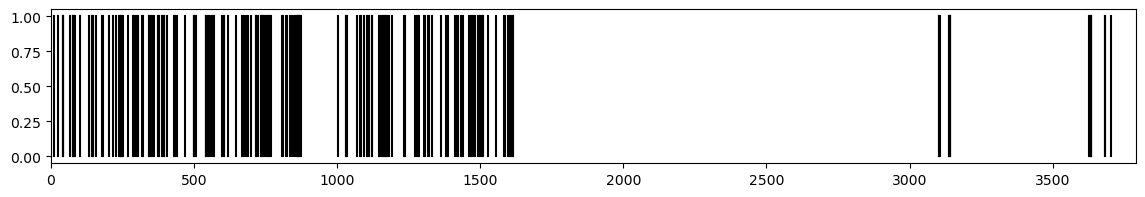

In [12]:
plt.figure(figsize=(14, 2))
plt.xlim([0, 3790])
for i in range(len(freq)):
    plt.plot([freq[i]/cm2mev,freq[i]/cm2mev], [0,1], 'k')
plt.show()

In [13]:
test = np.array([[1,2,3], [4,5,6]])
np.linalg.norm(test)

9.539392014169456

In [14]:
np.sqrt(np.sum(np.array([[1,2,3], [4,5,6]])**2))

9.539392014169456

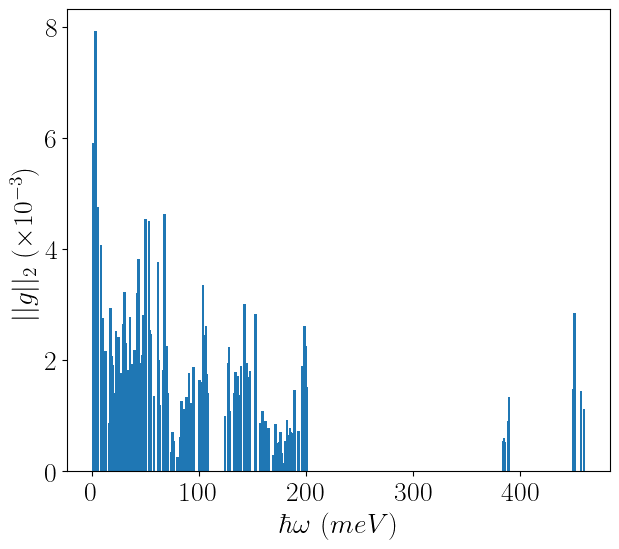

In [15]:
zeeman_l2_norm = []

for k in range(len(freq)):
    zeeman_l2_norm.append(np.linalg.norm(dgx[k,:]))

plt.rcParams['text.usetex'] = True 
plt.rcParams.update({'font.size': 20})
plt.figure(figsize=(7, 6))
plt.bar(freq, np.array(zeeman_l2_norm)*1e3, width = 2.5)
#plt.title(r"Zeeman coupling $l_2$ norm $V = \sum_{ij} |\frac{\partial g_{ij}}{\partial x}\delta x|^2$")
plt.xlabel('$\hbar \omega \ (meV)$ ')
plt.ylabel(r'$||g||_2 \ (\times 10^{-3})$')
plt.show()

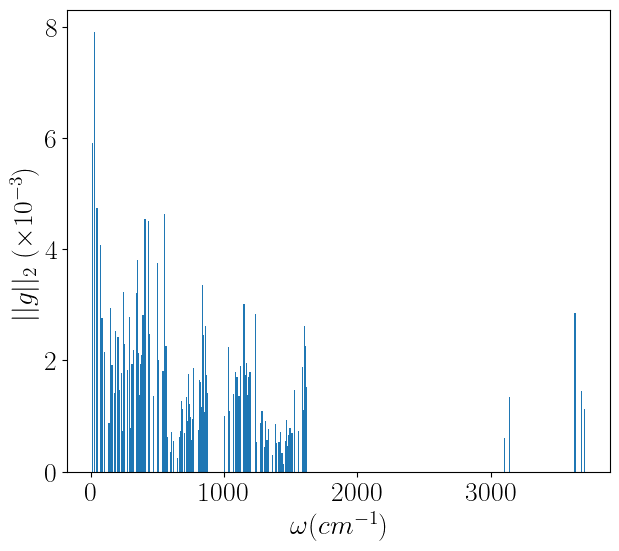

In [16]:
zeeman_l2_norm = []

for k in range(len(freq)):
    zeeman_l2_norm.append(np.linalg.norm(dgx[k,:]))

plt.rcParams['text.usetex'] = True 
plt.rcParams.update({'font.size': 20})
plt.figure(figsize=(7, 6))
plt.bar(freq/cm2mev, np.array(zeeman_l2_norm)*1e3, width = 10)
#plt.title(r"Zeeman coupling $l_2$ norm $V = \sum_{ij} |\frac{\partial g_{ij}}{\partial x}\delta x|^2$")
plt.xlabel('$ \omega (cm^{-1})$ ')
plt.ylabel(r'$||g||_2 \ (\times 10^{-3})$')
plt.show()

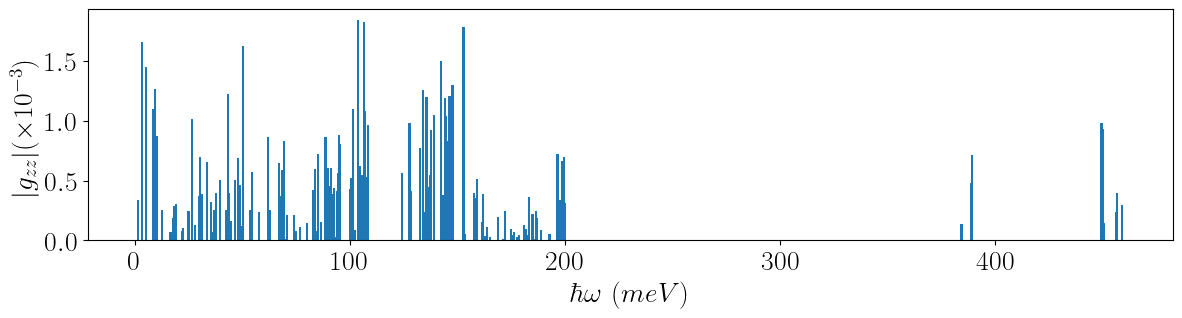

In [17]:
plt.rcParams['text.usetex'] = True 
plt.rcParams.update({'font.size': 20})
plt.figure(figsize=(14, 3))
plt.bar(freq, np.abs(np.array(dgx[:,2,2])*1e3), width = 1)
plt.xlabel('$\hbar \omega \ (meV)$ ')
plt.ylabel(r'$|g_{zz}|  (\times 10^{-3})$')
plt.show()

### Converting derivatives of gtensor into couplings $\tilde c$ with Pauli matrices

$$
gcoupS= \tilde c_{\alpha k} = \alpha \frac{\partial g_{\alpha z}}{\partial q_k} B_z (1/2)
$$

Note: this last 1/2 is comming from converting spin half opertors (S) to pauli matrices

In [18]:
Np = len(freq)
gcoupS = np.zeros((Np, 3),dtype=float) # defining a place holder for couplings
for k in range(Np):
    for j in range(3):
        gcoupS[k,:] += alpha * dgx[k,:,j] * Bvector[j] * (1/2) # only thing missing from here is Pauli matrix. Everything else is contained.
        #therefore, couplings will have units of energy as meV

# NOTE: this coupling also has the harmonic bath displacement operator contained in it. therefore, it has units of meV.
print('First 5 new couplings \n', gcoupS[:5])
print('these couplings are for the Pauli X, Y, Z operators.')

First 5 new couplings 
 [[ 5.49277906e-05  2.53388775e-06  9.85109356e-06]
 [-2.91232116e-05  8.43397839e-06 -4.81645693e-05]
 [ 6.26718348e-06 -2.99584932e-05 -2.30264090e-05]
 [-4.29811023e-06 -2.40631527e-05 -4.20601376e-05]
 [-2.17794186e-05  9.84837445e-06 -3.23478314e-05]]
these couplings are for the Pauli X, Y, Z operators.


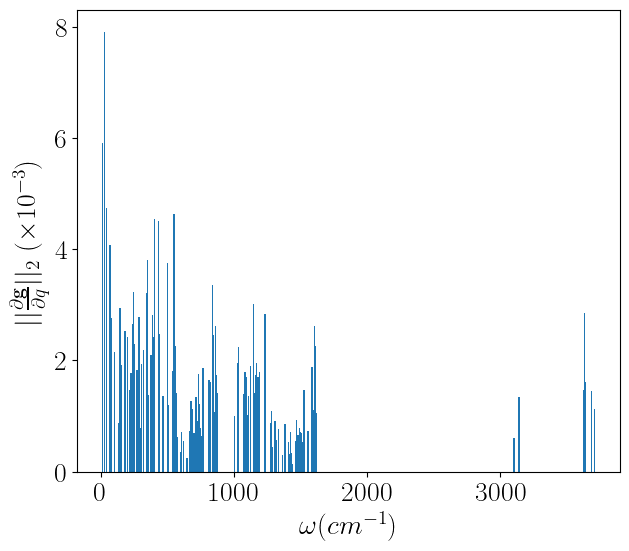

In [19]:
zeeman_l2_norm = []

for k in range(len(freq)):
    zeeman_l2_norm.append(np.linalg.norm(dgx[k,:]))

plt.rcParams['text.usetex'] = True 
plt.rcParams.update({'font.size': 20})
plt.figure(figsize=(7, 6))
plt.bar(freq/cm2mev, np.array(zeeman_l2_norm)*1e3, width = 10)
#plt.title(r"Zeeman coupling $l_2$ norm $V = \sum_{ij} |\frac{\partial g_{ij}}{\partial x}\delta x|^2$")
plt.xlabel('$ \omega (cm^{-1})$ ')
plt.ylabel(r'$||\frac{\partial \bf{g}}{\partial q}||_2 \ (\times 10^{-3})$')
plt.show()

# Understanding of the couplings.

$$
H_{int} = \sum_i A_i \otimes C_i = \sum_i \sigma_i C_i
$$

where $A_i$ are system operators i.e. $\sigma_i$ Pauli matrices, and $C_i$ are linear sum of phonon displacement operators. 
i.e. 
$$
C_i = \sum_j c^{(i)}_j u_j
$$

In the case of Zeeman Hamiltonian, the spin-phonon interaction is consequence of variation in g-tensor as a result of atomic displacements due to molecular vibrations. Therefore, 
$$
H_{int} = \sum_i \sigma_i [\frac{\alpha}{2}\sum_{jk} \frac{\partial g_{ik}}{\partial u_j} B_k u_j] = \sum_i \sigma_i (\sum_{j}c^i_j u_j) =\sum_i \sigma_i C_i
$$
where $B_k$ are elements of magnetic field vector, $g^j$ is the g-tensor, $\alpha$ contains gyromagnetic ratio and acts like a conversion factor for the entire term to energy (meV/T). Finally 
$$
c^i_j = \frac{\alpha}{2} \sum_{k} \frac{\partial g_{ik}}{\partial u_j} B_k 
$$

### NOW instead of $\frac{\partial g_{ik}}{\partial u_j}$, we have $\frac{\partial g_{ik}}{\partial u_j}\Delta u_j = dgx$

so one way forward is to assume: 
$$
c^i_j u_j = \frac{\alpha}{2} \sum_{k} \frac{\partial g_{ik}}{\partial u_j}\Delta u_j B_k \frac{u_j}{\Delta u_j} = \frac{\alpha}{2} \sum_{k} dgx B_k \frac{u_j}{\Delta u_j} = \frac{\alpha}{2} \sum_{k} dgx B_k \frac{u_j}{\Delta u_j} = gcoup \frac{u_j}{\Delta u_j}
$$

Now this means that there is this puzzle of what the value for $\Delta u_j$ happens to be; can I take it as some normalization factor?

### Defining spectral densities

In [20]:
def shape_normal(w, w0, sigma):
    '''
    this function returns a Gaussian/Normal distribution centered at w0 with std sigma
    '''
    return np.exp(-0.5*((w-w0)/sigma)**2)/(sigma*np.sqrt(2*np.pi))


def lorentzian(w, w0, sigma):
    '''
    this function returns a lorentzian profile centered at 'w0' with thickness 'sigma'
    NOTE: sigma is related to the lifetime of the mode by tau = hbar/sigma
    '''
    return  sigma/(np.pi*(sigma**2 + (w-w0)**2))

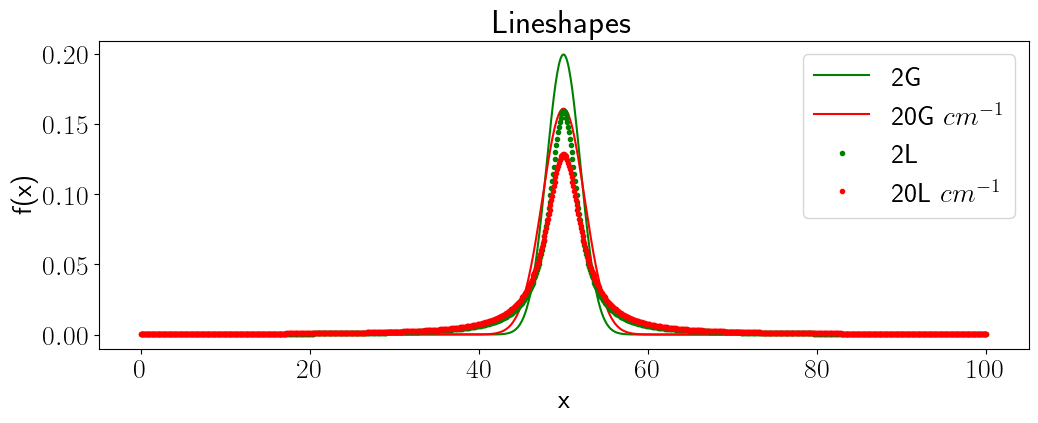

In [21]:
# lets test it out. 
x = np.linspace(0, 100, 1000)
y1 = [shape_normal(w, w0=50, sigma=1) for w in x]
y2 = [shape_normal(w, w0=50, sigma=2) for w in x]
y20cm = [shape_normal(w, w0=50, sigma=20*cm2mev) for w in x]

y1l = [lorentzian(w, w0=50, sigma=1) for w in x]
y2l = [lorentzian(w, w0=50, sigma=2) for w in x]
y20cml = [lorentzian(w, w0=50, sigma=20*cm2mev) for w in x]



plt.figure(figsize=(12,4))
#plt.plot(x,y1, 'b')
plt.plot(x,y2, 'g')
plt.plot(x,y20cm, 'r')
#plt.plot(x,y1l, 'b.-')
plt.plot(x,y2l,'g.')
plt.plot(x,y20cml,'r.')
plt.title("Lineshapes")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.legend(['2G','20G $cm^{-1}$','2L','20L $cm^{-1}$'])
plt.show()

In [22]:
def spectral_density_quantum(w, freqs, coup, T=5, sigma=2, shape='L'):
    '''
    for full formula see the cell below
    n = n_thermal = pop of harmonic oscillator mode with frequency ‘w’, at the temperature described by ‘w_th’ where 𝜔_th = 𝑘𝐵 𝑇/ℏ
    NOTE: freqs and couplings must be passed in energy units i.e. meV. 
    units of S(w) are [(meV)^2 s]

    Note: It requires cij tilde converts it into cij by division with sqrt(hbar/2wj) and then computes the spectral density
    '''
    kB = 8.6173e-2 # meV/K, Boltzmann constant
    w_th = kB*T/hbar # temperature defined as frequency
    S = 0
    for j in range(len(freqs)):
        wj = freqs[j]/hbar
        cj = coup[j]/np.sqrt(hbar/(2*wj)) # energy / length
        nj = n_thermal(wj,w_th)
        #sigma = 0.1*wj
        if shape=='G':
            S += np.pi*hbar*(cj**2/wj)*( (nj+1)*shape_normal(w, wj, sigma) + nj*shape_normal(w, -wj, sigma) )
        else:
            S += np.pi*hbar*(cj**2/wj)*( (nj+1)*lorentzian(w, wj, sigma) + nj*lorentzian(w, -wj, sigma) )
    return S

def spectral_density_classical(w, freqs, coup, T=5, sigma=2, shape='L'):
    '''
    for full formula see the cell below
    Units of S(w) are energy (meV) if freqs and couplings are in frequency units.
    '''
    kB = 8.6173e-2 # meV/K, Boltzmann constant
    S = 0
    for j in range(len(freqs)):
        wj = freqs[j]/hbar
        cj = coup[j]/np.sqrt(hbar/(2*wj)) # energy/length
        if shape=='G':
            S += np.pi*kB*T*(cj**2/wj**2)*(shape_normal(w, wj, sigma) + shape_normal(w, -wj, sigma))
        else:
            S += np.pi*kB*T*(cj**2/wj**2)*(lorentzian(w, wj, sigma) + lorentzian(w, -wj, sigma))
    return S

NOTE: The quantum spectral density follows the equation 
Starting from the time domain description: 
$$
S(t) = \sum_j \frac{\hbar c_j^2}{2\omega_j} [(n_j +1)e^{-i\omega_j t} + n_j e^{i\omega_j t}]
$$
we transform to the fourier domain using definition
$$
2\pi \delta(\omega\pm \omega_j) = \int_{-\infty}^{-\infty} e^{ i (\omega \pm \omega_j) t} dt
$$
$$
S(\omega) = \pi \hbar \sum_j \frac{c_j^2}{\omega_j} [(n_j+1) \delta(\omega - \omega_j)+n_j\delta(\omega+\omega_j)  ]
$$
where $n(\omega_j)$ and the delta shapes will be replaced by the Gaussian
$$
S(\omega) = \pi \hbar \sum_j \frac{c_j^2}{\omega_j} [(n_j+1) G(\omega_j, \sigma)+n_jG(-\omega_j, \sigma)  ]
$$

in the high temperature limit $n_j = \frac{k_B T}{\hbar \omega_j} >> 1$. This leads to 
$$
S(\omega) = \pi k_B T \sum_j \frac{c_j^2}{\omega_j^2} [G(\omega_j, \sigma) + G(-\omega_j, \sigma)  ]
$$

which is the same as classical spectral density. NOTE: time domain classical funciton is 
$$
S(t) = k_B T \sum_j \frac{c_j^2}{\omega_j^2} cos(\omega_j t)
$$



### Implementation detail. 
From the dimensional analysis fo the generic interaciton Hamiltonian
$$
H_{int} = \sum_{ij} c_{ij} (\sigma_i \otimes \hat{X}_j)
$$
$c$'s must be in $energy/[X]$ untis. Using definition $X_j = \sqrt{\frac{\hbar}{2\omega_j}}(a^\dagger_j + a_j)$

our couplings will have to be re formed as $c_{new} = c \times (\frac{\hbar}{2\omega_j})^{-1/2}$

new units of couplings are $[c_{new}] = \frac{\sqrt{eng}}{s}$. 

Consequently, $[S(\omega)] = eng^2 s$ and $ [S(\omega)/\hbar^2] = 1/s$

In [23]:
Np = len(freq)
gcoupS = np.zeros((Np, 3),dtype=float) # defining a place holder for couplings
for k in range(Np):
    for j in range(3):
        gcoupS[k,:] += alpha * dgx[k,:,j] * Bvector[j] * (1/2) # only thing missing from here is Pauli matrix. Everything else is contained.
        #therefore, couplings will have units of energy as meV

/home/nyoun/anaconda3/lib/python3.11/site-packages/qutip/utilities.py:41: RuntimeWarning: overflow encountered in exp
  if (w_th > 0) and np.exp(w / w_th) != 1.0:
/home/nyoun/anaconda3/lib/python3.11/site-packages/qutip/utilities.py:42: RuntimeWarning: overflow encountered in exp
  return 1.0 / (np.exp(w / w_th) - 1.0)


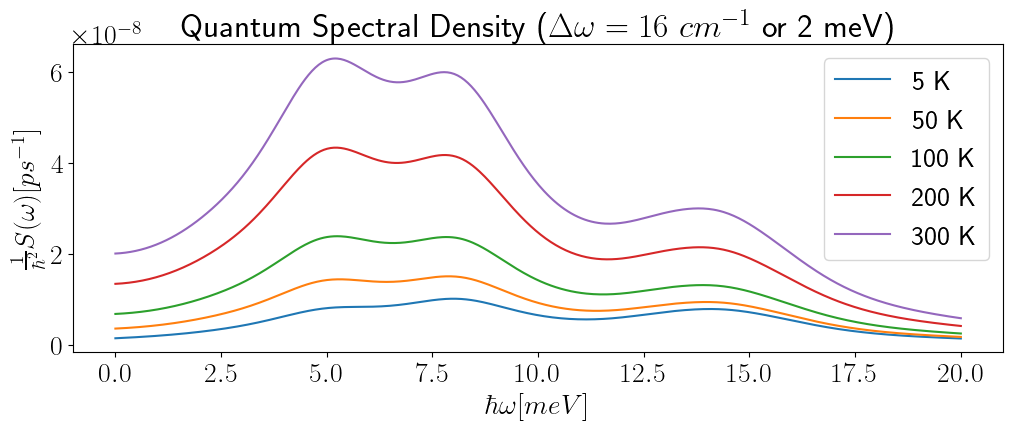

In [24]:
x = np.linspace(0, 20, 500)
y5q = [spectral_density_quantum(w, freqs=freq, coup=gcoupS[:,2], T=5, sigma=2)/hbar**2 for w in x]
y50q = [spectral_density_quantum(w, freqs=freq, coup=gcoupS[:,2], T=50, sigma=2)/hbar**2 for w in x]
y100q = [spectral_density_quantum(w, freqs=freq, coup=gcoupS[:,2], T=100, sigma=2)/hbar**2 for w in x]
y200q = [spectral_density_quantum(w, freqs=freq, coup=gcoupS[:,2], T=200, sigma=2)/hbar**2 for w in x]
y300q = [spectral_density_quantum(w, freqs=freq, coup=gcoupS[:,2], T=300, sigma=2)/hbar**2 for w in x]
plt.figure(figsize=(12,4))
plt.plot(x,y5q)
plt.plot(x,y50q)
plt.plot(x,y100q)
plt.plot(x,y200q)
plt.plot(x,y300q)
plt.title(r"Quantum Spectral Density ($\Delta \omega = 16 \ cm^{-1}$ or 2 meV) ")
plt.xlabel(r"$\hbar \omega [meV]$")
plt.ylabel(r"$\frac{1}{\hbar^2}S(\omega) [ps^{-1}]$")
plt.legend(['5 K','50 K','100 K', '200 K', '300 K'])
plt.show()

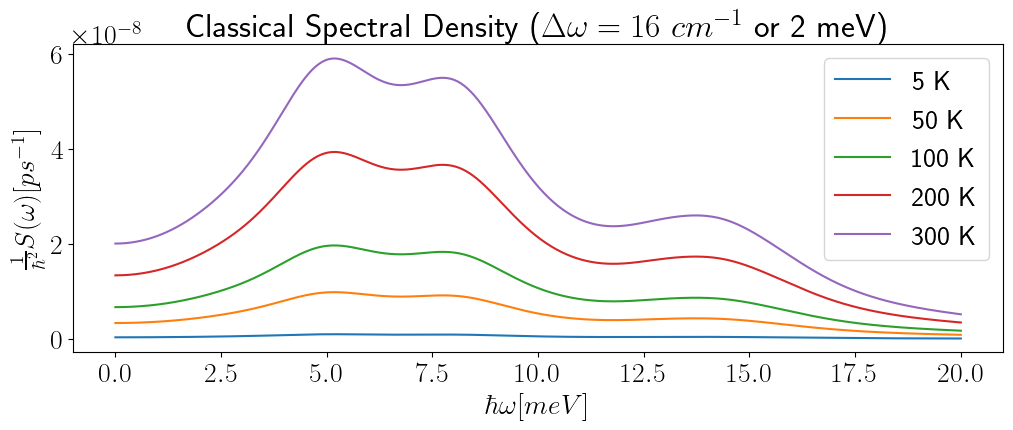

In [25]:
x = np.linspace(0, 20, 500)
y5c = [spectral_density_classical(w, freqs=freq, coup=gcoupS[:,2], T=5, sigma=2)/hbar**2 for w in x]
y50c = [spectral_density_classical(w, freqs=freq, coup=gcoupS[:,2], T=50, sigma=2)/hbar**2 for w in x]
y100c = [spectral_density_classical(w, freqs=freq, coup=gcoupS[:,2], T=100, sigma=2)/hbar**2 for w in x]
y200c = [spectral_density_classical(w, freqs=freq, coup=gcoupS[:,2], T=200, sigma=2)/hbar**2 for w in x]
y300c = [spectral_density_classical(w, freqs=freq, coup=gcoupS[:,2], T=300, sigma=2)/hbar**2 for w in x]

plt.figure(figsize=(12,4))
plt.plot(x,y5c)
plt.plot(x,y50c)
plt.plot(x,y100c)
plt.plot(x,y200c)
plt.plot(x,y300c)
plt.title(r"Classical Spectral Density ($\Delta \omega = 16 \ cm^{-1}$ or 2 meV) ")
plt.xlabel(r"$\hbar \omega [meV]$")
plt.ylabel(r"$\frac{1}{\hbar^2}S(\omega) [ps^{-1}]$")
plt.legend(['5 K','50 K','100 K', '200 K', '300 K'])
plt.show()

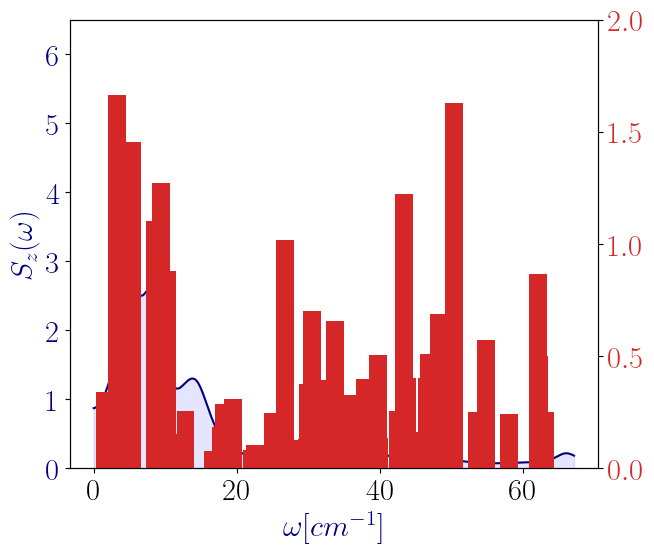

In [26]:
plt.rcParams.update({'font.size': 22})
#plt.rcParams["figure.autolayout"] = True
highfreq = 59

xspec = np.linspace(0, freq[highfreq], 500)
yspec = [spectral_density_quantum(w, freqs=freq, coup=gcoupS[:,2], T=300, sigma=2) for w in xspec]

fig, ax1 = plt.subplots(figsize=(7,6))

color = 'navy'
ax1.set_xlabel(r"$\omega [cm^{-1}]$",color=color)
ax1.set_ylabel(r"$S_z(\omega)$", color=color)
ax1.set_ylim([0, 6.5])
ax1.plot(xspec,np.array(yspec)*1e8,color=color)
ax1.fill_between(xspec, np.array(yspec)*1e8, 0, color='blue', alpha=.1)
ax1.tick_params(axis='y', labelcolor=color)


gnorm = np.array([np.sqrt(dgx[i,2,2]**2) for i in range(len(freq[:highfreq]))])


ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:red'
#ax2.set_ylabel(r"$|g_{zz}| $", color=color)  # we already handled the x-label with ax1
#ax2.set_yscale('log')
ax2.bar(freq[:highfreq], gnorm*1e3, width=2.5, color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim([0, 2])

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

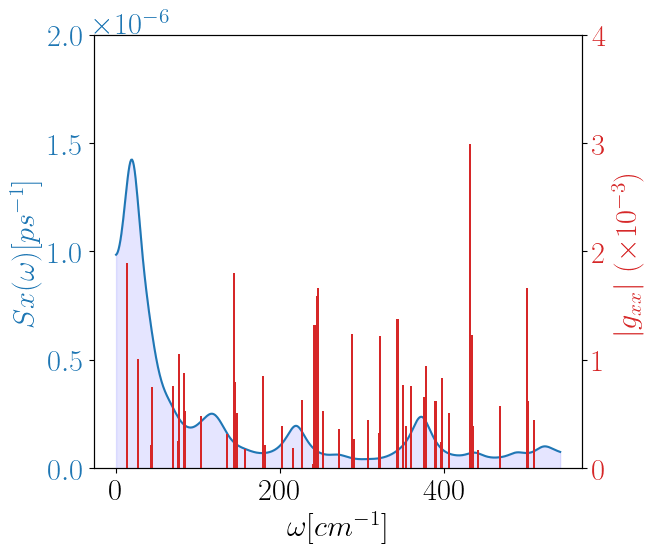

In [27]:
highfreq = 59

xspec = np.linspace(0, freq[highfreq], 500)
yspec = [spectral_density_quantum(w, freqs=freq, coup=gcoupS[:,0], T=300, sigma=2)/hbar**2 for w in xspec]

fig, ax1 = plt.subplots(figsize=(7,6))

color = 'tab:blue'
ax1.set_xlabel(r"$\omega [cm^{-1}]$")
ax1.set_ylabel(r"$Sx(\omega) [ps^{-1}]$", color=color)
ax1.set_ylim([0, 2e-6])
ax1.plot(xspec/cm2mev,np.array(yspec)*1e1,color=color)
ax1.fill_between(xspec/cm2mev, np.array(yspec)*1e1, 0, color='blue', alpha=.1)
ax1.tick_params(axis='y', labelcolor=color)


gnorm = np.array([np.sqrt(dgx[i,0,2]**2) for i in range(len(freq[:highfreq]))])


ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:red'
ax2.set_ylabel(r"$|g_{xx}| \ (\times 10^{-3})$", color=color)  # we already handled the x-label with ax1
#ax2.set_yscale('log')
ax2.bar(freq[:highfreq]/cm2mev, gnorm*1e3, width=2.5, color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim([0, 4])

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

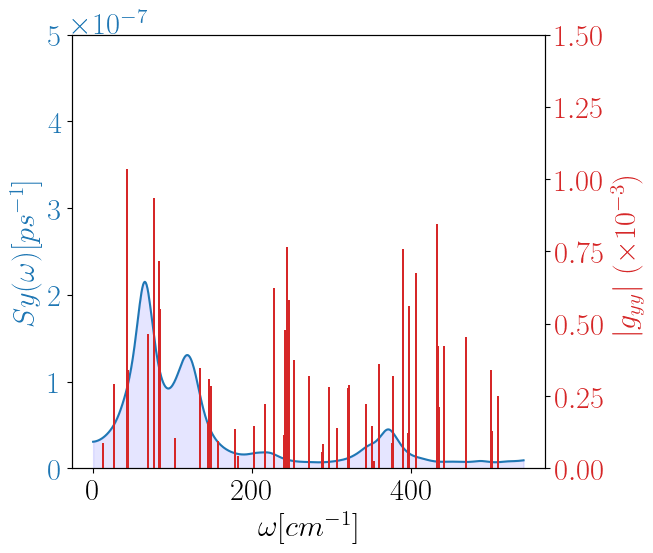

In [28]:
highfreq = 59

xspec = np.linspace(0, freq[highfreq], 500)
yspec = [spectral_density_quantum(w, freqs=freq, coup=gcoupS[:,1], T=300, sigma=2)/hbar**2 for w in xspec]

fig, ax1 = plt.subplots(figsize=(7,6))

color = 'tab:blue'
ax1.set_xlabel(r"$\omega [cm^{-1}]$")
ax1.set_ylabel(r"$Sy(\omega) [ps^{-1}]$", color=color)
ax1.set_ylim([0, 0.5e-6])
ax1.plot(xspec/cm2mev,np.array(yspec)*1e1,color=color)
ax1.fill_between(xspec/cm2mev, np.array(yspec)*1e1, 0, color='blue', alpha=.1)
ax1.tick_params(axis='y', labelcolor=color)


gnorm = np.array([np.sqrt(dgx[i,1,2]**2) for i in range(len(freq[:highfreq]))])


ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:red'
ax2.set_ylabel(r"$|g_{yy}| \ (\times 10^{-3})$", color=color)  # we already handled the x-label with ax1
#ax2.set_yscale('log')
ax2.bar(freq[:highfreq]/cm2mev, gnorm*1e3, width=2.5, color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim([0, 1.5])

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

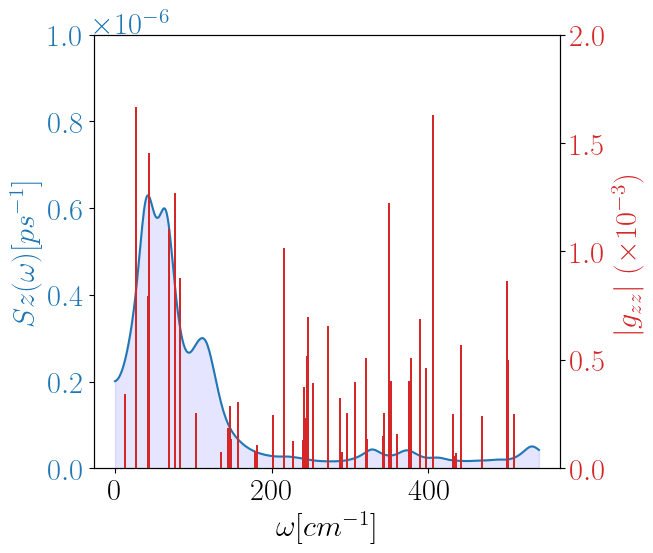

In [29]:
highfreq = 59

xspec = np.linspace(0, freq[highfreq], 500)
yspec = [spectral_density_quantum(w, freqs=freq, coup=gcoupS[:,2], T=300, sigma=2)/hbar**2 for w in xspec]

fig, ax1 = plt.subplots(figsize=(7,6))

color = 'tab:blue'
ax1.set_xlabel(r"$\omega [cm^{-1}]$")
ax1.set_ylabel(r"$Sz(\omega) [ps^{-1}]$", color=color)
ax1.set_ylim([0, 1e-6])
ax1.plot(xspec/cm2mev,np.array(yspec)*1e1,color=color)
ax1.fill_between(xspec/cm2mev, np.array(yspec)*1e1, 0, color='blue', alpha=.1)
ax1.tick_params(axis='y', labelcolor=color)


gnorm = np.array([np.sqrt(dgx[i,2,2]**2) for i in range(len(freq[:highfreq]))])


ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:red'
ax2.set_ylabel(r"$|g_{zz}| \ (\times 10^{-3})$", color=color)  # we already handled the x-label with ax1
#ax2.set_yscale('log')
ax2.bar(freq[:highfreq]/cm2mev, gnorm*1e3, width=2.5, color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim([0, 2])

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

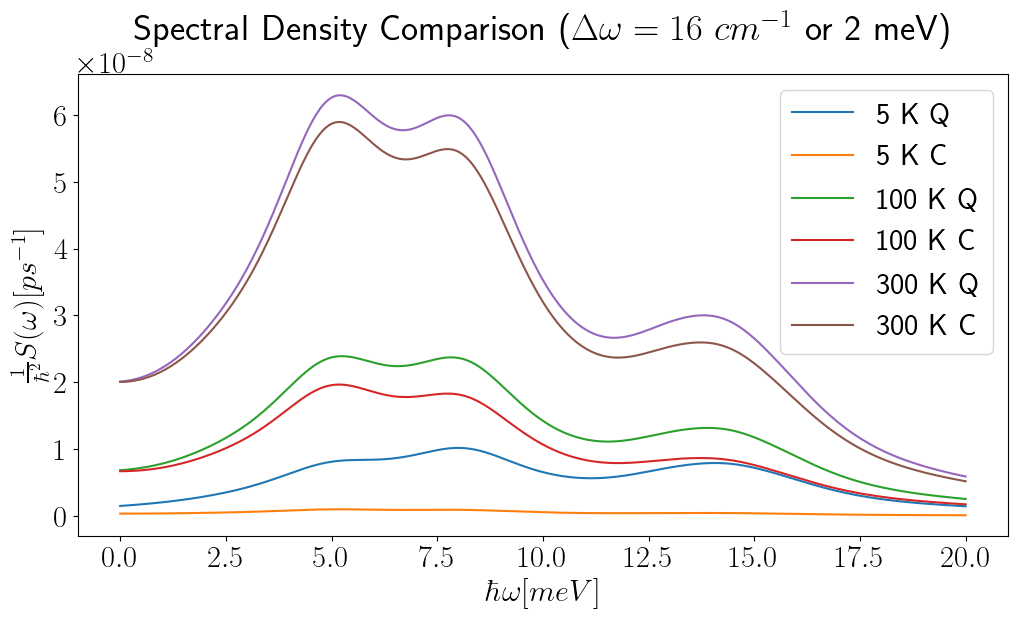

In [30]:
plt.figure(figsize=(12,6))
plt.plot(x,y5q)
plt.plot(x,y5c)
plt.plot(x,y100q)
plt.plot(x,y100c)
plt.plot(x,y300q)
plt.plot(x,y300c)
plt.title(r"Spectral Density Comparison ($\Delta \omega = 16 \ cm^{-1}$ or 2 meV) ")
plt.xlabel(r"$\hbar \omega [meV]$")
plt.ylabel(r"$\frac{1}{\hbar^2}S(\omega) [ps^{-1}]$")

plt.legend(['5 K Q','5 K C','100 K Q', '100 K C', '300 K Q', '300 K C'])
plt.show()

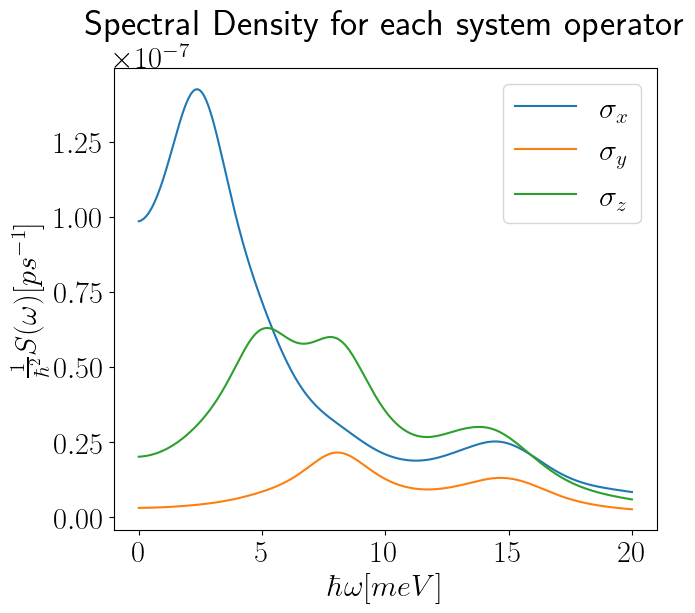

In [31]:
x = np.linspace(0, 20, 500)
yx = [spectral_density_quantum(w, freqs=freq, coup=gcoupS[:,0], T=300, sigma=2)/hbar**2 for w in x]
yy = [spectral_density_quantum(w, freqs=freq, coup=gcoupS[:,1], T=300, sigma=2)/hbar**2 for w in x]
yz = [spectral_density_quantum(w, freqs=freq, coup=gcoupS[:,2], T=300, sigma=2)/hbar**2 for w in x]

plt.figure(figsize=(7,6))
plt.plot(x,yx)
plt.plot(x,yy)
plt.plot(x,yz)
plt.title(r"Spectral Density for each system operator ")
plt.xlabel(r"$\hbar \omega [meV]$")
plt.ylabel(r"$\frac{1}{\hbar^2}S(\omega) [ps^{-1}]$")
plt.legend([r"$\sigma_x$", r"$\sigma_y$", r"$\sigma_z$"])
plt.show()

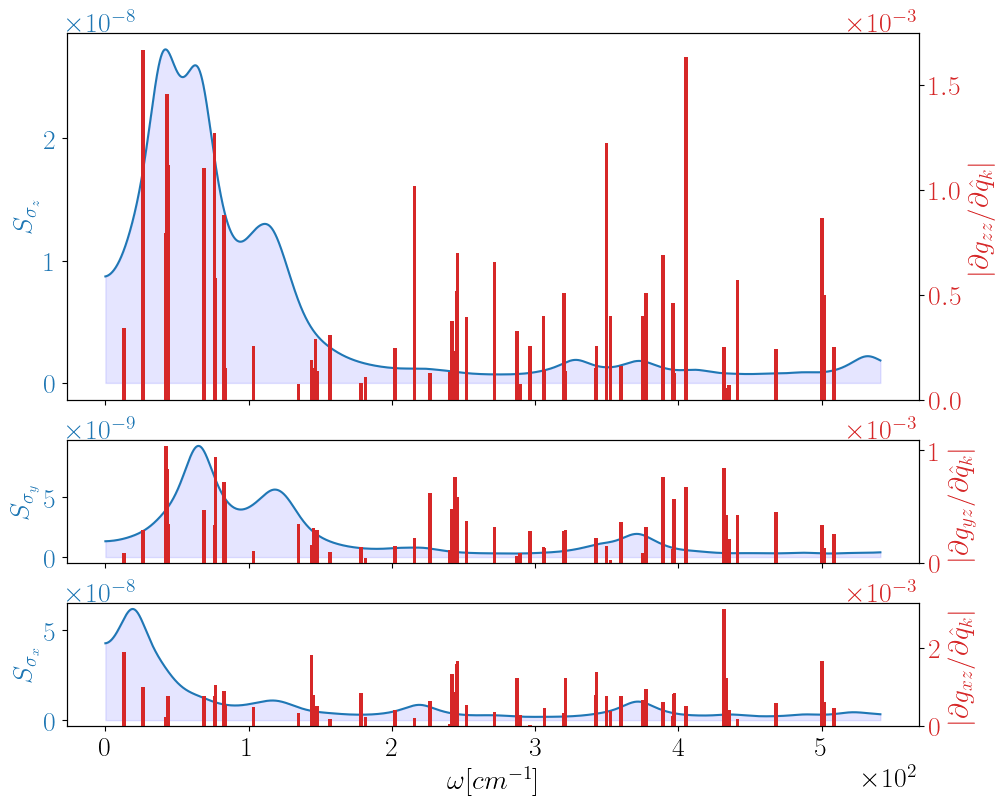

In [32]:
plt.rcParams['text.usetex'] = True 
plt.rcParams["axes.formatter.limits"]=(0,0)
plt.rcParams.update({'font.size': 20})

#fig, axs = plt.subplots(3, sharex=True)
fig, axs = plt.subplots(3,1,figsize=(11,9),sharex=True, gridspec_kw={'height_ratios': [3, 1,1]})
#fig = plt.figure(figsize=(7, 9))
#gs = fig.add_gridspec(3, hspace=0)
#axs = gs.subplots(sharex=True, sharey=False)

highfreq = 59

xspec = np.linspace(0, freq[highfreq], 5000)
yspec = [spectral_density_quantum(w, freqs=freq, coup=gcoupS[:,2], T=300, sigma=2) for w in xspec]
color = 'tab:blue'
axs[0].set_xlabel(r"$\omega [cm^{-1}]$")
axs[0].set_ylabel(r"$S_{\sigma_z}$", color=color)
#axs[0].set_ylim([0, 5])
axs[0].plot(xspec/cm2mev,np.array(yspec),color=color)
axs[0].fill_between(xspec/cm2mev, np.array(yspec), 0, color='blue', alpha=.1)
axs[0].tick_params(axis='y', labelcolor=color)

ax2 = axs[0].twinx()  # instantiate a second axes that shares the same x-axis
gnorm = np.array([np.sqrt(dgx[i,2,2]**2) for i in range(len(freq[:highfreq]))])

color = 'tab:red'
ax2.set_ylabel(r"$|\partial g_{zz}/\partial \hat q_k|$", color=color)  # we already handled the x-label with ax1
#ax2.set_yscale('log')
ax2.bar(freq[:highfreq]/cm2mev, gnorm, width=2.5, color=color)
ax2.tick_params(axis='y', labelcolor=color)
#ax2.set_ylim([0, 10])


#############

yspec = [spectral_density_quantum(w, freqs=freq, coup=gcoupS[:,1], T=300, sigma=2) for w in xspec]
color = 'tab:blue'
axs[1].set_xlabel(r"$\omega [cm^{-1}]$")
axs[1].set_ylabel(r"$S_{\sigma_y} $", color=color)
#axs[1].set_ylim([0, 5])
axs[1].plot(xspec/cm2mev,np.array(yspec),color=color)
axs[1].fill_between(xspec/cm2mev, np.array(yspec), 0, color='blue', alpha=.1)
axs[1].tick_params(axis='y', labelcolor=color)

ax2 = axs[1].twinx()  # instantiate a second axes that shares the same x-axis
gnorm = np.array([np.sqrt(dgx[i,1,2]**2) for i in range(len(freq[:highfreq]))])

color = 'tab:red'
ax2.set_ylabel(r"$|\partial g_{yz}/\partial \hat q_k|$", color=color)  # we already handled the x-label with ax1
#ax2.set_yscale('log')
ax2.bar(freq[:highfreq]/cm2mev, gnorm, width=2.5, color=color)
ax2.tick_params(axis='y', labelcolor=color)
#ax2.set_ylim([0, 10])


#############

yspec = [spectral_density_quantum(w, freqs=freq, coup=gcoupS[:,0], T=300, sigma=2) for w in xspec]
color = 'tab:blue'
axs[2].set_xlabel(r"$\omega [cm^{-1}]$")
axs[2].set_ylabel(r"$S_{\sigma_x}$", color=color)
#axs[2].set_ylim([0, 5])
axs[2].plot(xspec/cm2mev,np.array(yspec),color=color)
axs[2].fill_between(xspec/cm2mev, np.array(yspec), 0, color='blue', alpha=.1)
axs[2].tick_params(axis='y', labelcolor=color)

ax2 = axs[2].twinx()  # instantiate a second axes that shares the same x-axis
gnorm = np.array([np.sqrt(dgx[i,0,2]**2) for i in range(len(freq[:highfreq]))])

color = 'tab:red'
ax2.set_ylabel(r"$|\partial g_{xz}/\partial \hat q_k|$", color=color)  # we already handled the x-label with ax1
#ax2.set_yscale('log')
ax2.bar(freq[:highfreq]/cm2mev, gnorm, width=2.5, color=color)
ax2.tick_params(axis='y', labelcolor=color)
#ax2.set_ylim([0, 10])


# Hide x labels and tick labels for all but bottom plot.
for ax in axs:
    ax.label_outer()

In [33]:
alpha

0.057884270182028845

## At this point it is important to note that the useful values of w at which we need S are w=0 and w=energy split

In [35]:
w_split = energies[1]- energies[0]
print(r"hbar*w_split= ", w_split, " meV, ","w_split/hbar= ", w_split/hbar, " freq")

hbar*w_split=  0.11520085882875064  meV,  w_split/hbar=  0.17502091636854927  freq


# Redfield with full set of modes for T1 and T2

## T1 Dynamics

10.0%. Run time:   0.12s. Est. time left: 00:00:00:01
20.0%. Run time:   0.25s. Est. time left: 00:00:00:00
30.0%. Run time:   0.37s. Est. time left: 00:00:00:00
40.0%. Run time:   0.49s. Est. time left: 00:00:00:00
50.0%. Run time:   0.61s. Est. time left: 00:00:00:00
60.0%. Run time:   0.73s. Est. time left: 00:00:00:00
70.0%. Run time:   0.85s. Est. time left: 00:00:00:00
80.0%. Run time:   0.97s. Est. time left: 00:00:00:00
90.0%. Run time:   1.09s. Est. time left: 00:00:00:00
Total run time:   1.21s


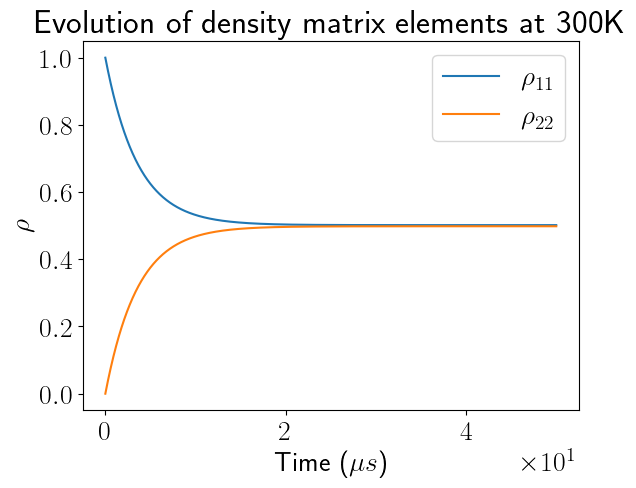

In [86]:
# Single Run
Temp = 300

tlist = np.linspace(1, 50e6, 2000) # in ps

specDensityX = lambda w : spectral_density_quantum(w, freqs=freq, coup=gcoupS[:,0], T=Temp, sigma=2, shape='G')/hbar**2
specDensityY = lambda w : spectral_density_quantum(w, freqs=freq, coup=gcoupS[:,1], T=Temp, sigma=2, shape='G')/hbar**2
specDensityZ = lambda w : spectral_density_quantum(w, freqs=freq, coup=gcoupS[:,2], T=Temp, sigma=2, shape='G')/hbar**2

e_ops = []

aops = [[sigmax(),specDensityX], [sigmay(),specDensityY], [sigmaz(),specDensityZ]]


rho0 = basis(2,0)*basis(2,0).dag()
results1 = brmesolve(-H/(hbar), rho0, tlist, a_ops=aops, e_ops=e_ops, progress_bar=True)

rho11_vals = np.array([results1.states[k].full()[0,0] for k in range(len(tlist))])
rho22_vals = np.array([results1.states[k].full()[1,1] for k in range(len(tlist))])

plt.figure()
plt.plot(tlist/1e6, np.abs(rho11_vals))
plt.plot(tlist/1e6, np.abs(rho22_vals))
plt.xlabel(r"Time ($\mu s$)")
plt.ylabel(r"$\rho$")
plt.title("Evolution of density matrix elements at "+str(Temp)+"K")
plt.legend([r"$\rho_{11}$", r"$\rho_{22}$"])
plt.show()

In [87]:
kB = 8.617333262e-2 # meV/K, Boltzmann constant
w_th = kB*Temp/hbar # temperature defined as frequency
nth = n_thermal(energies[1]/hbar,w_th)
thermal_rho_11 = thermal_dm(2, nth, method='operator').full()[0].real[0]
thermal_rho_11

0.5005570207920286

In [88]:
# curve fitting to extract T1.
def t1_func_thermal(x,t1):
    kB = 8.6173e-2 # meV/K, Boltzmann constant
    w_th = kB*Temp/hbar # temperature defined as frequency
    nth = n_thermal(energies[1]/hbar,w_th)
    thermal_rho_11 = thermal_dm(2, nth, method='operator').full()[0].real[0]
    return (1-thermal_rho_11)*np.exp(-x/t1)+thermal_rho_11

def t1_func(x,t1, xinf):
    return (1-xinf)*np.exp(-x/t1)+xinf
    
def t1_func_classical(x,t1):
    return (1/2)*np.exp(-x/t1) + (1/2)

In [89]:
fthermal, df = curve_fit(t1_func_thermal, tlist/1e6, np.abs(rho11_vals))
fclassical, df = curve_fit(t1_func_classical, tlist/1e6, np.abs(rho11_vals))
f, df = curve_fit(t1_func, tlist/1e6, np.abs(rho11_vals))
f

array([3.56951316, 0.50168757])

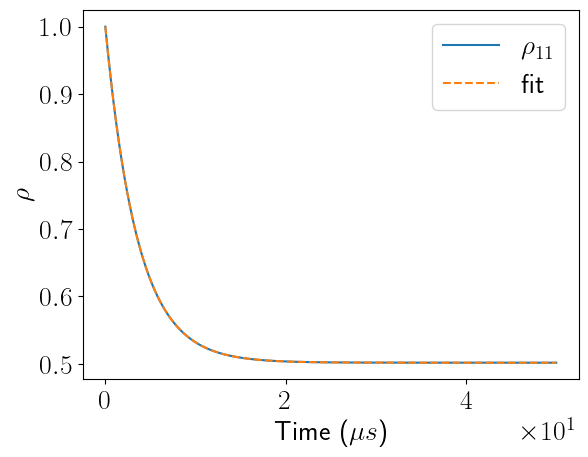

In [91]:
fit_thermal = np.array([t1_func_classical(k, fthermal)  for k in tlist/1e6])
fit_classical = np.array([t1_func_classical(k, fclassical)  for k in tlist/1e6])
fit_f = np.array([t1_func(k, f[0],f[1])  for k in tlist/1e6])
plt.figure()
plt.plot(tlist/1e6, np.abs(rho11_vals))
plt.plot(tlist/1e6, fit_f, '--')
#plt.plot(tlist/1e6, fit_thermal)
plt.xlabel(r"Time ($\mu s$)")
plt.ylabel(r"$\rho$")
#plt.title("Evolution of densitymatrix elements at "+str(Temp)+"K, T1 = "+str(f))
#plt.legend([r"$\rho_{11}$", r"fit $t_1 = $"+str(np.round(f,2)[0])+r"$\ \mu s$", r"fit_thermal $t_1 = $"+str(np.round(fthermal,2)[0])+r"$\ \mu s$"])
plt.legend([r"$\rho_{11}$", r"fit"])
plt.show()

### Now checking the respose of T1 from 5K to 300 K

In [48]:
# Temperature Scan, multiple runs
Temp_list = [5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 120, 140, 160, 180, 200, 220, 240, 260, 280, 300, 320]
tlist = np.linspace(1, 10000e6, 2000) # in ps

5
saturation value difference (-2.447452179810128e-08+0j)


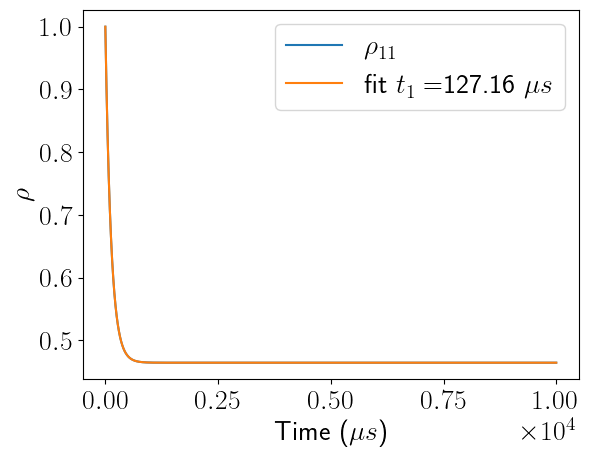

10
saturation value difference (1.268640109630681e-08+0j)


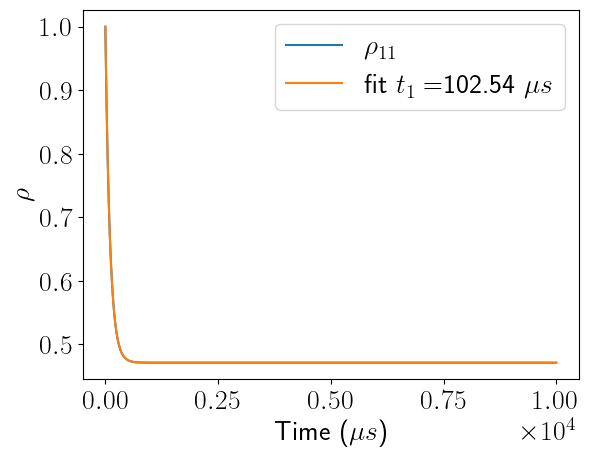

20
saturation value difference (-1.1544379674433003e-08+0j)


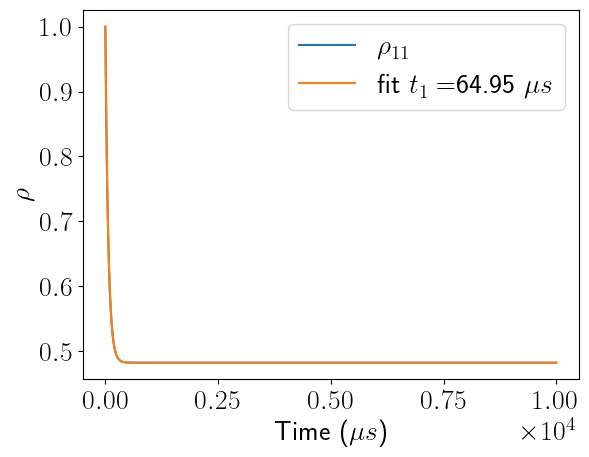

30
saturation value difference (-4.4345152550029354e-09+0j)


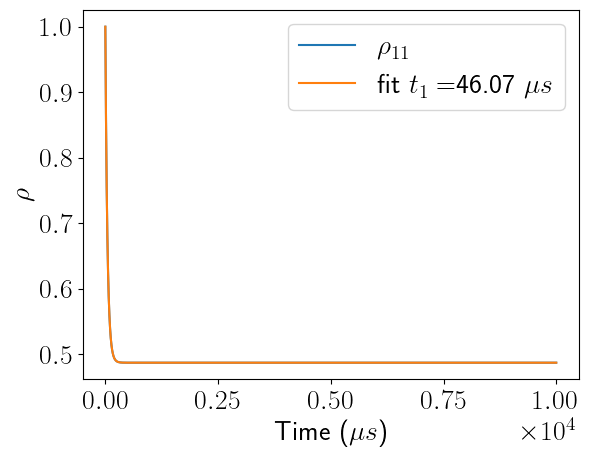

40
saturation value difference (-7.204385810144487e-09+0j)


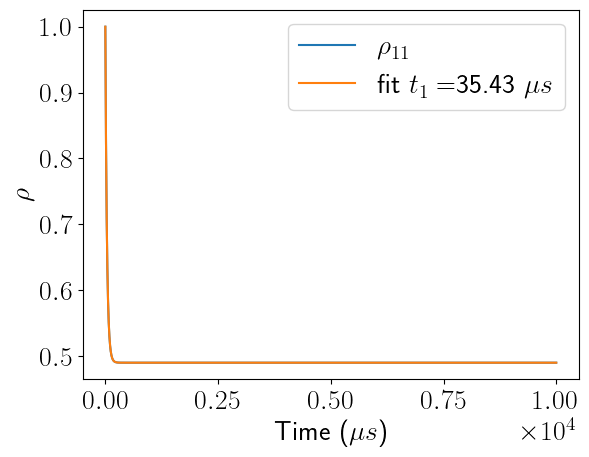

50
saturation value difference (-9.750223295412752e-09+0j)


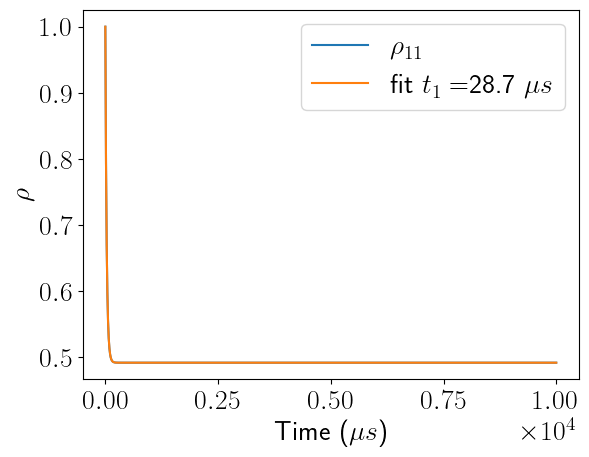

60
saturation value difference (2.5338014963960376e-08+0j)


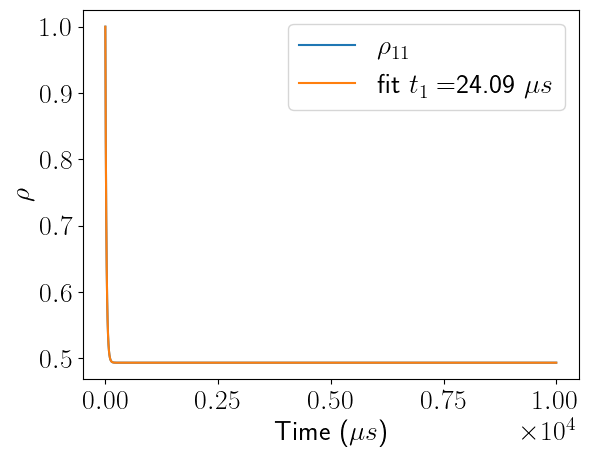

70
saturation value difference (2.1075152178973156e-09+0j)


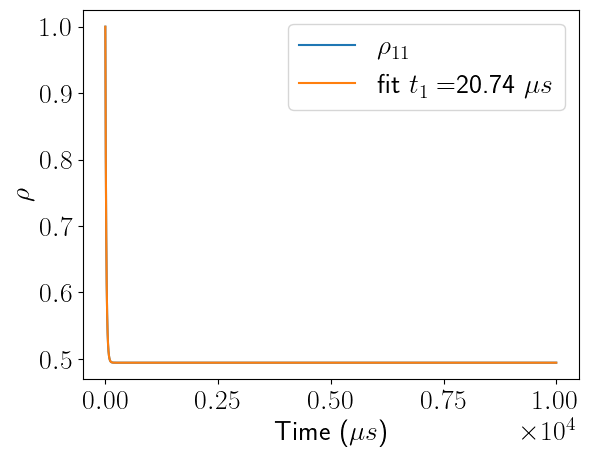

80
saturation value difference (-5.506086142581523e-09+0j)


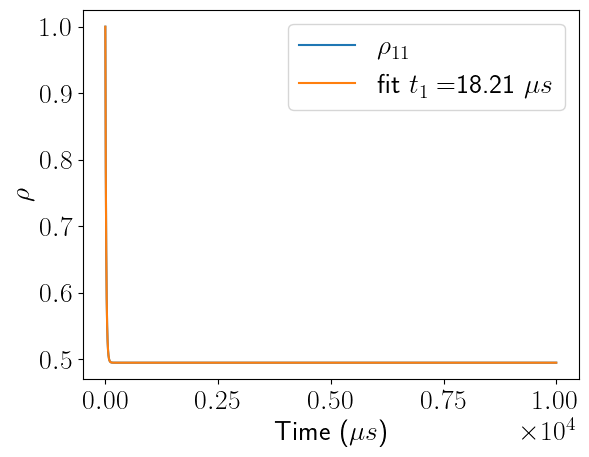

90
saturation value difference (2.956531858222533e-08+0j)


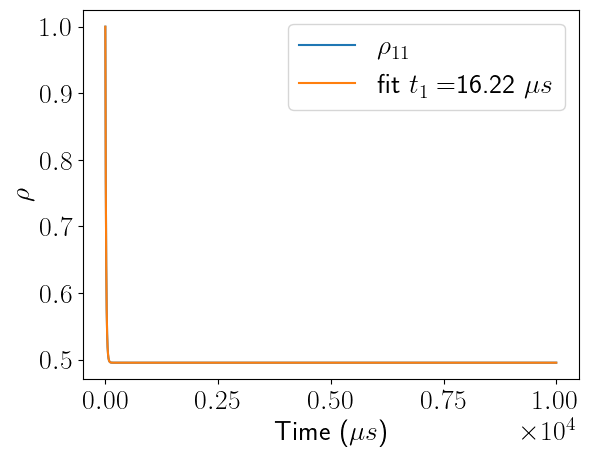

100
saturation value difference (2.2651296449627267e-08+0j)


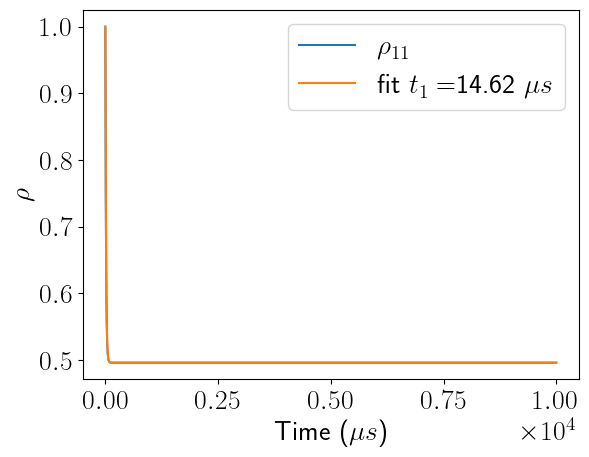

120
saturation value difference (-2.277138111406174e-08+0j)


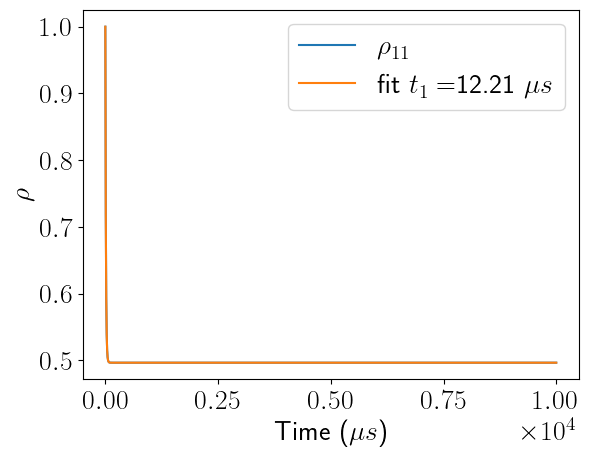

140
saturation value difference (-1.7048392308982585e-08+0j)


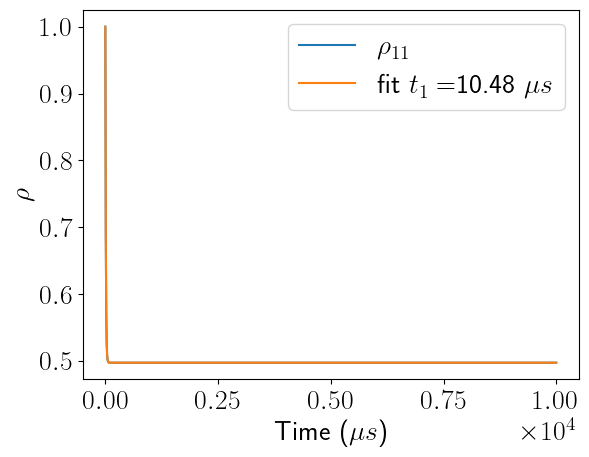

160
saturation value difference (-1.0382828041777259e-08+0j)


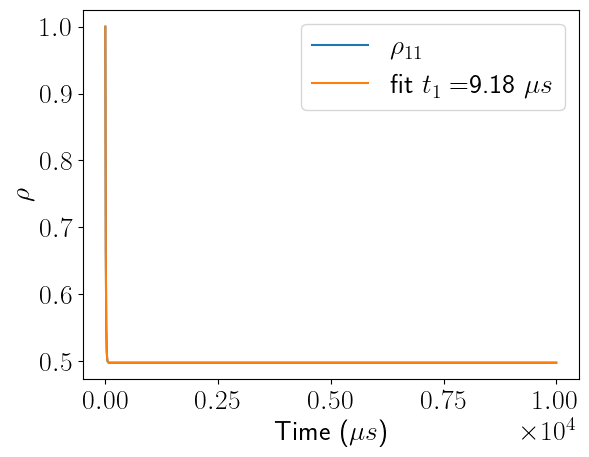

180
saturation value difference (4.488871235830416e-08+0j)


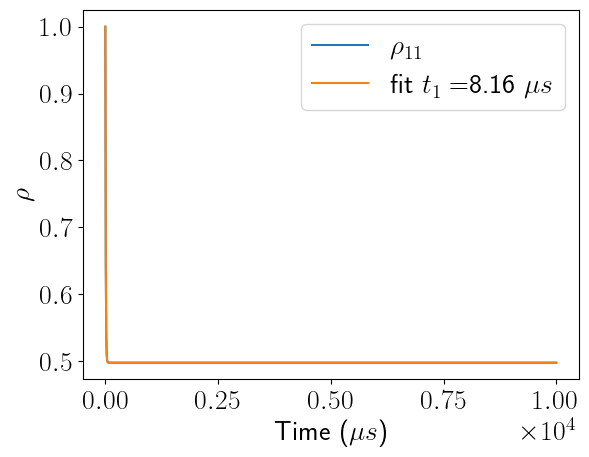

200
saturation value difference (3.7139873954039615e-09+0j)


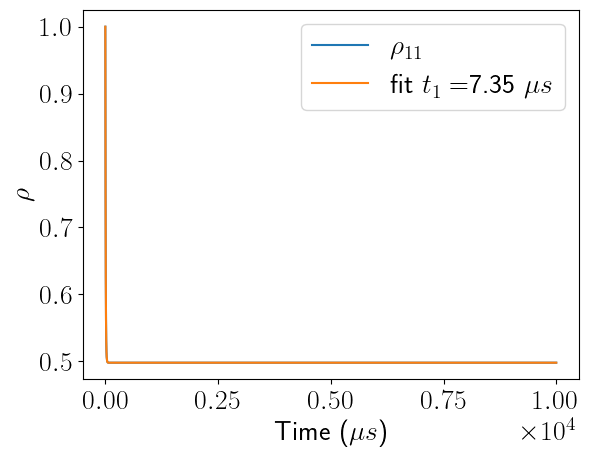

220
saturation value difference (-1.6129732327563318e-08+0j)


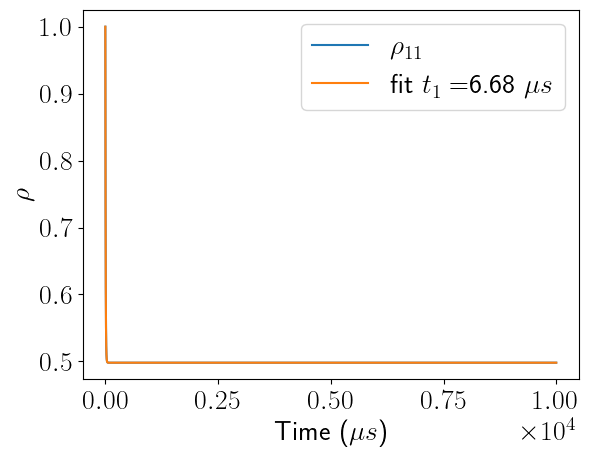

240
saturation value difference (5.0717062827221326e-08+0j)


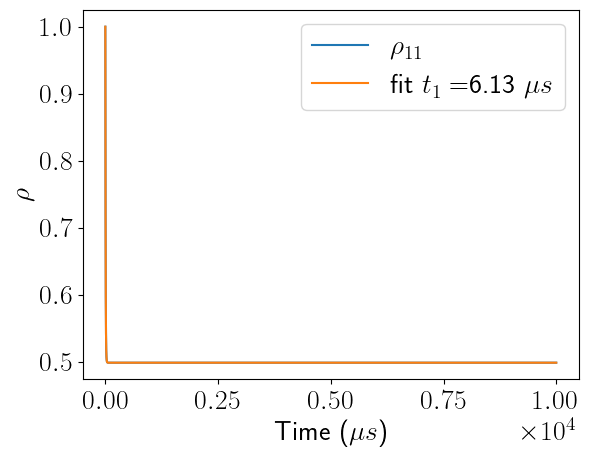

260
saturation value difference (-5.302629313419516e-08+0j)


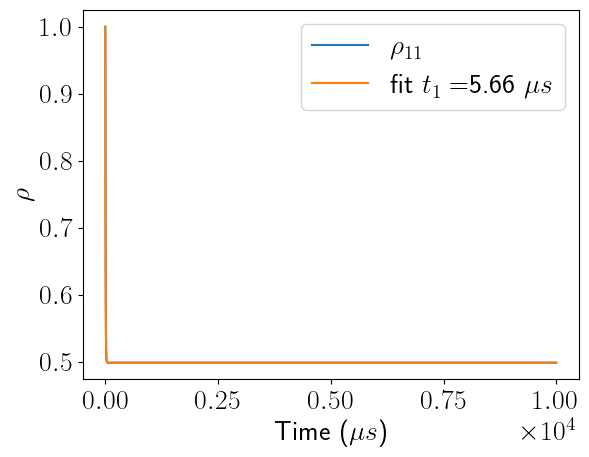

280
saturation value difference (1.2409399785529018e-08+0j)


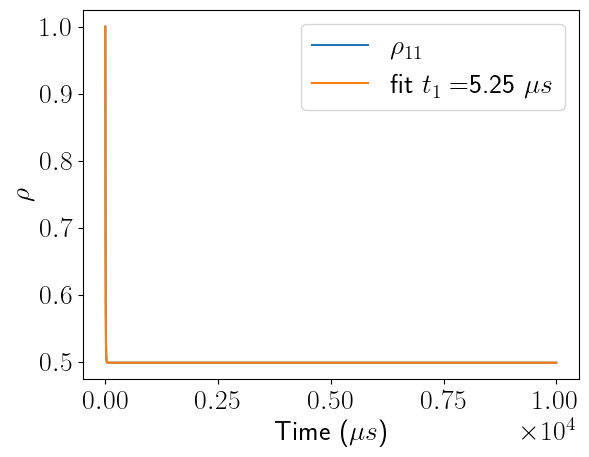

300
saturation value difference (7.225614551131798e-09+0j)


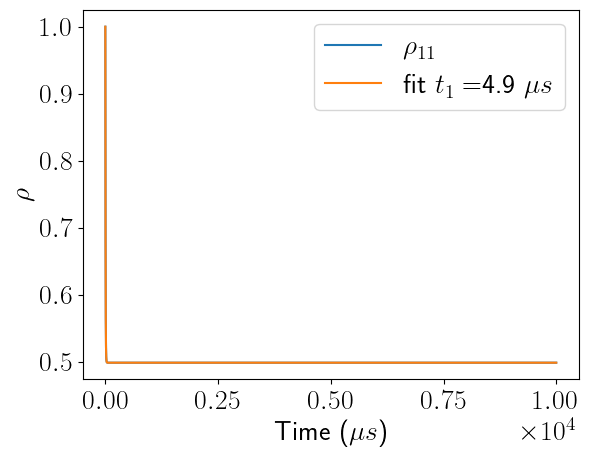

320
saturation value difference (7.582460548327674e-09+0j)


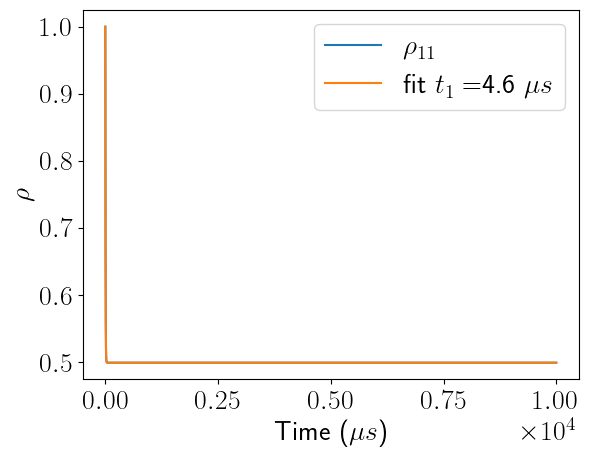

[127.16040333 102.5430231   64.94536042  46.07117922  35.42892798
  28.70145065  24.09100883  20.74323741  18.20558043  16.21740304
  14.61852519  12.20761916  10.47726811   9.1755132    8.16091462
   7.34802424   6.6822006    6.12688267   5.65669649   5.25346895
   4.90386273   4.59785276]


In [62]:
# QUANTUM

t1_list = np.array([])
t1d_list = np.array([])

rho0 = basis(2,0)*basis(2,0).dag()
e_ops = []
rho_list = []

for k in range(len(Temp_list)):
    temp = Temp_list[k]
    print(temp)
    specDensityX = lambda w : spectral_density_quantum(w, freqs=freq, coup=gcoupS[:,0], T=temp, sigma=2, shape='L')/hbar**2
    specDensityY = lambda w : spectral_density_quantum(w, freqs=freq, coup=gcoupS[:,1], T=temp, sigma=2, shape='L')/hbar**2
    specDensityZ = lambda w : spectral_density_quantum(w, freqs=freq, coup=gcoupS[:,2], T=temp, sigma=2, shape='L')/hbar**2
    aops = [[sigmax(),specDensityX], [sigmay(),specDensityY], [sigmaz(),specDensityZ]]
    
    results_k = brmesolve(H/(hbar), rho0, tlist, a_ops=aops, e_ops=e_ops)
    rho_list.append(results_k.states) # saving states for later
    rho11_k = np.array([results_k.states[j].full()[0,0] for j in range(len(tlist))]) # first element of rho vs time 


    fthermal, df = curve_fit(t1_func_thermal, tlist/1e6, np.abs(rho11_k))
    fclassical, df = curve_fit(t1_func_classical, tlist/1e6, np.abs(rho11_k))
    f, df = curve_fit(t1_func, tlist/1e6, np.abs(rho11_k))
    print('saturation value difference', f[1]-rho11_k[-1])
    t1, t1d = f[0], df[0,0]
    t1_list = np.append(t1_list, t1)
    t1d_list = np.append(t1d_list, t1d)
    ##########################################################################################################################
    ################## PLOTTING ################################################
    #fit_thermal = np.array([t1_func_classical(m, fthermal)  for m in tlist/1e6])
    #fit_classical = np.array([t1_func_classical(m, fclassical)  for m in tlist/1e6])
    fit_f = np.array([t1_func(m, f[0],f[1])  for m in tlist/1e6])
    plt.figure()
    plt.plot(tlist/1e6, np.abs(rho11_k))
    plt.plot(tlist/1e6, fit_f)
    #plt.plot(tlist/1e6, fit_thermal)
    plt.xlabel(r"Time ($\mu s$)")
    plt.ylabel(r"$\rho$")
    plt.legend([r"$\rho_{11}$", r"fit $t_1 = $"+str(np.round(f,2)[0])+r"$\ \mu s$", r"fit_thermal $t_1 = $"+str(np.round(fthermal,2)[0])+r"$\ \mu s$"])
    plt.show()
    ############################################################################################################################
np.save('saved variables/t1_list', t1_list)
np.save('saved variables/t1d_list', t1d_list)
print(t1_list) 

5


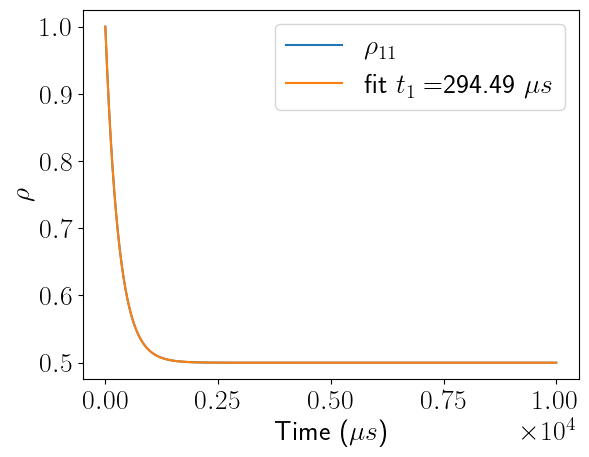

10


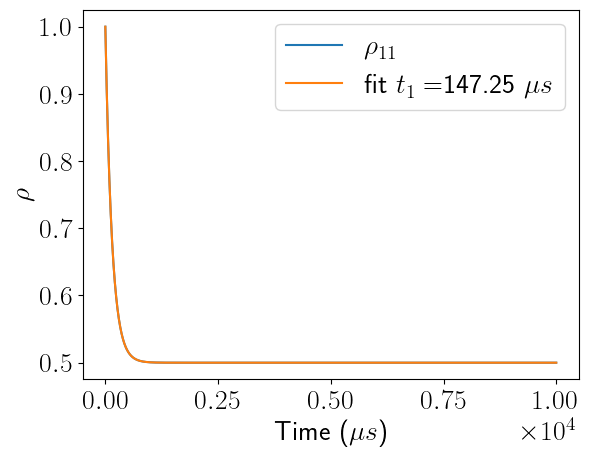

20


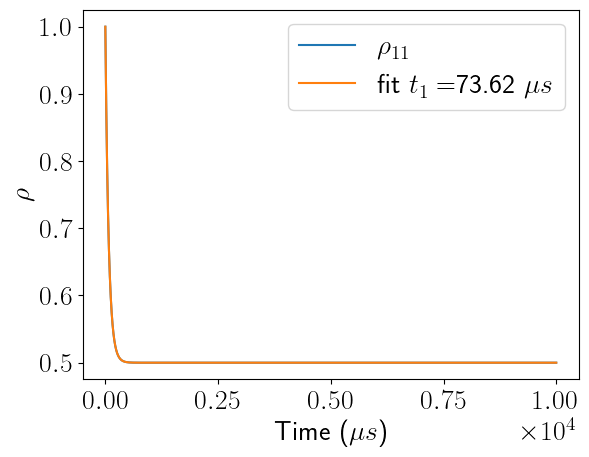

30


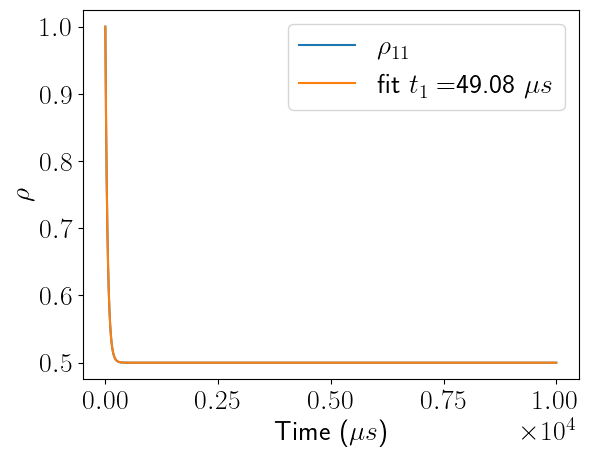

40


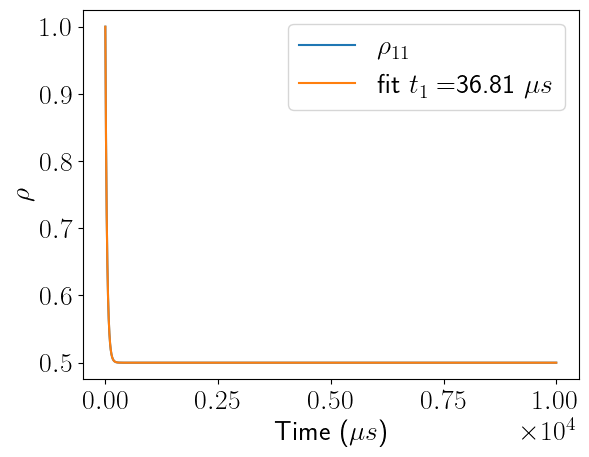

50


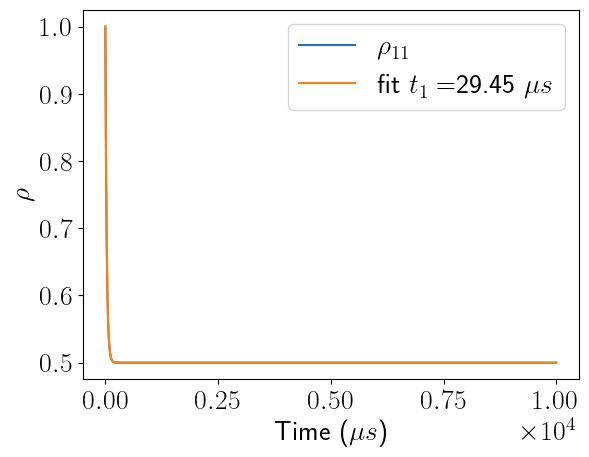

60


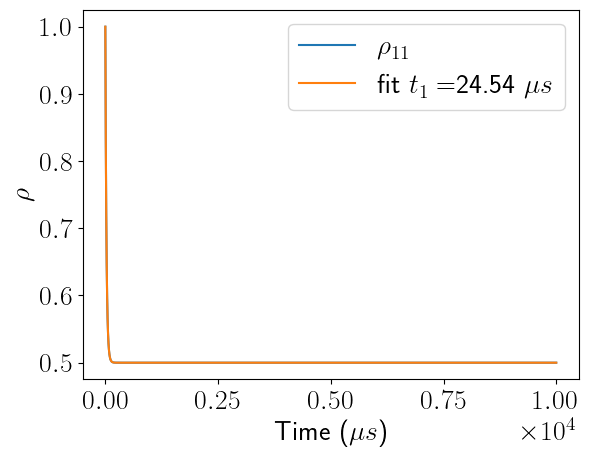

70


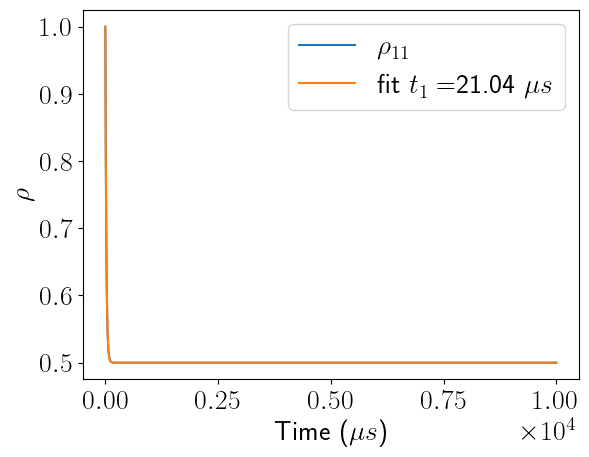

80


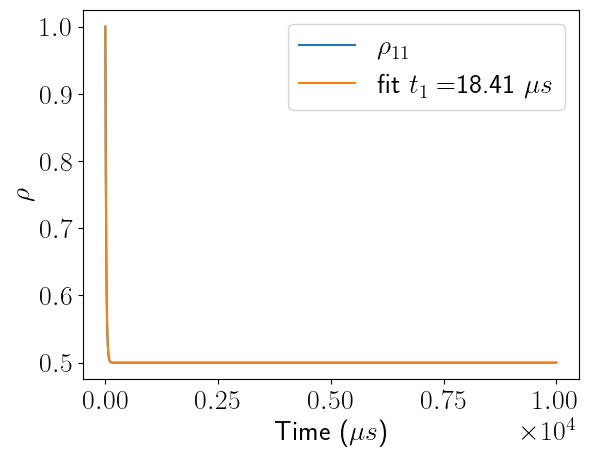

90


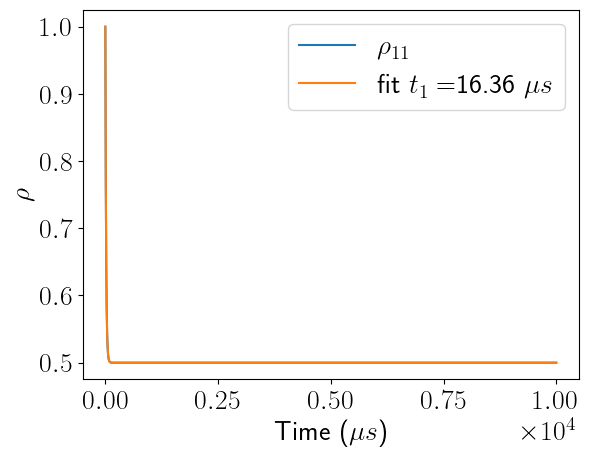

100


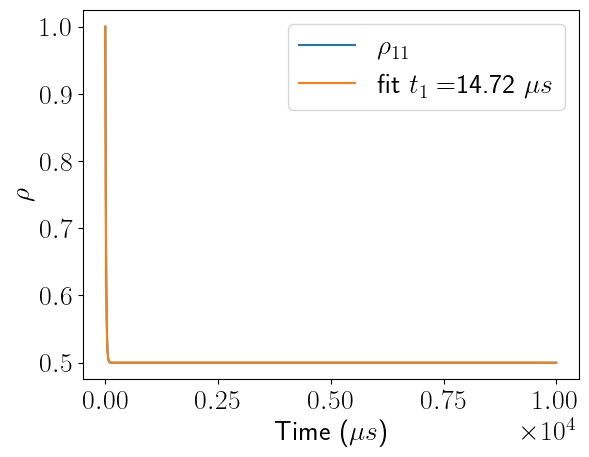

120


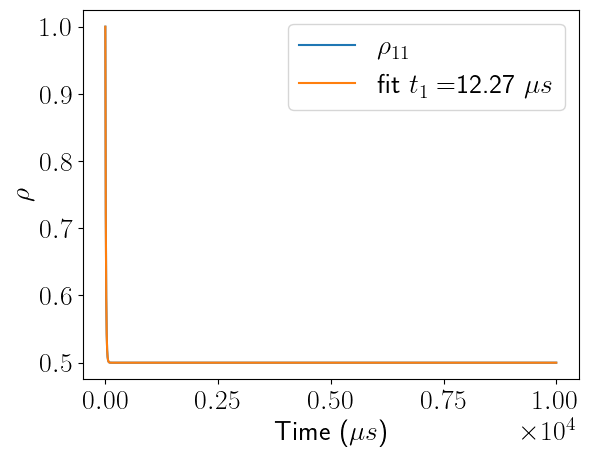

140


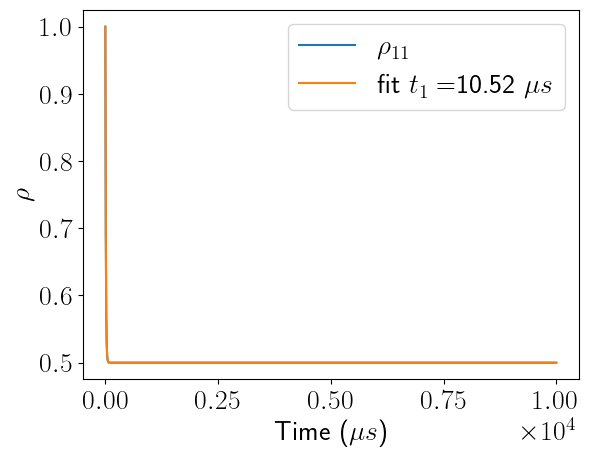

160


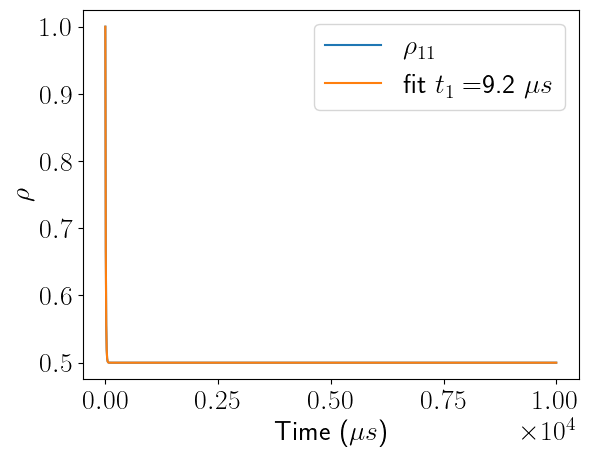

180


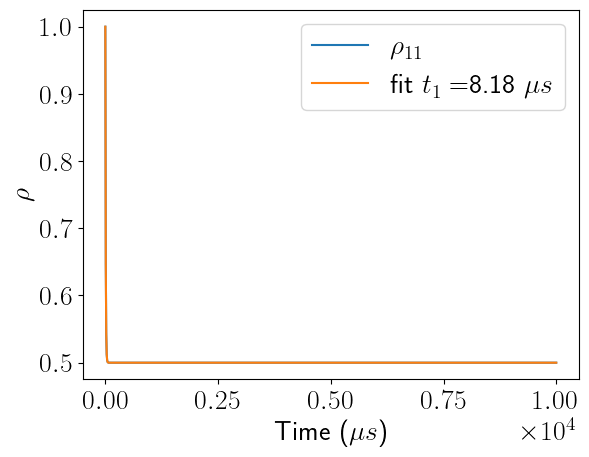

200


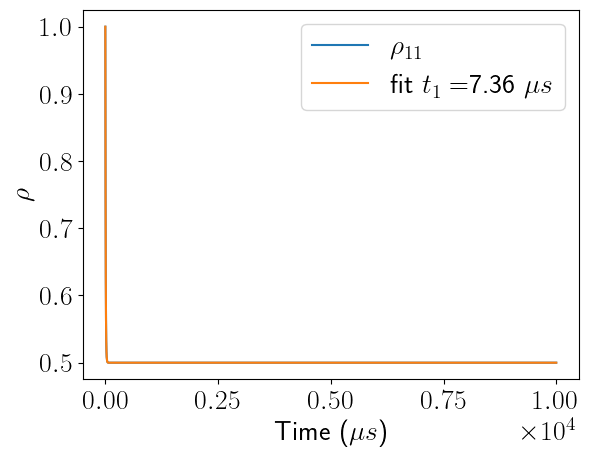

220


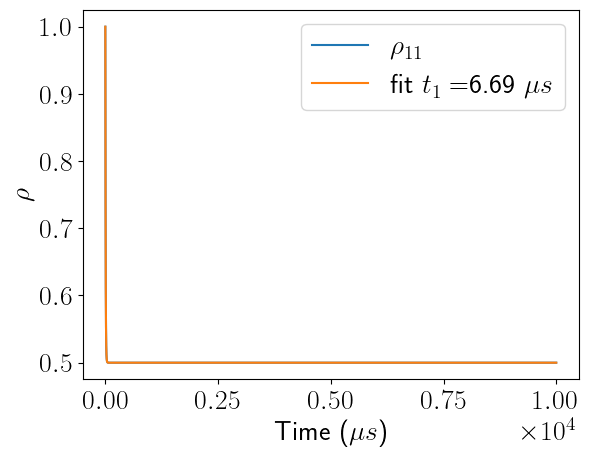

240


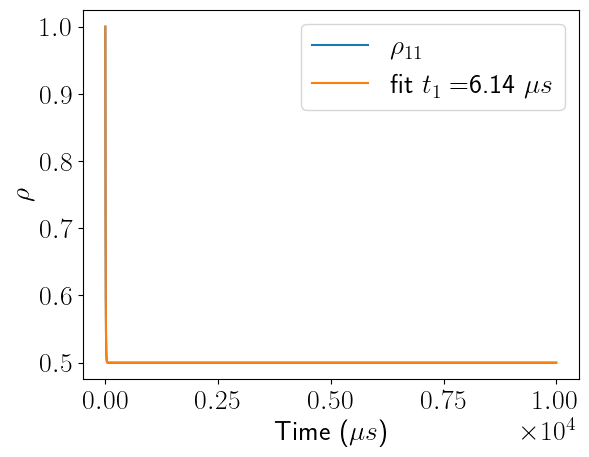

260


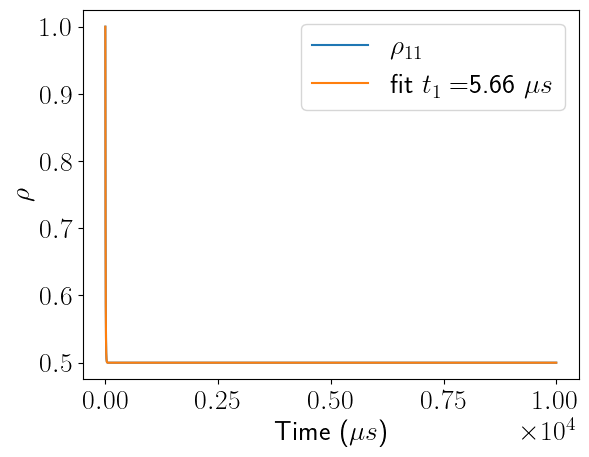

280


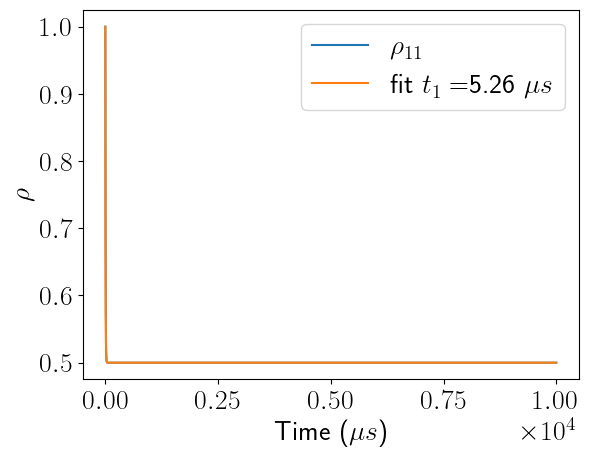

300


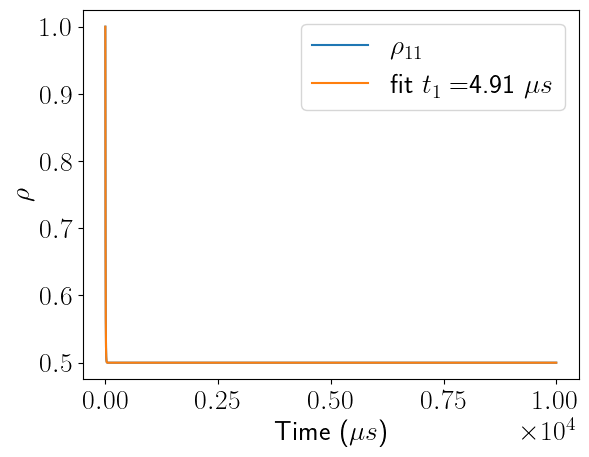

320


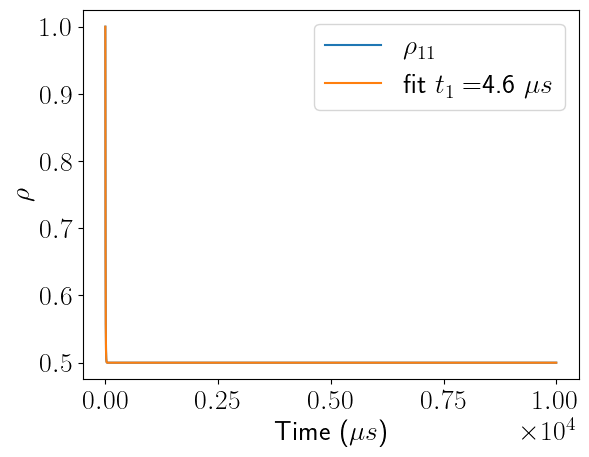

[294.49049297 147.24524699  73.622624    49.08174965  36.81131252
  29.4490501   24.54087458  21.03503519  18.40565646  16.36058359
  14.72452422  12.27043586  10.51751617   9.20282885   8.18029234
   7.36226285   6.69296644   6.13521823   5.6632808    5.2587596
   4.90817732   4.60141721]


In [63]:
# CLASSICAL

t1_list = np.array([])
t1d_list = np.array([])

rho0 = basis(2,0)*basis(2,0).dag()
e_ops = []
rho_list = []

for k in range(len(Temp_list)):
    temp = Temp_list[k]
    print(temp)
    specDensityX = lambda w : spectral_density_classical(w, freqs=freq, coup=gcoupS[:,0], T=temp, sigma=2, shape='L')/hbar**2
    specDensityY = lambda w : spectral_density_classical(w, freqs=freq, coup=gcoupS[:,1], T=temp, sigma=2, shape='L')/hbar**2
    specDensityZ = lambda w : spectral_density_classical(w, freqs=freq, coup=gcoupS[:,2], T=temp, sigma=2, shape='L')/hbar**2
    aops = [[sigmax(),specDensityX], [sigmay(),specDensityY], [sigmaz(),specDensityZ]]
    
    results_k = brmesolve(H/(hbar), rho0, tlist, a_ops=aops, e_ops=e_ops)
    rho_list.append(results_k.states) # saving states for later
    rho11_k = np.array([results_k.states[j].full()[0,0] for j in range(len(tlist))]) # first element of rho vs time 


    #f, df = curve_fit(t1_func_thermal, tlist/1e6, np.abs(rho11_k))
    f, df = curve_fit(t1_func_classical, tlist/1e6, np.abs(rho11_k))
    #f, df = curve_fit(t1_func, tlist/1e6, np.abs(rho11_k))
    #t1, t1d = f[0], df[0,0]
    t1, t1d = f, df
    t1_list = np.append(t1_list, t1)
    t1d_list = np.append(t1d_list, t1d)
    ##########################################################################################################################
    ################## PLOTTING ################################################
    #fit = np.array([t1_func_classical(m, t1)  for m in tlist/1e6])
    fit = np.array([t1_func_classical(m, t1)  for m in tlist/1e6])
    #fit = np.array([t1_func(m, f[0],f[1])  for m in tlist/1e6])
    plt.figure()
    plt.plot(tlist/1e6, np.abs(rho11_k))
    plt.plot(tlist/1e6, fit)
    plt.xlabel(r"Time ($\mu s$)")
    plt.ylabel(r"$\rho$")
    plt.legend([r"$\rho_{11}$", r"fit $t_1 = $"+str(np.round(t1,2)[0])+r"$\ \mu s$"])
    plt.show()
    ############################################################################################################################
np.save('saved variables/t1_list_classical', t1_list)
np.save('saved variables/t1d_list_classical', t1d_list)
print(t1_list) 

Text(0, 0.5, '$T_1 [\\mu s]$')

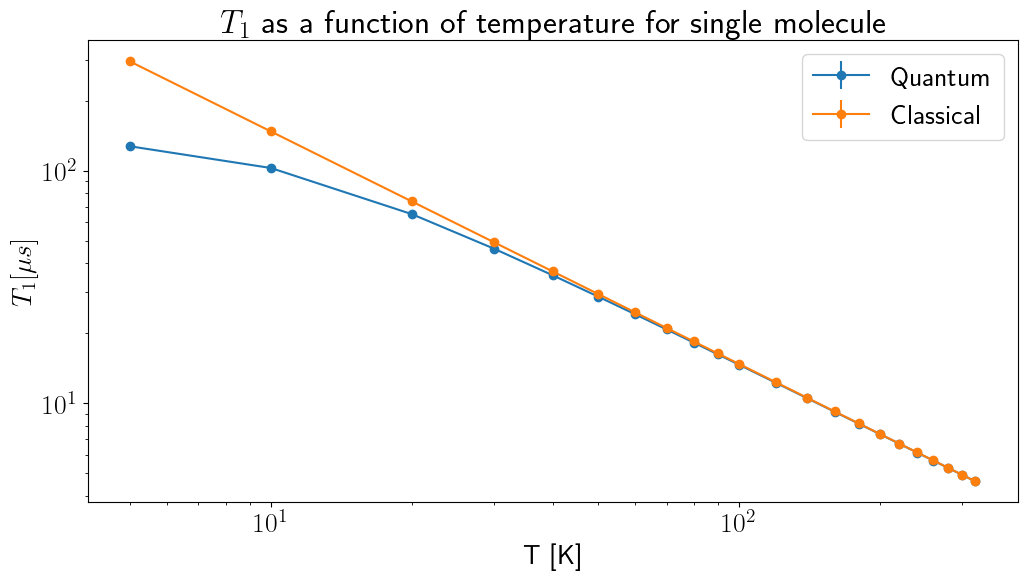

In [64]:
t1_list_quantum = np.load('saved variables/t1_list.npy')
t1d_list_quantum = np.load('saved variables/t1d_list.npy')
t1_list_classical = np.load('saved variables/t1_list_classical.npy')
t1d_list_classical = np.load('saved variables/t1d_list_classical.npy')
plt.figure(figsize=(12,6))
plt.errorbar(Temp_list, t1_list_quantum, yerr = t1d_list_quantum, fmt='-o')
plt.errorbar(Temp_list, t1_list_classical, yerr = t1d_list_classical, fmt='-o')
plt.xscale('log')
plt.yscale('log')
plt.title(r"$T_1$ as a function of temperature for single molecule")
plt.legend(['Quantum ', 'Classical'])
plt.xlabel('T [K]')
plt.ylabel(r"$T_1 [\mu s]$")


In [65]:
gcoupTest

NameError: name 'gcoupTest' is not defined

5
saturation value difference (-7.066451859916167e-05+0j)


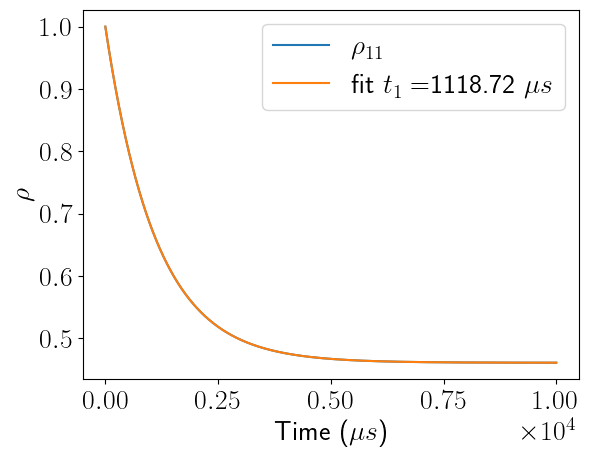

10
saturation value difference (-5.686635100754511e-06+0j)


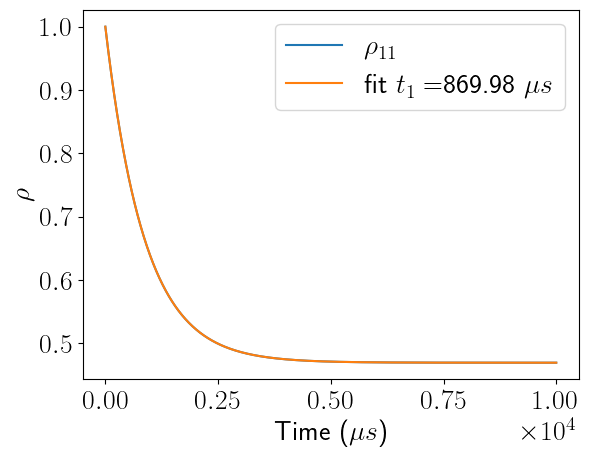

20
saturation value difference (-8.875438645139511e-07+0j)


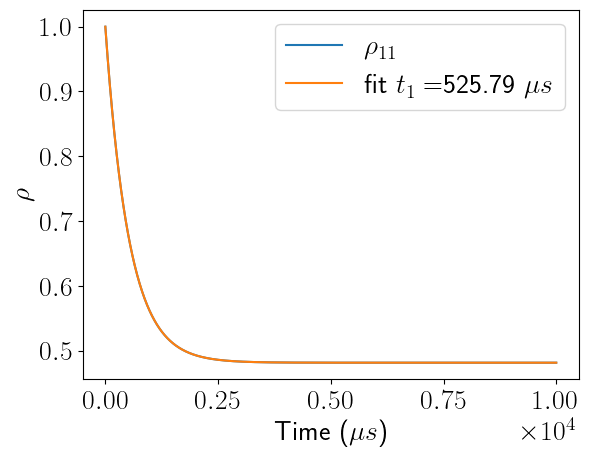

30
saturation value difference (-1.4747157772720954e-07+0j)


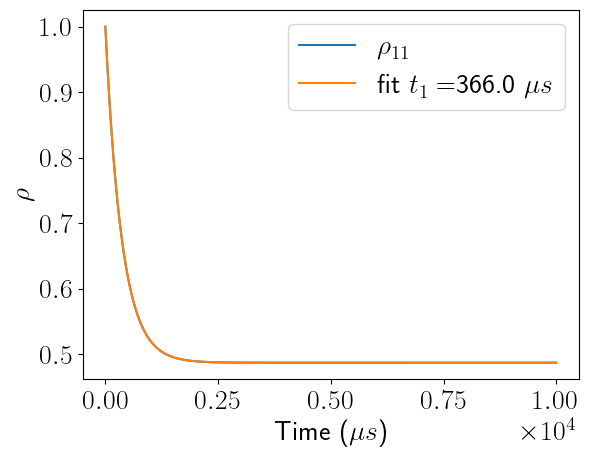

40
saturation value difference (5.953757803434101e-08+0j)


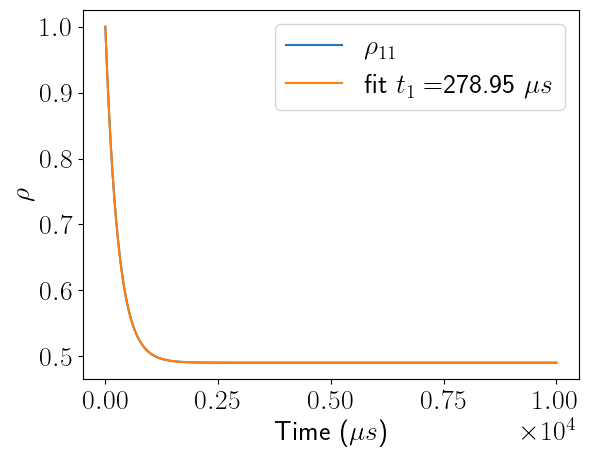

50
saturation value difference (9.888191532247959e-08+0j)


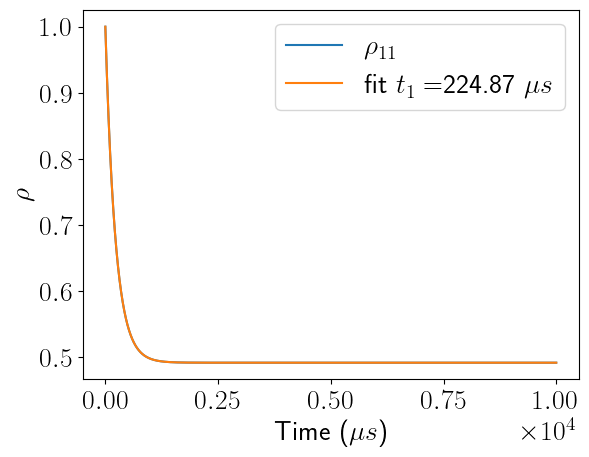

60
saturation value difference (4.033148426341171e-08+0j)


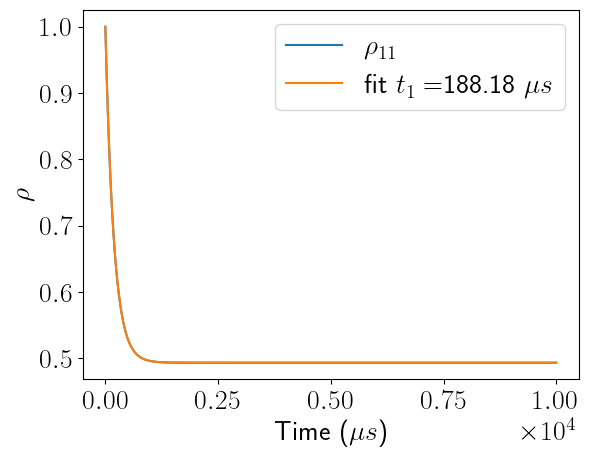

70
saturation value difference (6.98772635310263e-08+0j)


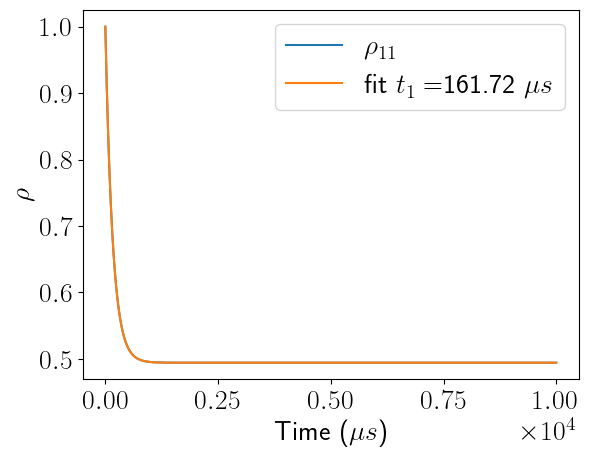

80
saturation value difference (3.972431622534245e-08+0j)


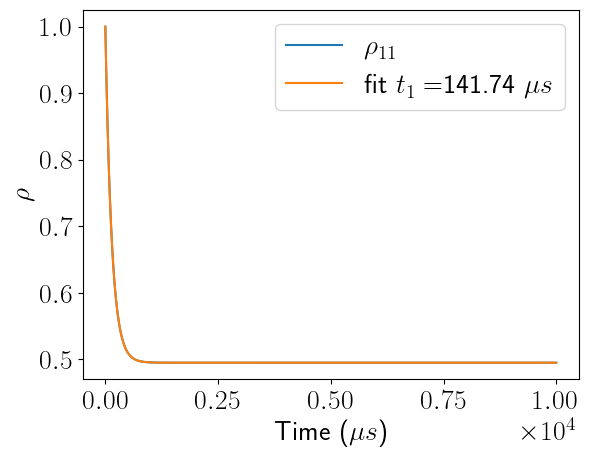

90
saturation value difference (3.582022845005639e-08+0j)


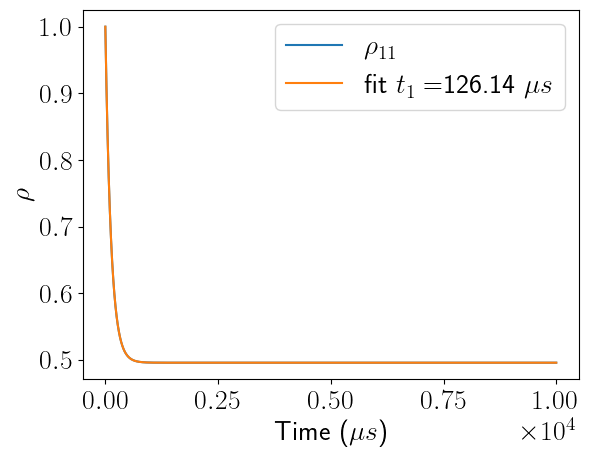

100
saturation value difference (9.550799207058702e-08+0j)


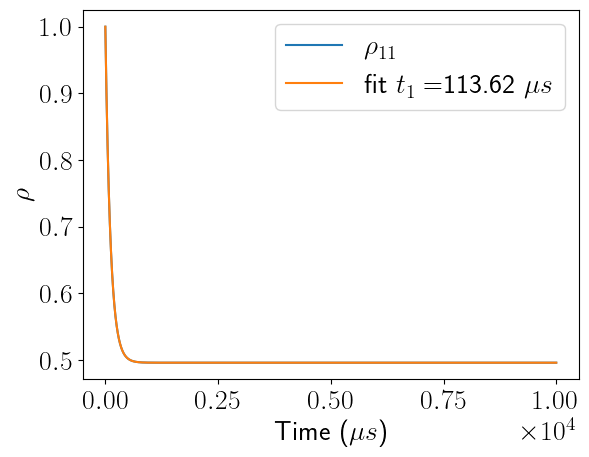

120
saturation value difference (2.2088201989678424e-08+0j)


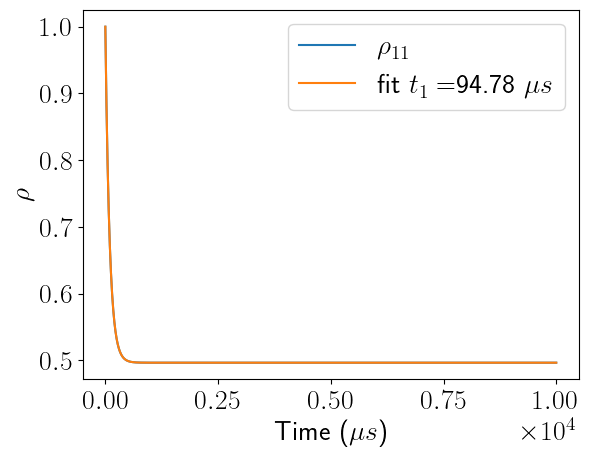

140
saturation value difference (8.215716051918065e-09+0j)


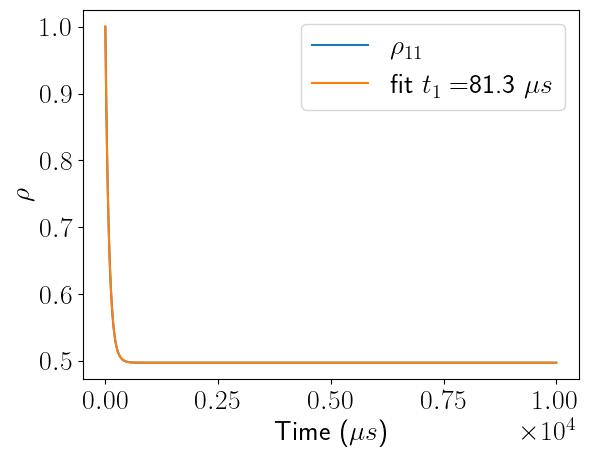

160
saturation value difference (2.2330275684101508e-08+0j)


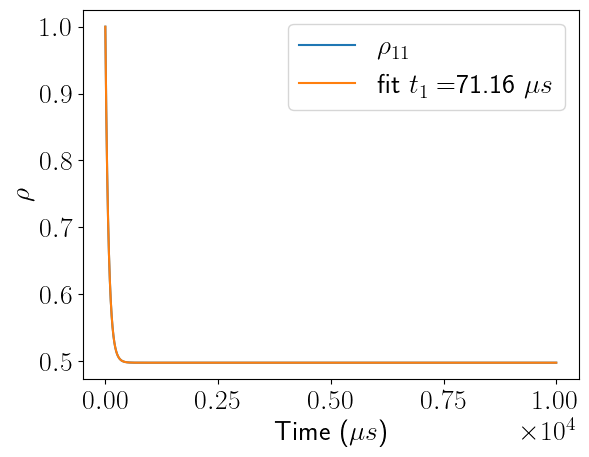

180
saturation value difference (6.166428989651251e-08+0j)


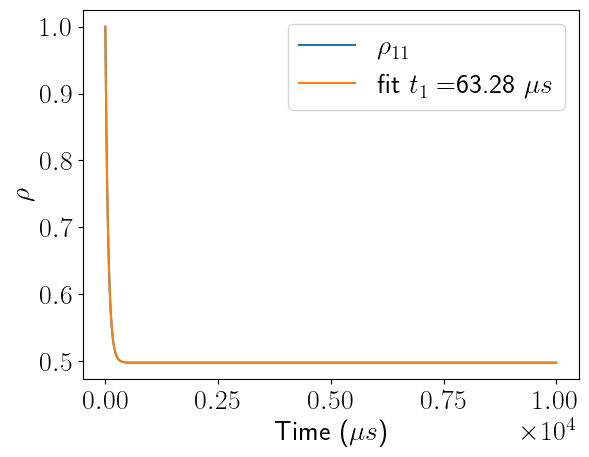

200
saturation value difference (3.370020157378306e-08+0j)


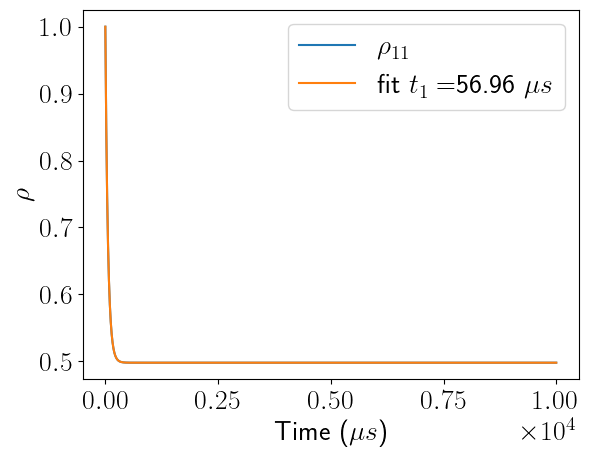

220
saturation value difference (-3.207623244794178e-08+0j)


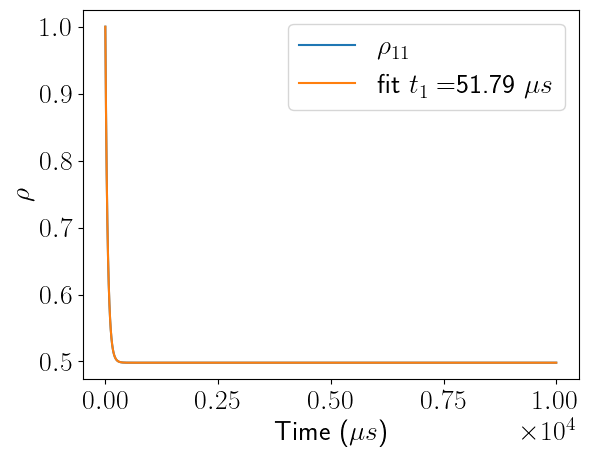

240
saturation value difference (2.8130348550536866e-08+0j)


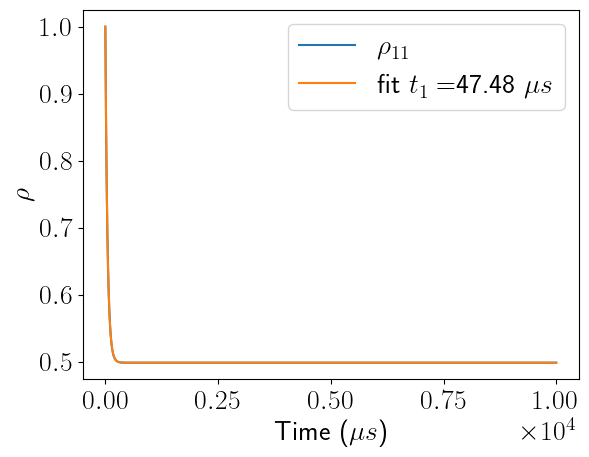

260
saturation value difference (4.4211248995118524e-08+0j)


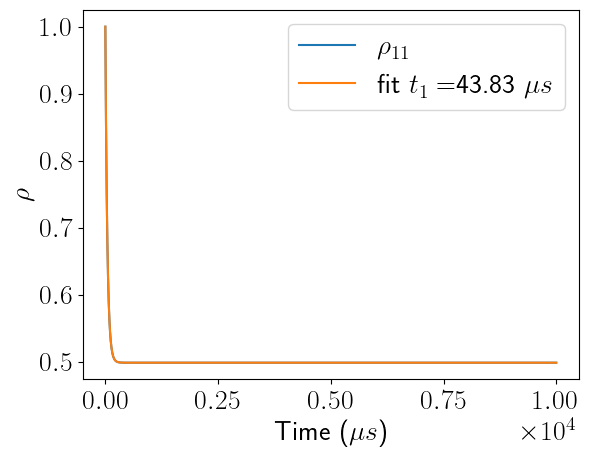

280
saturation value difference (-2.556815758558706e-07+0j)


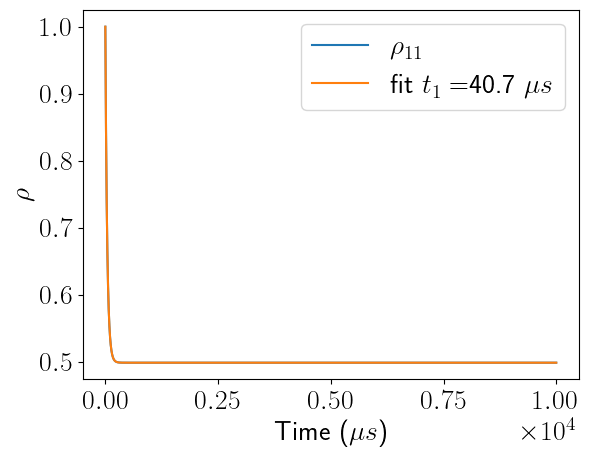

300
saturation value difference (4.394526098572271e-08+0j)


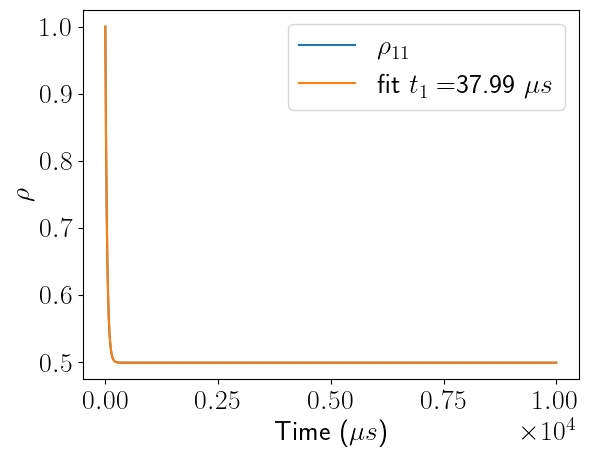

320
saturation value difference (4.7691644244896025e-08+0j)


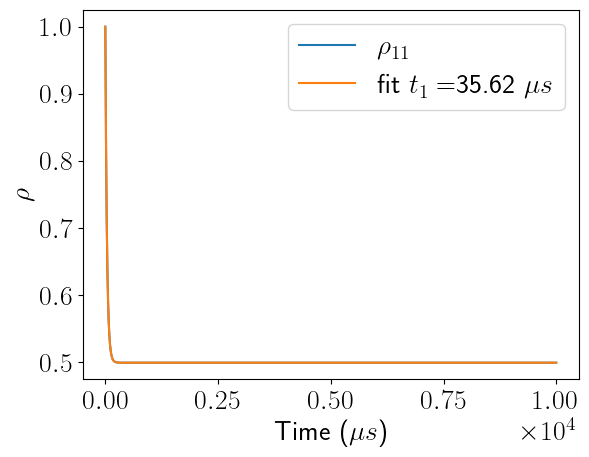

[1118.7236477   869.97984208  525.7872873   366.00393423  278.94834084
  224.87078528  188.18403784  161.71513605  141.73834243  126.13528331
  113.6159919    94.78277932   81.29574969   71.16419649   63.27564981
   56.96006718   51.78995381   47.47975893   43.83151417   40.70368321
   37.99235184   35.61955723]


In [66]:
# test 
gcoupTest = np.zeros((Np, 3),dtype=float) # defining a place holder for couplings
for k in range(Np):
    for j in range(3):
        gcoupTest[k,:] += alpha * dgx[k,:,j] * Bvector[j] * (1/2) * np.sqrt(hbar/(2*freq[k]/hbar))# only thing missing from here is Pauli matrix. Everything else is contained.
        #therefore, couplings will have units of energy as meV

# QUANTUM

t1_list_test = np.array([])
t1d_list_test = np.array([])

rho0 = basis(2,0)*basis(2,0).dag()
e_ops = []
rho_list = []

for k in range(len(Temp_list)):
    temp = Temp_list[k]
    print(temp)
    specDensityX = lambda w : spectral_density_quantum(w, freqs=freq, coup=gcoupTest[:,0], T=temp, sigma=2, shape='L')/hbar**2
    specDensityY = lambda w : spectral_density_quantum(w, freqs=freq, coup=gcoupTest[:,1], T=temp, sigma=2, shape='L')/hbar**2
    specDensityZ = lambda w : spectral_density_quantum(w, freqs=freq, coup=gcoupTest[:,2], T=temp, sigma=2, shape='L')/hbar**2
    aops = [[sigmax(),specDensityX], [sigmay(),specDensityY], [sigmaz(),specDensityZ]]
    
    results_k = brmesolve(H/(hbar), rho0, tlist, a_ops=aops, e_ops=e_ops)
    rho_list.append(results_k.states) # saving states for later
    rho11_k = np.array([results_k.states[j].full()[0,0] for j in range(len(tlist))]) # first element of rho vs time 


    fthermal, df = curve_fit(t1_func_thermal, tlist/1e6, np.abs(rho11_k))
    fclassical, df = curve_fit(t1_func_classical, tlist/1e6, np.abs(rho11_k))
    f, df = curve_fit(t1_func, tlist/1e6, np.abs(rho11_k))
    print('saturation value difference', f[1]-rho11_k[-1])
    t1, t1d = f[0], df[0,0]
    t1_list_test = np.append(t1_list_test, t1)
    t1d_list_test = np.append(t1d_list_test, t1d)
    ##########################################################################################################################
    ################## PLOTTING ################################################
    #fit_thermal = np.array([t1_func_classical(m, fthermal)  for m in tlist/1e6])
    #fit_classical = np.array([t1_func_classical(m, fclassical)  for m in tlist/1e6])
    fit_f = np.array([t1_func(m, f[0],f[1])  for m in tlist/1e6])
    plt.figure()
    plt.plot(tlist/1e6, np.abs(rho11_k))
    plt.plot(tlist/1e6, fit_f)
    #plt.plot(tlist/1e6, fit_thermal)
    plt.xlabel(r"Time ($\mu s$)")
    plt.ylabel(r"$\rho$")
    plt.legend([r"$\rho_{11}$", r"fit $t_1 = $"+str(np.round(f,2)[0])+r"$\ \mu s$", r"fit_thermal $t_1 = $"+str(np.round(fthermal,2)[0])+r"$\ \mu s$"])
    plt.show()
    ############################################################################################################################
#np.save('saved variables/t1_list_test', t1_list_test)
#np.save('saved variables/t1d_list_test', t1d_list_test)
print(t1_list_test) 

In [67]:
print(np.load('saved variables/t1_list.npy'))

[127.16040333 102.5430231   64.94536042  46.07117922  35.42892798
  28.70145065  24.09100883  20.74323741  18.20558043  16.21740304
  14.61852519  12.20761916  10.47726811   9.1755132    8.16091462
   7.34802424   6.6822006    6.12688267   5.65669649   5.25346895
   4.90386273   4.59785276]


In [68]:
# testing t1 dynamics at 0.345 T
# Defining External magnetic field vector

B345 = np.zeros(3)
B345[0] = 0
B345[1] = 0
B345[2] = 0.345

# Defining spin Hamiltonian
H345 = None

# 1) Zeeman interaction
for i in range(3):
    for j in range(3):
        if H345 is None:
            H345 = alpha * gtensor[i][j] *(1/2)* sigma_vec[i] * B345[j] # notice this 1/2 here. its because i am using pauli matrices 
        else:
            H345 += alpha * gtensor[i][j] *(1/2)* sigma_vec[i] * B345[j]# instead of spin 1/2 matrices 

H345

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[ 1.98721340e-02+0.0000000e+00j  2.20200012e-05+8.8377559e-06j]
 [ 2.20200012e-05-8.8377559e-06j -1.98721340e-02+0.0000000e+00j]]

#### Running simulation

5
10.0%. Run time:   6.65s. Est. time left: 00:00:00:59
20.0%. Run time:  13.70s. Est. time left: 00:00:00:54
30.0%. Run time:  20.77s. Est. time left: 00:00:00:48
40.0%. Run time:  27.88s. Est. time left: 00:00:00:41
50.0%. Run time:  34.94s. Est. time left: 00:00:00:34
60.0%. Run time:  42.00s. Est. time left: 00:00:00:28
70.0%. Run time:  49.06s. Est. time left: 00:00:00:21
80.0%. Run time:  56.16s. Est. time left: 00:00:00:14
90.0%. Run time:  63.51s. Est. time left: 00:00:00:07
Total run time:  71.16s
saturation value difference (-0.45829988609302674+0j)


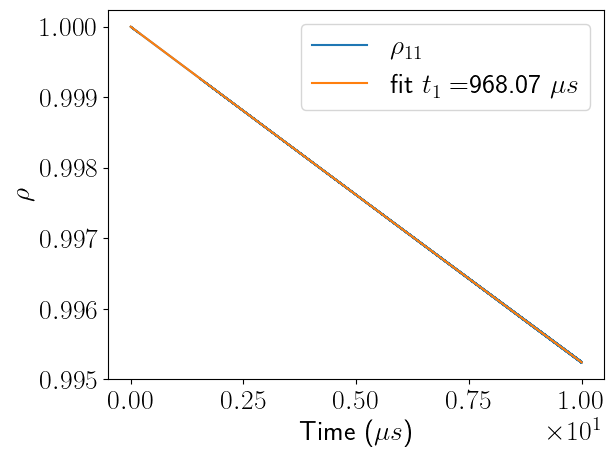

10
10.0%. Run time:   6.67s. Est. time left: 00:00:01:00
20.0%. Run time:  13.60s. Est. time left: 00:00:00:54
30.0%. Run time:  20.86s. Est. time left: 00:00:00:48
40.0%. Run time:  28.12s. Est. time left: 00:00:00:42
50.0%. Run time:  35.41s. Est. time left: 00:00:00:35
60.0%. Run time:  42.63s. Est. time left: 00:00:00:28
70.0%. Run time:  49.81s. Est. time left: 00:00:00:21
80.0%. Run time:  57.02s. Est. time left: 00:00:00:14
90.0%. Run time:  64.57s. Est. time left: 00:00:00:07
Total run time:  71.83s
saturation value difference (-0.4709567835324454+0j)


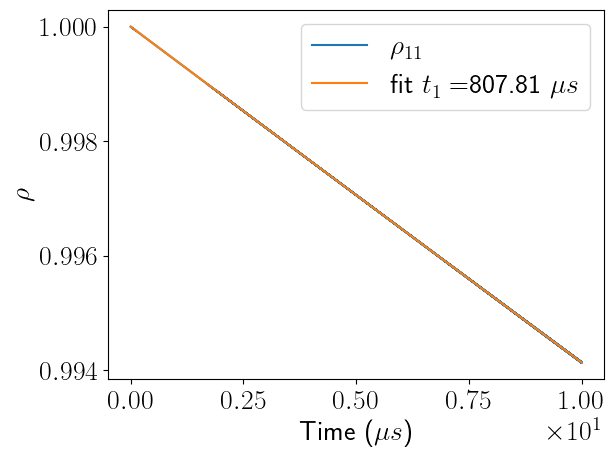

20
10.0%. Run time:   6.62s. Est. time left: 00:00:00:59
20.0%. Run time:  13.51s. Est. time left: 00:00:00:54
30.0%. Run time:  20.57s. Est. time left: 00:00:00:47
40.0%. Run time:  27.87s. Est. time left: 00:00:00:41
50.0%. Run time:  35.19s. Est. time left: 00:00:00:35
60.0%. Run time:  42.54s. Est. time left: 00:00:00:28
70.0%. Run time:  49.86s. Est. time left: 00:00:00:21
80.0%. Run time:  57.18s. Est. time left: 00:00:00:14
90.0%. Run time:  64.55s. Est. time left: 00:00:00:07
Total run time:  71.89s
saturation value difference (-0.48336843380754524+0j)


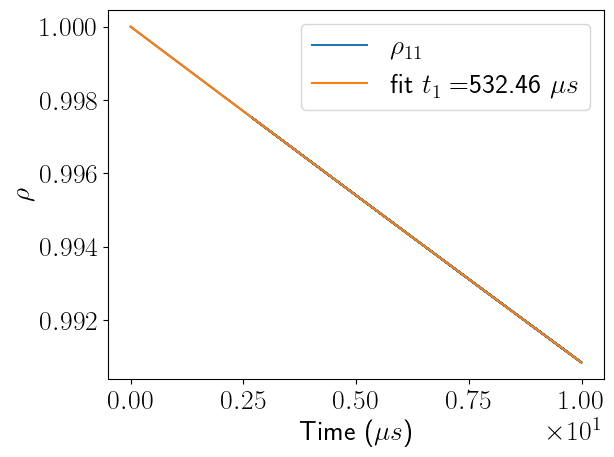

30
10.0%. Run time:   7.12s. Est. time left: 00:00:01:04
20.0%. Run time:  13.97s. Est. time left: 00:00:00:55
30.0%. Run time:  21.08s. Est. time left: 00:00:00:49
40.0%. Run time:  28.39s. Est. time left: 00:00:00:42
50.0%. Run time:  35.68s. Est. time left: 00:00:00:35
60.0%. Run time:  42.98s. Est. time left: 00:00:00:28
70.0%. Run time:  50.28s. Est. time left: 00:00:00:21
80.0%. Run time:  57.66s. Est. time left: 00:00:00:14
90.0%. Run time:  64.91s. Est. time left: 00:00:00:07
Total run time:  72.18s
saturation value difference (-0.48463894484257986+0j)


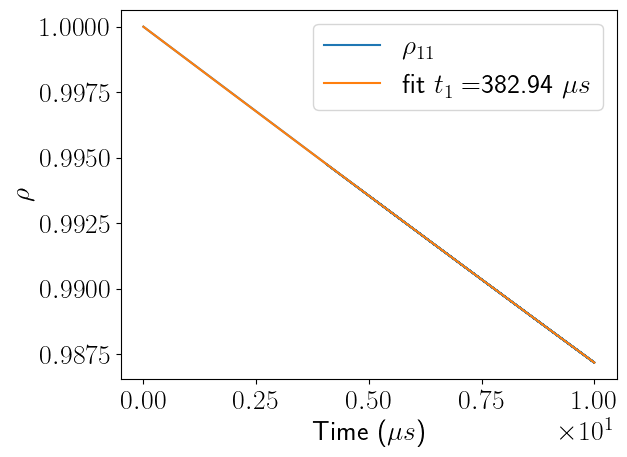

40
10.0%. Run time:   6.63s. Est. time left: 00:00:00:59
20.0%. Run time:  13.54s. Est. time left: 00:00:00:54
30.0%. Run time:  20.58s. Est. time left: 00:00:00:48
40.0%. Run time:  27.92s. Est. time left: 00:00:00:41
50.0%. Run time:  35.25s. Est. time left: 00:00:00:35
60.0%. Run time:  43.21s. Est. time left: 00:00:00:28
70.0%. Run time:  50.61s. Est. time left: 00:00:00:21
80.0%. Run time:  57.95s. Est. time left: 00:00:00:14
90.0%. Run time:  65.28s. Est. time left: 00:00:00:07
Total run time:  72.65s
saturation value difference (-0.4827009536359196+0j)


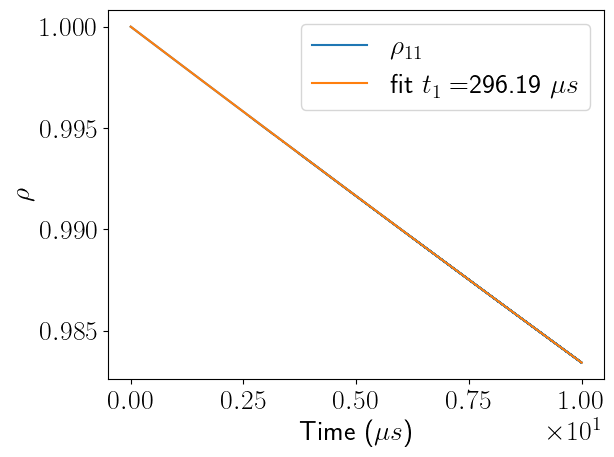

50
10.0%. Run time:   6.66s. Est. time left: 00:00:00:59
20.0%. Run time:  13.23s. Est. time left: 00:00:00:52
30.0%. Run time:  19.76s. Est. time left: 00:00:00:46
40.0%. Run time:  26.34s. Est. time left: 00:00:00:39
50.0%. Run time:  33.00s. Est. time left: 00:00:00:32
60.0%. Run time:  39.56s. Est. time left: 00:00:00:26
70.0%. Run time:  46.12s. Est. time left: 00:00:00:19
80.0%. Run time:  52.67s. Est. time left: 00:00:00:13
90.0%. Run time:  59.21s. Est. time left: 00:00:00:06
Total run time:  65.75s
saturation value difference (-0.4796950673007933+0j)


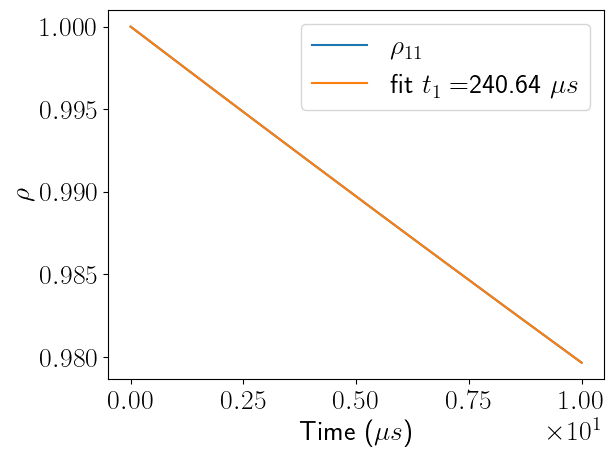

60
10.0%. Run time:   6.70s. Est. time left: 00:00:01:00
20.0%. Run time:  13.69s. Est. time left: 00:00:00:54
30.0%. Run time:  20.79s. Est. time left: 00:00:00:48
40.0%. Run time:  28.65s. Est. time left: 00:00:00:42
50.0%. Run time:  36.01s. Est. time left: 00:00:00:36
60.0%. Run time:  43.45s. Est. time left: 00:00:00:28
70.0%. Run time:  50.89s. Est. time left: 00:00:00:21
80.0%. Run time:  58.39s. Est. time left: 00:00:00:14
90.0%. Run time:  65.85s. Est. time left: 00:00:00:07
Total run time:  73.31s
saturation value difference (-0.4762826406576163+0j)


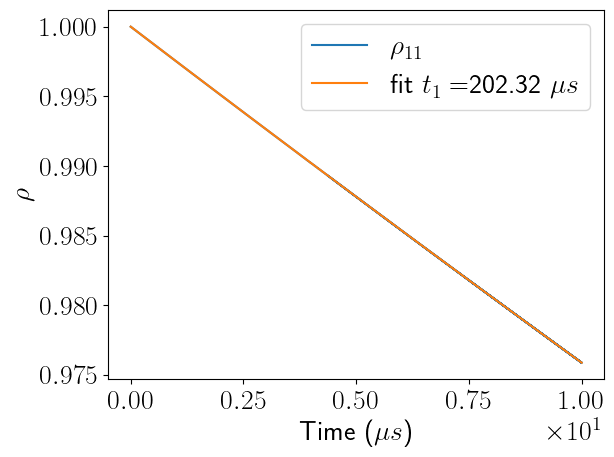

70
10.0%. Run time:   6.57s. Est. time left: 00:00:00:59
20.0%. Run time:  13.36s. Est. time left: 00:00:00:53
30.0%. Run time:  20.48s. Est. time left: 00:00:00:47
40.0%. Run time:  27.67s. Est. time left: 00:00:00:41
50.0%. Run time:  34.81s. Est. time left: 00:00:00:34
60.0%. Run time:  41.90s. Est. time left: 00:00:00:27
70.0%. Run time:  49.13s. Est. time left: 00:00:00:21
80.0%. Run time:  56.26s. Est. time left: 00:00:00:14
90.0%. Run time:  63.39s. Est. time left: 00:00:00:07
Total run time:  70.67s
saturation value difference (-0.4726846134920895+0j)


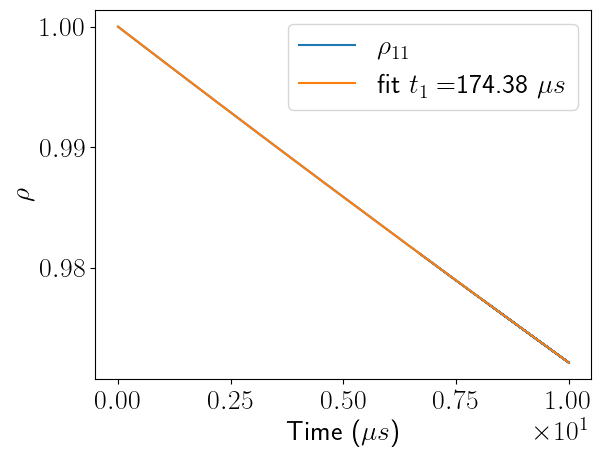

80
10.0%. Run time:   6.65s. Est. time left: 00:00:00:59
20.0%. Run time:  13.53s. Est. time left: 00:00:00:54
30.0%. Run time:  20.55s. Est. time left: 00:00:00:47
40.0%. Run time:  27.58s. Est. time left: 00:00:00:41
50.0%. Run time:  34.81s. Est. time left: 00:00:00:34
60.0%. Run time:  42.34s. Est. time left: 00:00:00:28
70.0%. Run time:  50.84s. Est. time left: 00:00:00:21
80.0%. Run time:  58.34s. Est. time left: 00:00:00:14
90.0%. Run time:  65.85s. Est. time left: 00:00:00:07
Total run time:  73.33s
saturation value difference (-0.46902620557126157+0j)


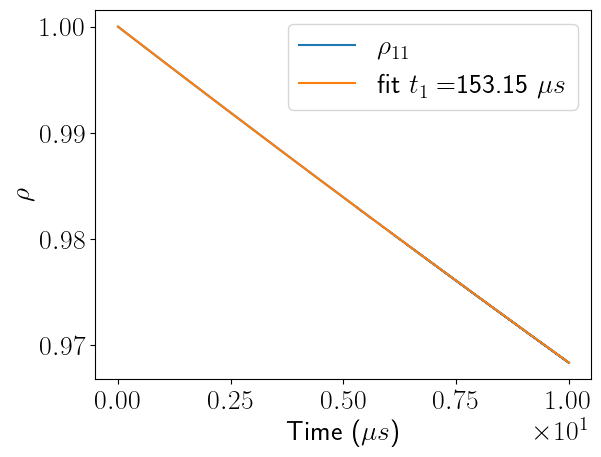

90
10.0%. Run time:   6.68s. Est. time left: 00:00:01:00
20.0%. Run time:  13.59s. Est. time left: 00:00:00:54
30.0%. Run time:  20.69s. Est. time left: 00:00:00:48
40.0%. Run time:  28.02s. Est. time left: 00:00:00:42
50.0%. Run time:  35.34s. Est. time left: 00:00:00:35
60.0%. Run time:  42.69s. Est. time left: 00:00:00:28
70.0%. Run time:  49.99s. Est. time left: 00:00:00:21
80.0%. Run time:  57.29s. Est. time left: 00:00:00:14
90.0%. Run time:  64.60s. Est. time left: 00:00:00:07
Total run time:  71.94s
saturation value difference (-0.4653302982496698+0j)


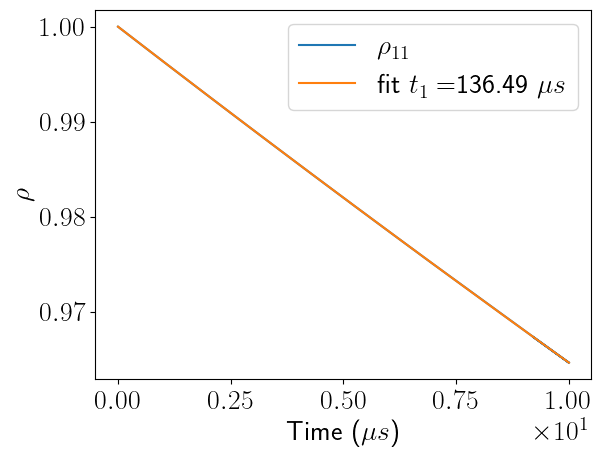

100
10.0%. Run time:   6.68s. Est. time left: 00:00:01:00
20.0%. Run time:  13.63s. Est. time left: 00:00:00:54
30.0%. Run time:  20.70s. Est. time left: 00:00:00:48
40.0%. Run time:  27.73s. Est. time left: 00:00:00:41
50.0%. Run time:  34.91s. Est. time left: 00:00:00:34
60.0%. Run time:  42.50s. Est. time left: 00:00:00:28
70.0%. Run time:  50.00s. Est. time left: 00:00:00:21
80.0%. Run time:  57.48s. Est. time left: 00:00:00:14
90.0%. Run time:  64.99s. Est. time left: 00:00:00:07
Total run time:  72.51s
saturation value difference (-0.4616425338814707+0j)


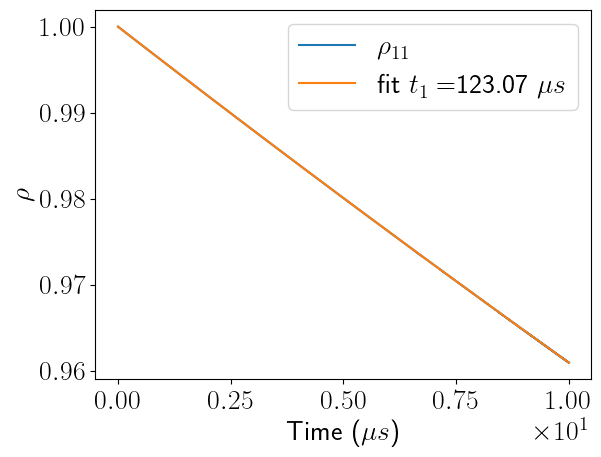

120
10.0%. Run time:   6.68s. Est. time left: 00:00:01:00
20.0%. Run time:  13.59s. Est. time left: 00:00:00:54
30.0%. Run time:  20.68s. Est. time left: 00:00:00:48
40.0%. Run time:  27.77s. Est. time left: 00:00:00:41
50.0%. Run time:  34.83s. Est. time left: 00:00:00:34
60.0%. Run time:  43.69s. Est. time left: 00:00:00:29
70.0%. Run time:  51.19s. Est. time left: 00:00:00:21
80.0%. Run time:  58.69s. Est. time left: 00:00:00:14
90.0%. Run time:  66.24s. Est. time left: 00:00:00:07
Total run time:  73.76s
saturation value difference (-0.4542966514462494+0j)


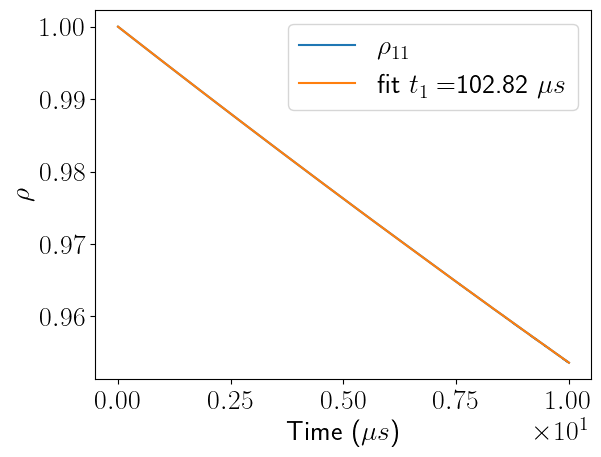

140
10.0%. Run time:   6.60s. Est. time left: 00:00:00:59
20.0%. Run time:  13.50s. Est. time left: 00:00:00:54
30.0%. Run time:  20.68s. Est. time left: 00:00:00:48
40.0%. Run time:  27.85s. Est. time left: 00:00:00:41
50.0%. Run time:  35.11s. Est. time left: 00:00:00:35
60.0%. Run time:  42.29s. Est. time left: 00:00:00:28
70.0%. Run time:  49.49s. Est. time left: 00:00:00:21
80.0%. Run time:  56.66s. Est. time left: 00:00:00:14
90.0%. Run time:  63.90s. Est. time left: 00:00:00:07
Total run time:  71.23s
saturation value difference (-0.447039381391118+0j)


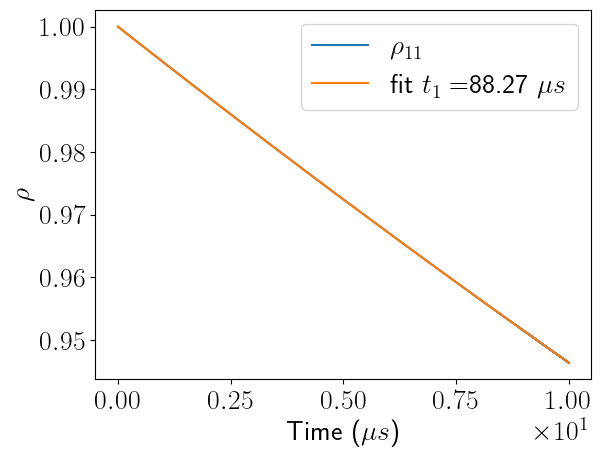

160
10.0%. Run time:   6.61s. Est. time left: 00:00:00:59
20.0%. Run time:  13.56s. Est. time left: 00:00:00:54
30.0%. Run time:  20.71s. Est. time left: 00:00:00:48
40.0%. Run time:  27.79s. Est. time left: 00:00:00:41
50.0%. Run time:  34.87s. Est. time left: 00:00:00:34
60.0%. Run time:  41.98s. Est. time left: 00:00:00:27
70.0%. Run time:  49.49s. Est. time left: 00:00:00:21
80.0%. Run time:  57.07s. Est. time left: 00:00:00:14
90.0%. Run time:  64.72s. Est. time left: 00:00:00:07
Total run time:  72.26s
saturation value difference (-0.43987620564754104+0j)


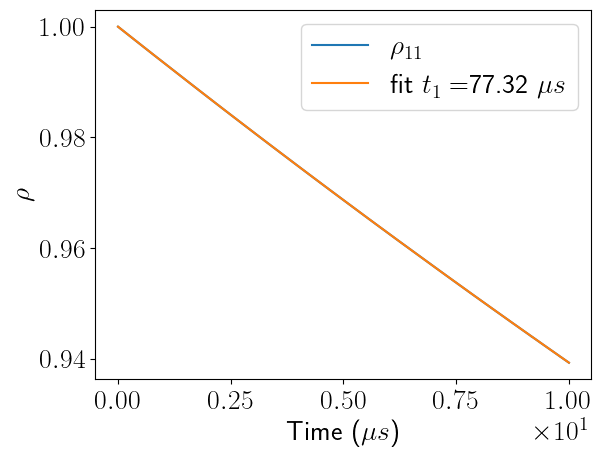

180
10.0%. Run time:   6.65s. Est. time left: 00:00:00:59
20.0%. Run time:  13.54s. Est. time left: 00:00:00:54
30.0%. Run time:  20.48s. Est. time left: 00:00:00:47
40.0%. Run time:  27.61s. Est. time left: 00:00:00:41
50.0%. Run time:  34.96s. Est. time left: 00:00:00:34
60.0%. Run time:  42.39s. Est. time left: 00:00:00:28
70.0%. Run time:  49.78s. Est. time left: 00:00:00:21
80.0%. Run time:  57.18s. Est. time left: 00:00:00:14
90.0%. Run time:  64.63s. Est. time left: 00:00:00:07
Total run time:  72.03s
saturation value difference (-0.4328398844921436+0j)


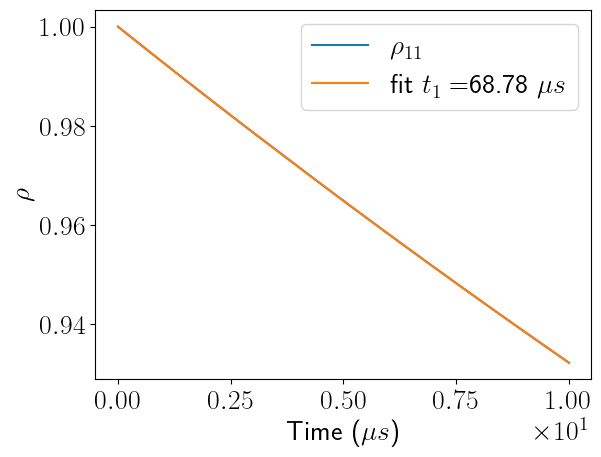

200
10.0%. Run time:   6.65s. Est. time left: 00:00:00:59
20.0%. Run time:  15.42s. Est. time left: 00:00:01:01
30.0%. Run time:  22.62s. Est. time left: 00:00:00:52
40.0%. Run time:  29.80s. Est. time left: 00:00:00:44
50.0%. Run time:  37.00s. Est. time left: 00:00:00:37
60.0%. Run time:  44.19s. Est. time left: 00:00:00:29
70.0%. Run time:  51.40s. Est. time left: 00:00:00:22
80.0%. Run time:  58.60s. Est. time left: 00:00:00:14
90.0%. Run time:  65.79s. Est. time left: 00:00:00:07
Total run time:  72.98s
saturation value difference (-0.42591035355935014+0j)


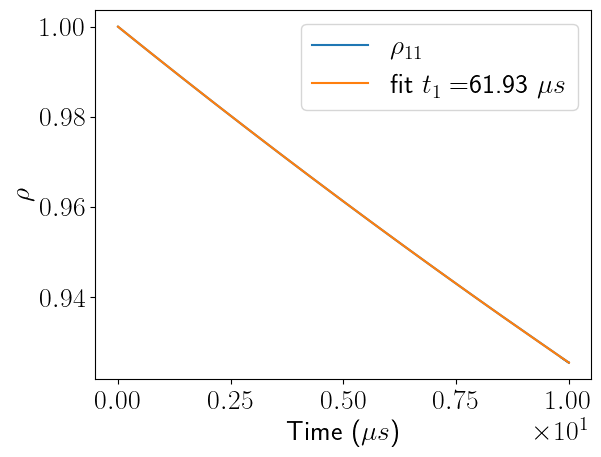

220
10.0%. Run time:   6.74s. Est. time left: 00:00:01:00
20.0%. Run time:  13.70s. Est. time left: 00:00:00:54
30.0%. Run time:  20.97s. Est. time left: 00:00:00:48
40.0%. Run time:  28.19s. Est. time left: 00:00:00:42
50.0%. Run time:  35.42s. Est. time left: 00:00:00:35
60.0%. Run time:  42.64s. Est. time left: 00:00:00:28
70.0%. Run time:  49.94s. Est. time left: 00:00:00:21
80.0%. Run time:  57.15s. Est. time left: 00:00:00:14
90.0%. Run time:  64.64s. Est. time left: 00:00:00:07
Total run time:  72.39s
saturation value difference (-0.4190888813162296+0j)


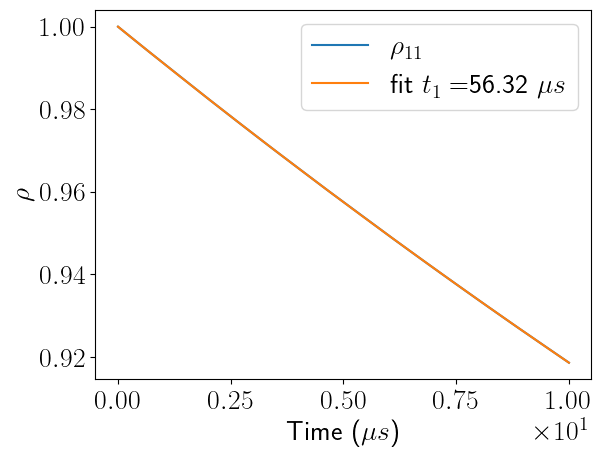

240
10.0%. Run time:   6.72s. Est. time left: 00:00:01:00
20.0%. Run time:  13.60s. Est. time left: 00:00:00:54
30.0%. Run time:  20.99s. Est. time left: 00:00:00:48
40.0%. Run time:  28.37s. Est. time left: 00:00:00:42
50.0%. Run time:  35.54s. Est. time left: 00:00:00:35
60.0%. Run time:  42.90s. Est. time left: 00:00:00:28
70.0%. Run time:  50.30s. Est. time left: 00:00:00:21
80.0%. Run time:  57.56s. Est. time left: 00:00:00:14
90.0%. Run time:  64.82s. Est. time left: 00:00:00:07
Total run time:  72.14s
saturation value difference (-0.4123751859088219+0j)


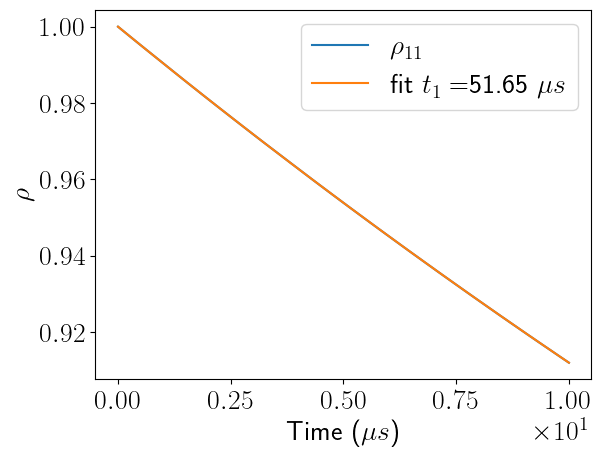

260
10.0%. Run time:   6.79s. Est. time left: 00:00:01:01
20.0%. Run time:  13.67s. Est. time left: 00:00:00:54
30.0%. Run time:  21.14s. Est. time left: 00:00:00:49
40.0%. Run time:  28.67s. Est. time left: 00:00:00:43
50.0%. Run time:  35.94s. Est. time left: 00:00:00:35
60.0%. Run time:  43.42s. Est. time left: 00:00:00:28
70.0%. Run time:  50.94s. Est. time left: 00:00:00:21
80.0%. Run time:  58.20s. Est. time left: 00:00:00:14
90.0%. Run time:  65.66s. Est. time left: 00:00:00:07
Total run time:  73.16s
saturation value difference (-0.40577056385988186+0j)


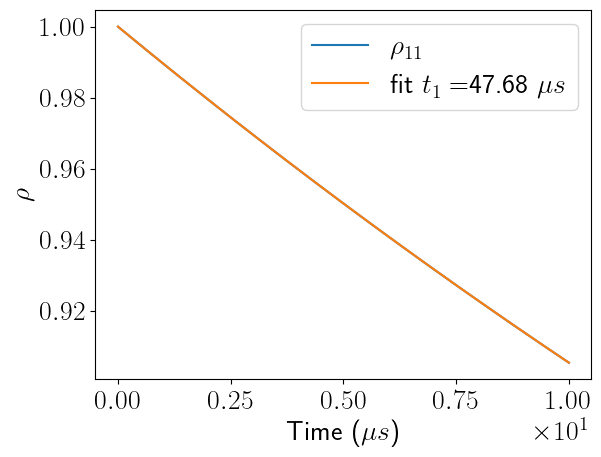

280
10.0%. Run time:   6.76s. Est. time left: 00:00:01:00
20.0%. Run time:  13.54s. Est. time left: 00:00:00:54
30.0%. Run time:  20.71s. Est. time left: 00:00:00:48
40.0%. Run time:  28.19s. Est. time left: 00:00:00:42
50.0%. Run time:  35.40s. Est. time left: 00:00:00:35
60.0%. Run time:  42.67s. Est. time left: 00:00:00:28
70.0%. Run time:  52.32s. Est. time left: 00:00:00:22
80.0%. Run time:  59.52s. Est. time left: 00:00:00:14
90.0%. Run time:  66.73s. Est. time left: 00:00:00:07
Total run time:  74.17s
saturation value difference (-0.3992736037949804+0j)


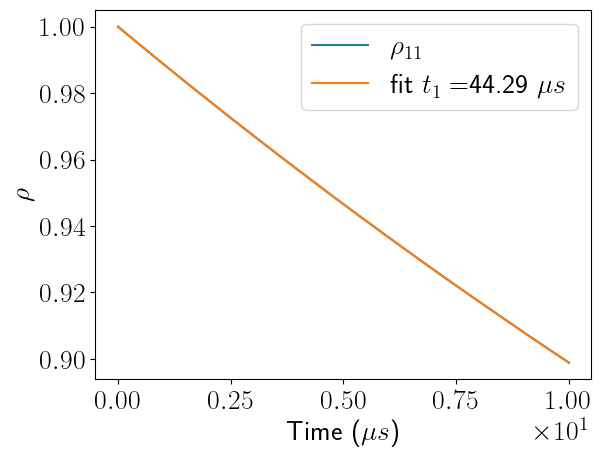

300
10.0%. Run time:   6.66s. Est. time left: 00:00:00:59
20.0%. Run time:  13.74s. Est. time left: 00:00:00:54
30.0%. Run time:  20.97s. Est. time left: 00:00:00:48
40.0%. Run time:  28.17s. Est. time left: 00:00:00:42
50.0%. Run time:  35.60s. Est. time left: 00:00:00:35
60.0%. Run time:  42.82s. Est. time left: 00:00:00:28
70.0%. Run time:  50.05s. Est. time left: 00:00:00:21
80.0%. Run time:  57.26s. Est. time left: 00:00:00:14
90.0%. Run time:  64.44s. Est. time left: 00:00:00:07
Total run time:  71.68s
saturation value difference (-0.392889037391717+0j)


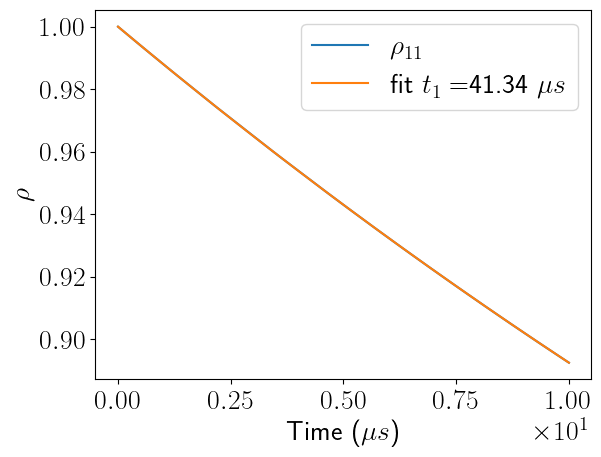

320
10.0%. Run time:   6.69s. Est. time left: 00:00:01:00
20.0%. Run time:  13.70s. Est. time left: 00:00:00:54
30.0%. Run time:  20.93s. Est. time left: 00:00:00:48
40.0%. Run time:  28.10s. Est. time left: 00:00:00:42
50.0%. Run time:  35.28s. Est. time left: 00:00:00:35
60.0%. Run time:  42.47s. Est. time left: 00:00:00:28
70.0%. Run time:  49.71s. Est. time left: 00:00:00:21
80.0%. Run time:  56.88s. Est. time left: 00:00:00:14
90.0%. Run time:  64.57s. Est. time left: 00:00:00:07
Total run time:  72.21s
saturation value difference (-0.3865959704607795+0j)


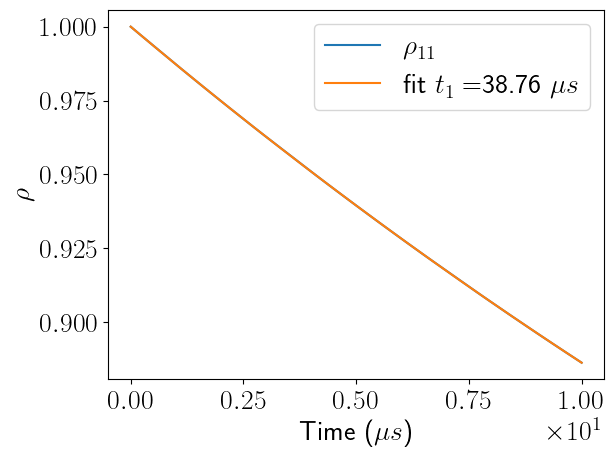

[968.06902883 807.81282221 532.45512621 382.94105132 296.18808393
 240.64036644 202.31877924 174.37972131 153.15071217 136.48972491
 123.0744574  102.82251508  88.27189086  77.31825372  68.77705899
  61.93171781  56.32360619  51.64545836  47.68394704  44.28626452
  41.34015042  38.76123173]


In [69]:
# QUANTUM
tlist = np.linspace(1, 10e6, 100000) # in ps
t1_list_345mT = np.array([])
t1d_list_345mT = np.array([])

rho0 = basis(2,0)*basis(2,0).dag()
e_ops = []
rho_list = []
options=Options()
options.nsteps=5000

for k in range(len(Temp_list)):
    temp = Temp_list[k]
    print(temp)
    specDensityX = lambda w : spectral_density_quantum(w, freqs=freq, coup=gcoupS[:,0]*0.345, T=temp, sigma=2)/hbar**2
    specDensityY = lambda w : spectral_density_quantum(w, freqs=freq, coup=gcoupS[:,1]*0.345, T=temp, sigma=2)/hbar**2
    specDensityZ = lambda w : spectral_density_quantum(w, freqs=freq, coup=gcoupS[:,2]*0.345, T=temp, sigma=2)/hbar**2
    aops = [[sigmax(),specDensityX], [sigmay(),specDensityY], [sigmaz(),specDensityZ]]
    
    results_k = brmesolve(H345/(hbar), rho0, tlist, a_ops=aops, e_ops=e_ops, progress_bar = True)
    rho_list.append(results_k.states) # saving states for later
    rho11_k = np.array([results_k.states[j].full()[0,0] for j in range(len(tlist))]) # first element of rho vs time 
    

    #f, df = curve_fit(t1_func_thermal, tlist/1e6, np.abs(rho11_k))
    #f, df = curve_fit(t1_func_classical, tlist/1e6, np.abs(rho11_k))
    f, df = curve_fit(t1_func, tlist/1e6, np.abs(rho11_k))
    print('saturation value difference', f[1]-rho11_k[-1])
    t1, t1d = f[0], df[0,0]
    #t1, t1d = f, df
    t1_list_345mT = np.append(t1_list_345mT, t1)
    t1d_list_345mT = np.append(t1d_list_345mT, t1d)
    ##########################################################################################################################
    ################## PLOTTING ################################################
    #fit = np.array([t1_func_classical(m, f)  for m in tlist/1e6])
    #fit = np.array([t1_func_classical(m, f)  for m in tlist/1e6])
    fit = np.array([t1_func(m, f[0],f[1])  for m in tlist/1e6])
    plt.figure()
    plt.plot(tlist/1e6, np.abs(rho11_k))
    plt.plot(tlist/1e6, fit)
    #plt.plot(tlist/1e6, fit_thermal)
    plt.xlabel(r"Time ($\mu s$)")
    plt.ylabel(r"$\rho$")
    plt.legend([r"$\rho_{11}$", r"fit $t_1 = $"+str(np.round(f,2)[0])+r"$\ \mu s$", r"fit_thermal $t_1 = $"+str(np.round(fthermal,2)[0])+r"$\ \mu s$"])
    plt.show()
    ############################################################################################################################
np.save('saved variables/t1_list_345mT', t1_list_345mT)
np.save('saved variables/t1d_list_345mT', t1d_list_345mT)
print(t1_list_345mT)  

5
10.0%. Run time:   6.68s. Est. time left: 00:00:01:00
20.0%. Run time:  13.71s. Est. time left: 00:00:00:54
30.0%. Run time:  20.87s. Est. time left: 00:00:00:48
40.0%. Run time:  28.02s. Est. time left: 00:00:00:42
50.0%. Run time:  35.21s. Est. time left: 00:00:00:35
60.0%. Run time:  42.42s. Est. time left: 00:00:00:28
70.0%. Run time:  49.60s. Est. time left: 00:00:00:21
80.0%. Run time:  56.80s. Est. time left: 00:00:00:14
90.0%. Run time:  64.22s. Est. time left: 00:00:00:07
Total run time:  71.91s


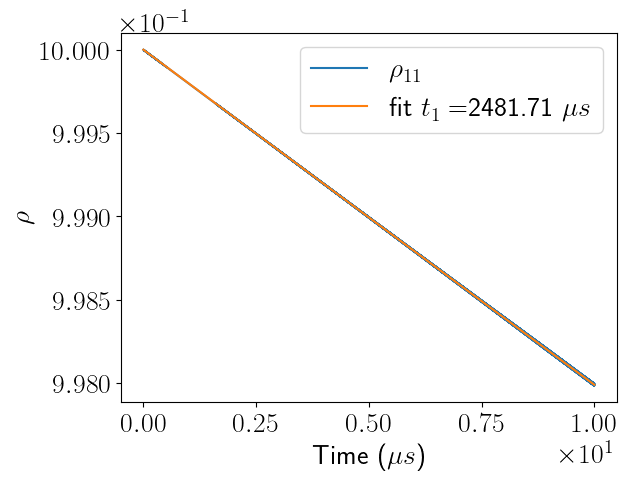

10
10.0%. Run time:   6.68s. Est. time left: 00:00:01:00
20.0%. Run time:  13.68s. Est. time left: 00:00:00:54
30.0%. Run time:  20.64s. Est. time left: 00:00:00:48
40.0%. Run time:  27.98s. Est. time left: 00:00:00:41
50.0%. Run time:  35.35s. Est. time left: 00:00:00:35
60.0%. Run time:  42.70s. Est. time left: 00:00:00:28
70.0%. Run time:  50.11s. Est. time left: 00:00:00:21
80.0%. Run time:  57.52s. Est. time left: 00:00:00:14
90.0%. Run time:  64.87s. Est. time left: 00:00:00:07
Total run time:  72.29s


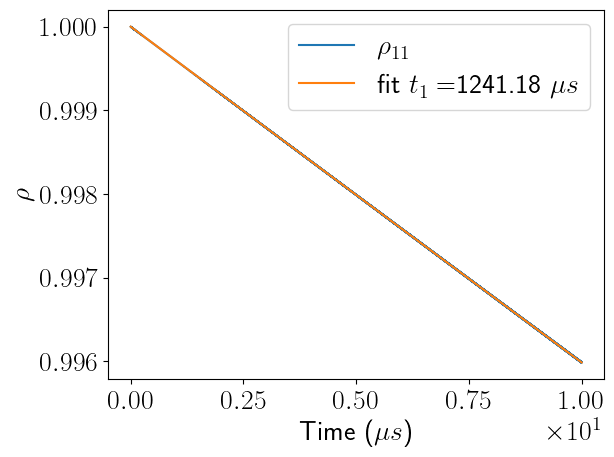

20
10.0%. Run time:   6.58s. Est. time left: 00:00:00:59
20.0%. Run time:  13.44s. Est. time left: 00:00:00:53
30.0%. Run time:  20.54s. Est. time left: 00:00:00:47
40.0%. Run time:  27.80s. Est. time left: 00:00:00:41
50.0%. Run time:  35.10s. Est. time left: 00:00:00:35
60.0%. Run time:  42.44s. Est. time left: 00:00:00:28
70.0%. Run time:  49.72s. Est. time left: 00:00:00:21
80.0%. Run time:  57.03s. Est. time left: 00:00:00:14
90.0%. Run time:  64.28s. Est. time left: 00:00:00:07
Total run time:  71.54s


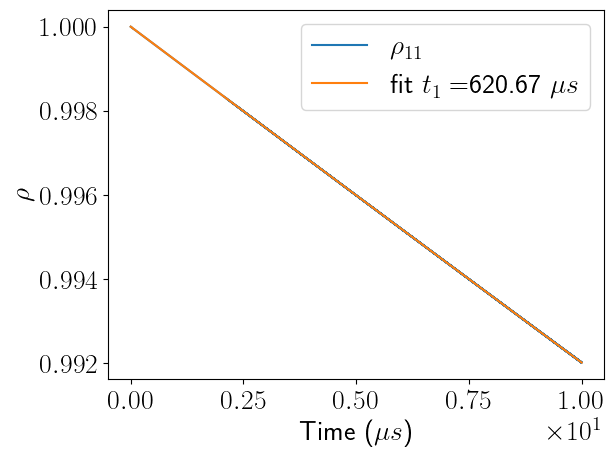

30
10.0%. Run time:   6.62s. Est. time left: 00:00:00:59
20.0%. Run time:  14.01s. Est. time left: 00:00:00:56
30.0%. Run time:  21.09s. Est. time left: 00:00:00:49
40.0%. Run time:  28.18s. Est. time left: 00:00:00:42
50.0%. Run time:  35.25s. Est. time left: 00:00:00:35
60.0%. Run time:  42.32s. Est. time left: 00:00:00:28
70.0%. Run time:  49.39s. Est. time left: 00:00:00:21
80.0%. Run time:  56.50s. Est. time left: 00:00:00:14
90.0%. Run time:  64.16s. Est. time left: 00:00:00:07
Total run time:  71.72s


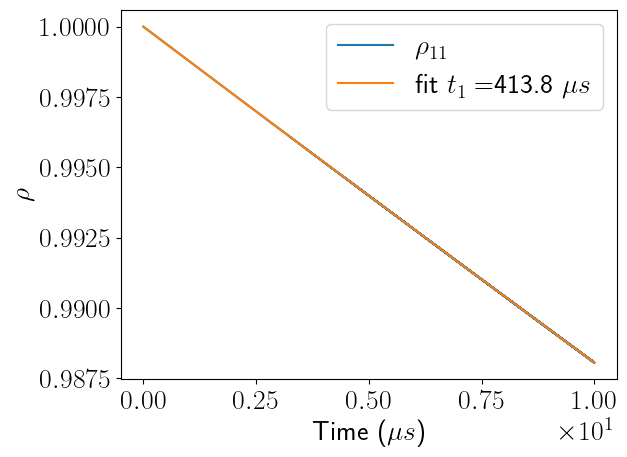

40
10.0%. Run time:   6.58s. Est. time left: 00:00:00:59
20.0%. Run time:  13.55s. Est. time left: 00:00:00:54
30.0%. Run time:  20.51s. Est. time left: 00:00:00:47
40.0%. Run time:  27.65s. Est. time left: 00:00:00:41
50.0%. Run time:  35.03s. Est. time left: 00:00:00:35
60.0%. Run time:  42.38s. Est. time left: 00:00:00:28
70.0%. Run time:  49.73s. Est. time left: 00:00:00:21
80.0%. Run time:  57.79s. Est. time left: 00:00:00:14
90.0%. Run time:  65.15s. Est. time left: 00:00:00:07
Total run time:  72.50s


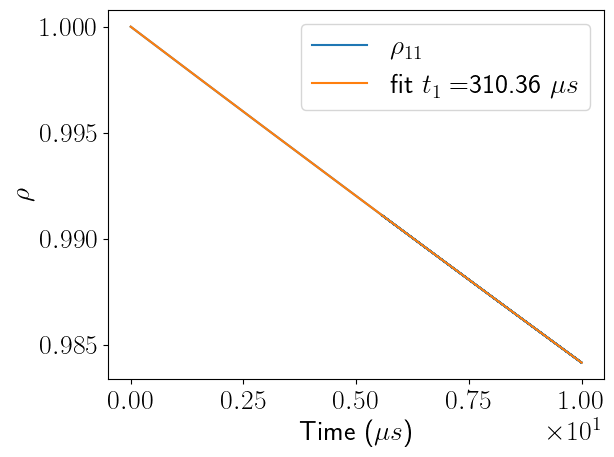

50
10.0%. Run time:   6.63s. Est. time left: 00:00:00:59
20.0%. Run time:  13.46s. Est. time left: 00:00:00:53
30.0%. Run time:  20.69s. Est. time left: 00:00:00:48
40.0%. Run time:  27.89s. Est. time left: 00:00:00:41
50.0%. Run time:  35.15s. Est. time left: 00:00:00:35
60.0%. Run time:  42.36s. Est. time left: 00:00:00:28
70.0%. Run time:  49.56s. Est. time left: 00:00:00:21
80.0%. Run time:  56.87s. Est. time left: 00:00:00:14
90.0%. Run time:  64.18s. Est. time left: 00:00:00:07
Total run time:  71.44s


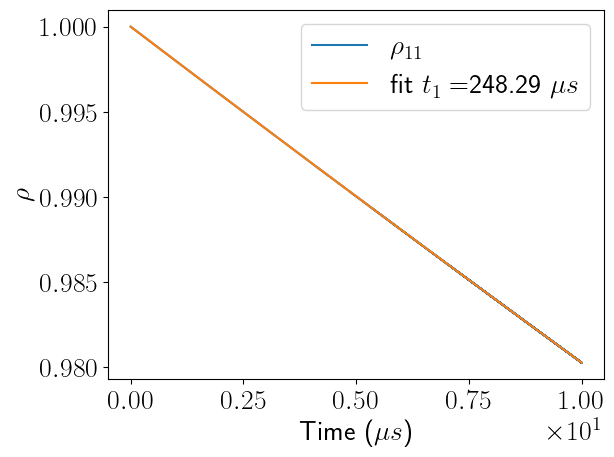

60
10.0%. Run time:   6.62s. Est. time left: 00:00:00:59
20.0%. Run time:  13.55s. Est. time left: 00:00:00:54
30.0%. Run time:  20.57s. Est. time left: 00:00:00:48
40.0%. Run time:  27.91s. Est. time left: 00:00:00:41
50.0%. Run time:  35.20s. Est. time left: 00:00:00:35
60.0%. Run time:  42.49s. Est. time left: 00:00:00:28
70.0%. Run time:  50.77s. Est. time left: 00:00:00:21
80.0%. Run time:  58.07s. Est. time left: 00:00:00:14
90.0%. Run time:  65.40s. Est. time left: 00:00:00:07
Total run time:  72.72s


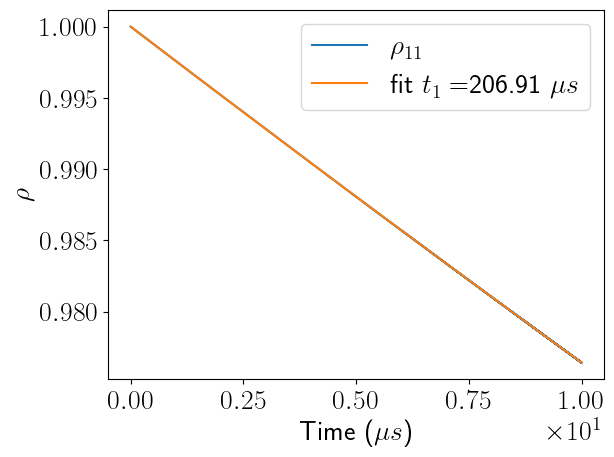

70
10.0%. Run time:   6.72s. Est. time left: 00:00:01:00
20.0%. Run time:  13.49s. Est. time left: 00:00:00:53
30.0%. Run time:  20.53s. Est. time left: 00:00:00:47
40.0%. Run time:  27.72s. Est. time left: 00:00:00:41
50.0%. Run time:  35.07s. Est. time left: 00:00:00:35
60.0%. Run time:  42.44s. Est. time left: 00:00:00:28
70.0%. Run time:  49.82s. Est. time left: 00:00:00:21
80.0%. Run time:  57.17s. Est. time left: 00:00:00:14
90.0%. Run time:  64.54s. Est. time left: 00:00:00:07
Total run time:  71.92s


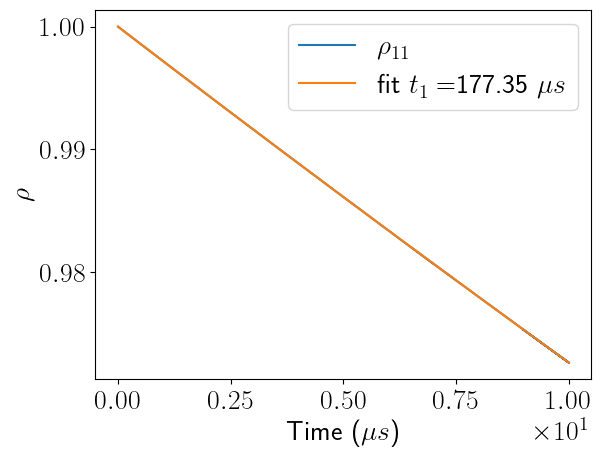

80
10.0%. Run time:   6.58s. Est. time left: 00:00:00:59
20.0%. Run time:  13.44s. Est. time left: 00:00:00:53
30.0%. Run time:  20.60s. Est. time left: 00:00:00:48
40.0%. Run time:  27.73s. Est. time left: 00:00:00:41
50.0%. Run time:  34.88s. Est. time left: 00:00:00:34
60.0%. Run time:  42.03s. Est. time left: 00:00:00:28
70.0%. Run time:  49.18s. Est. time left: 00:00:00:21
80.0%. Run time:  56.33s. Est. time left: 00:00:00:14
90.0%. Run time:  63.47s. Est. time left: 00:00:00:07
Total run time:  71.76s


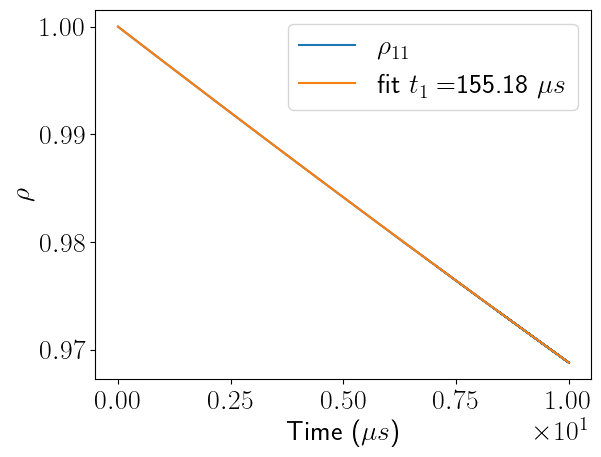

90
10.0%. Run time:   6.59s. Est. time left: 00:00:00:59
20.0%. Run time:  13.45s. Est. time left: 00:00:00:53
30.0%. Run time:  20.54s. Est. time left: 00:00:00:47
40.0%. Run time:  27.65s. Est. time left: 00:00:00:41
50.0%. Run time:  34.75s. Est. time left: 00:00:00:34
60.0%. Run time:  41.89s. Est. time left: 00:00:00:27
70.0%. Run time:  49.01s. Est. time left: 00:00:00:21
80.0%. Run time:  56.27s. Est. time left: 00:00:00:14
90.0%. Run time:  63.41s. Est. time left: 00:00:00:07
Total run time:  70.95s


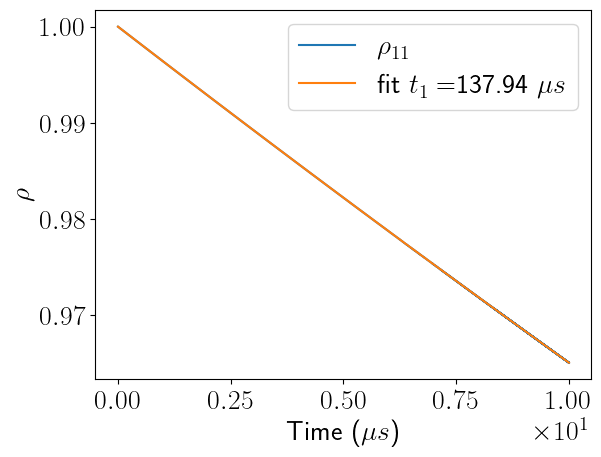

100
10.0%. Run time:   6.64s. Est. time left: 00:00:00:59
20.0%. Run time:  13.60s. Est. time left: 00:00:00:54
30.0%. Run time:  20.56s. Est. time left: 00:00:00:47
40.0%. Run time:  27.60s. Est. time left: 00:00:00:41
50.0%. Run time:  35.03s. Est. time left: 00:00:00:35
60.0%. Run time:  42.44s. Est. time left: 00:00:00:28
70.0%. Run time:  49.86s. Est. time left: 00:00:00:21
80.0%. Run time:  57.27s. Est. time left: 00:00:00:14
90.0%. Run time:  64.72s. Est. time left: 00:00:00:07
Total run time:  72.11s


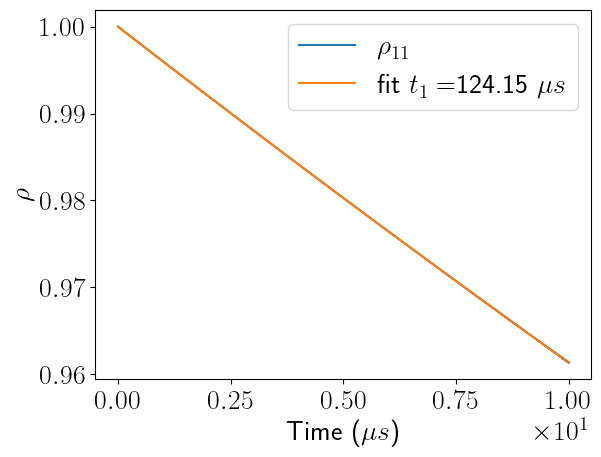

120
10.0%. Run time:   6.59s. Est. time left: 00:00:00:59
20.0%. Run time:  13.56s. Est. time left: 00:00:00:54
30.0%. Run time:  20.54s. Est. time left: 00:00:00:47
40.0%. Run time:  27.62s. Est. time left: 00:00:00:41
50.0%. Run time:  34.85s. Est. time left: 00:00:00:34
60.0%. Run time:  42.37s. Est. time left: 00:00:00:28
70.0%. Run time:  49.85s. Est. time left: 00:00:00:21
80.0%. Run time:  57.35s. Est. time left: 00:00:00:14
90.0%. Run time:  64.78s. Est. time left: 00:00:00:07
Total run time:  73.74s


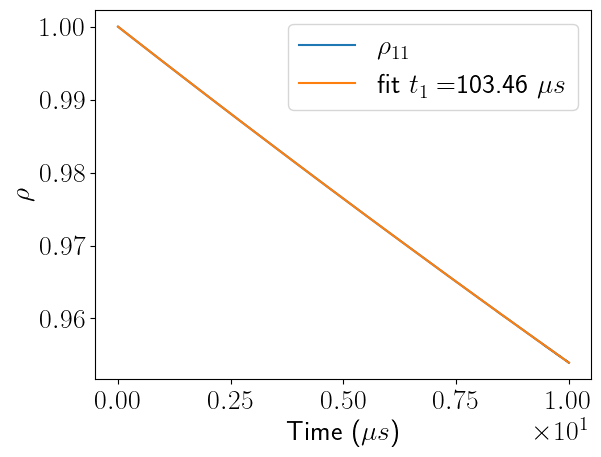

140
10.0%. Run time:   6.68s. Est. time left: 00:00:01:00
20.0%. Run time:  13.69s. Est. time left: 00:00:00:54
30.0%. Run time:  20.69s. Est. time left: 00:00:00:48
40.0%. Run time:  28.00s. Est. time left: 00:00:00:41
50.0%. Run time:  35.46s. Est. time left: 00:00:00:35
60.0%. Run time:  42.97s. Est. time left: 00:00:00:28
70.0%. Run time:  50.40s. Est. time left: 00:00:00:21
80.0%. Run time:  57.85s. Est. time left: 00:00:00:14
90.0%. Run time:  65.30s. Est. time left: 00:00:00:07
Total run time:  72.75s


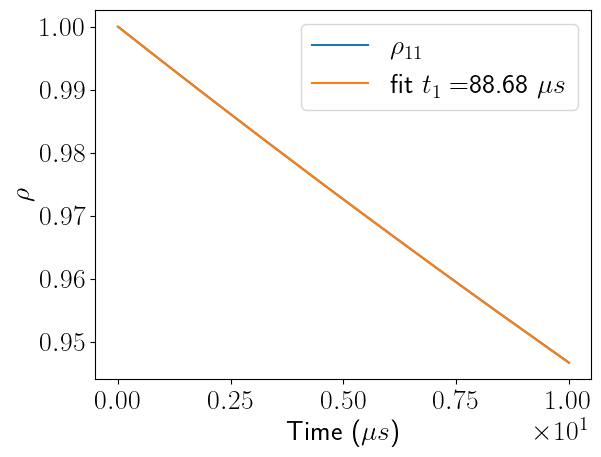

160
10.0%. Run time:   6.63s. Est. time left: 00:00:00:59
20.0%. Run time:  13.44s. Est. time left: 00:00:00:53
30.0%. Run time:  20.34s. Est. time left: 00:00:00:47
40.0%. Run time:  27.65s. Est. time left: 00:00:00:41
50.0%. Run time:  34.92s. Est. time left: 00:00:00:34
60.0%. Run time:  42.22s. Est. time left: 00:00:00:28
70.0%. Run time:  49.56s. Est. time left: 00:00:00:21
80.0%. Run time:  56.89s. Est. time left: 00:00:00:14
90.0%. Run time:  64.19s. Est. time left: 00:00:00:07
Total run time:  71.54s


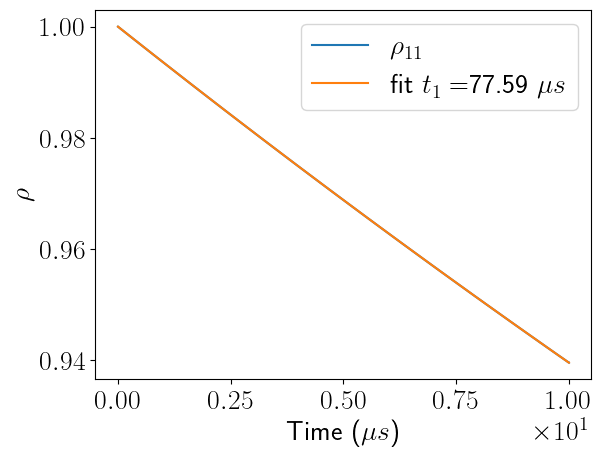

180
10.0%. Run time:   6.63s. Est. time left: 00:00:00:59
20.0%. Run time:  13.60s. Est. time left: 00:00:00:54
30.0%. Run time:  20.67s. Est. time left: 00:00:00:48
40.0%. Run time:  27.68s. Est. time left: 00:00:00:41
50.0%. Run time:  34.76s. Est. time left: 00:00:00:34
60.0%. Run time:  42.24s. Est. time left: 00:00:00:28
70.0%. Run time:  49.77s. Est. time left: 00:00:00:21
80.0%. Run time:  57.26s. Est. time left: 00:00:00:14
90.0%. Run time:  64.76s. Est. time left: 00:00:00:07
Total run time:  72.24s


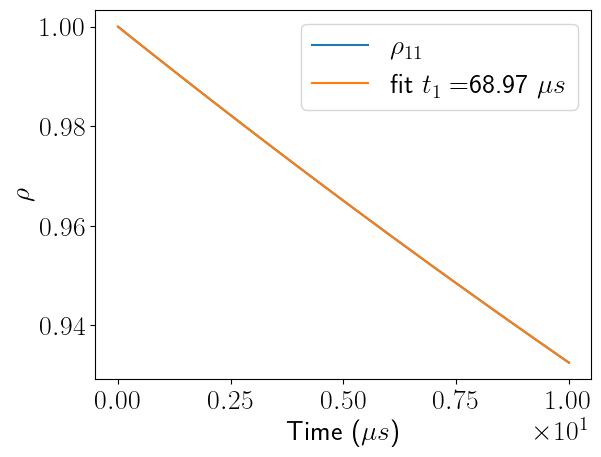

200
10.0%. Run time:   6.57s. Est. time left: 00:00:00:59
20.0%. Run time:  13.33s. Est. time left: 00:00:00:53
30.0%. Run time:  20.49s. Est. time left: 00:00:00:47
40.0%. Run time:  27.64s. Est. time left: 00:00:00:41
50.0%. Run time:  34.75s. Est. time left: 00:00:00:34
60.0%. Run time:  41.92s. Est. time left: 00:00:00:27
70.0%. Run time:  50.91s. Est. time left: 00:00:00:21
80.0%. Run time:  58.12s. Est. time left: 00:00:00:14
90.0%. Run time:  65.41s. Est. time left: 00:00:00:07
Total run time:  72.75s


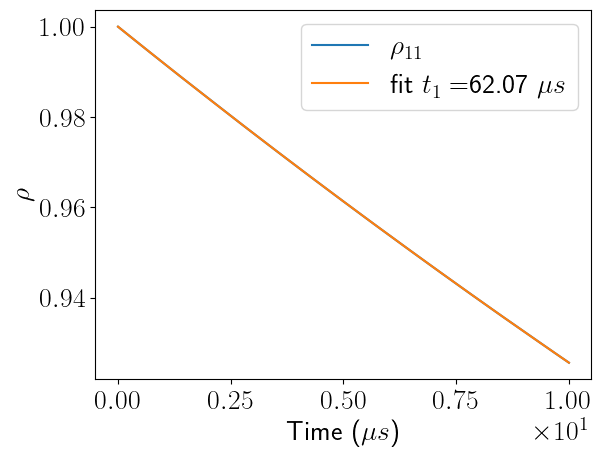

220
10.0%. Run time:   6.67s. Est. time left: 00:00:01:00
20.0%. Run time:  13.65s. Est. time left: 00:00:00:54
30.0%. Run time:  20.84s. Est. time left: 00:00:00:48
40.0%. Run time:  27.97s. Est. time left: 00:00:00:41
50.0%. Run time:  35.09s. Est. time left: 00:00:00:35
60.0%. Run time:  42.28s. Est. time left: 00:00:00:28
70.0%. Run time:  49.56s. Est. time left: 00:00:00:21
80.0%. Run time:  57.18s. Est. time left: 00:00:00:14
90.0%. Run time:  64.79s. Est. time left: 00:00:00:07
Total run time:  72.39s


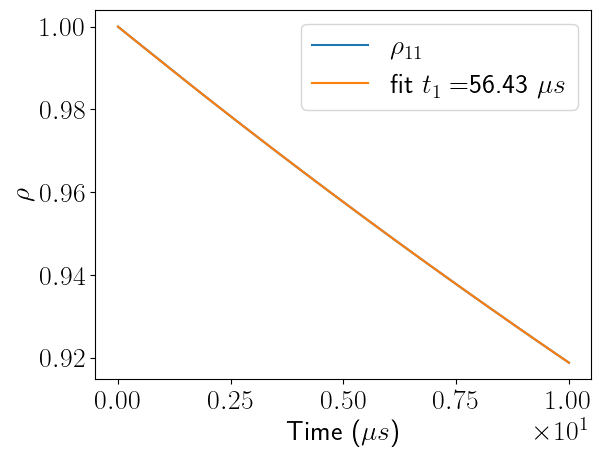

240
10.0%. Run time:   6.65s. Est. time left: 00:00:00:59
20.0%. Run time:  13.56s. Est. time left: 00:00:00:54
30.0%. Run time:  20.54s. Est. time left: 00:00:00:47
40.0%. Run time:  27.72s. Est. time left: 00:00:00:41
50.0%. Run time:  35.12s. Est. time left: 00:00:00:35
60.0%. Run time:  42.60s. Est. time left: 00:00:00:28
70.0%. Run time:  50.00s. Est. time left: 00:00:00:21
80.0%. Run time:  57.41s. Est. time left: 00:00:00:14
90.0%. Run time:  64.82s. Est. time left: 00:00:00:07
Total run time:  72.27s


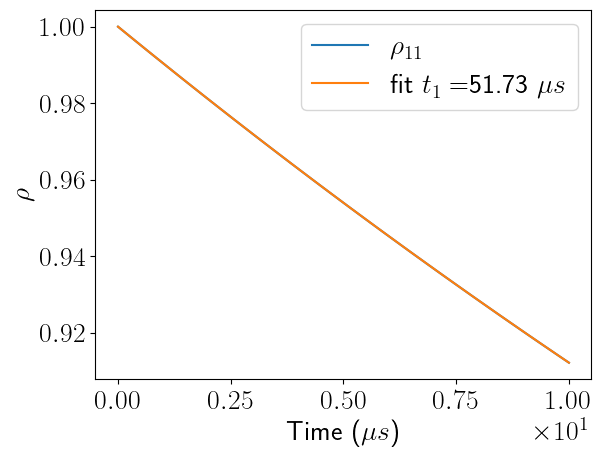

260
10.0%. Run time:   6.70s. Est. time left: 00:00:01:00
20.0%. Run time:  13.82s. Est. time left: 00:00:00:55
30.0%. Run time:  20.87s. Est. time left: 00:00:00:48
40.0%. Run time:  27.90s. Est. time left: 00:00:00:41
50.0%. Run time:  35.39s. Est. time left: 00:00:00:35
60.0%. Run time:  42.89s. Est. time left: 00:00:00:28
70.0%. Run time:  50.39s. Est. time left: 00:00:00:21
80.0%. Run time:  57.88s. Est. time left: 00:00:00:14
90.0%. Run time:  65.51s. Est. time left: 00:00:00:07
Total run time:  73.00s


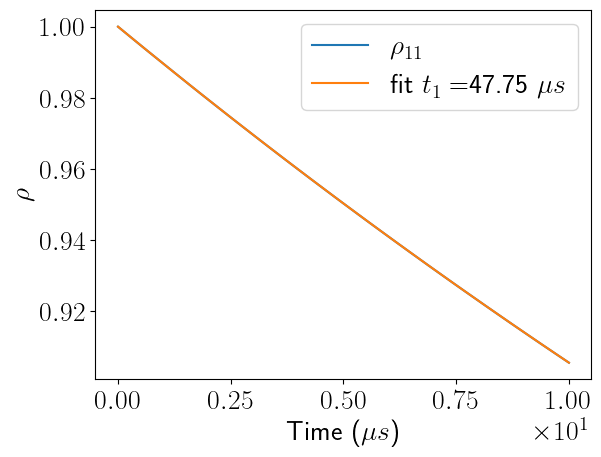

280
10.0%. Run time:   6.62s. Est. time left: 00:00:00:59
20.0%. Run time:  13.57s. Est. time left: 00:00:00:54
30.0%. Run time:  20.52s. Est. time left: 00:00:00:47
40.0%. Run time:  27.79s. Est. time left: 00:00:00:41
50.0%. Run time:  35.14s. Est. time left: 00:00:00:35
60.0%. Run time:  42.50s. Est. time left: 00:00:00:28
70.0%. Run time:  49.92s. Est. time left: 00:00:00:21
80.0%. Run time:  57.28s. Est. time left: 00:00:00:14
90.0%. Run time:  64.66s. Est. time left: 00:00:00:07
Total run time:  72.05s


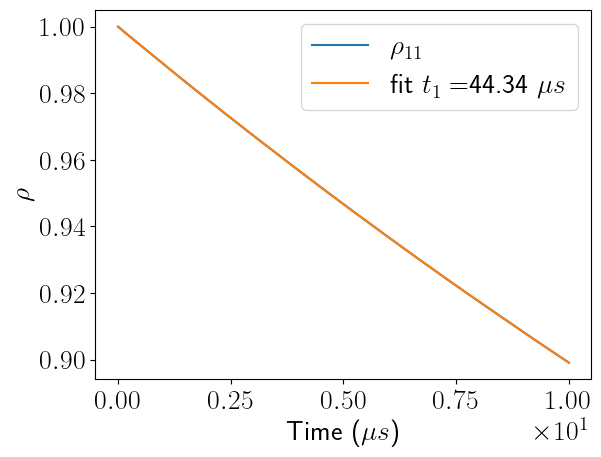

300
10.0%. Run time:   6.69s. Est. time left: 00:00:01:00
20.0%. Run time:  13.57s. Est. time left: 00:00:00:54
30.0%. Run time:  23.07s. Est. time left: 00:00:00:53
40.0%. Run time:  30.27s. Est. time left: 00:00:00:45
50.0%. Run time:  37.47s. Est. time left: 00:00:00:37
60.0%. Run time:  44.66s. Est. time left: 00:00:00:29
70.0%. Run time:  51.93s. Est. time left: 00:00:00:22
80.0%. Run time:  59.12s. Est. time left: 00:00:00:14
90.0%. Run time:  66.46s. Est. time left: 00:00:00:07
Total run time:  73.65s


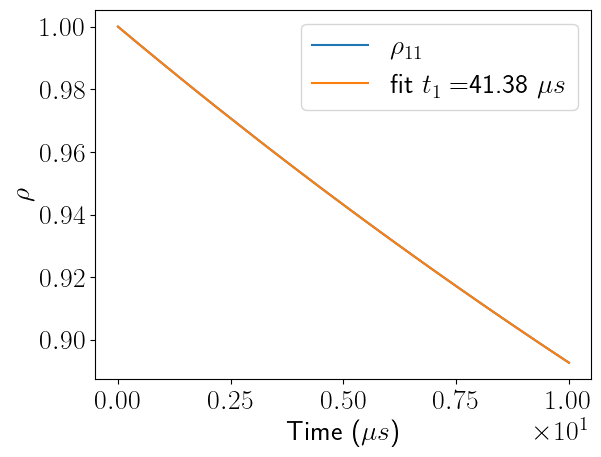

320
10.0%. Run time:   6.67s. Est. time left: 00:00:01:00
20.0%. Run time:  13.26s. Est. time left: 00:00:00:53
30.0%. Run time:  20.23s. Est. time left: 00:00:00:47
40.0%. Run time:  27.61s. Est. time left: 00:00:00:41
50.0%. Run time:  34.92s. Est. time left: 00:00:00:34
60.0%. Run time:  42.15s. Est. time left: 00:00:00:28
70.0%. Run time:  49.35s. Est. time left: 00:00:00:21
80.0%. Run time:  56.51s. Est. time left: 00:00:00:14
90.0%. Run time:  63.69s. Est. time left: 00:00:00:07
Total run time:  70.90s


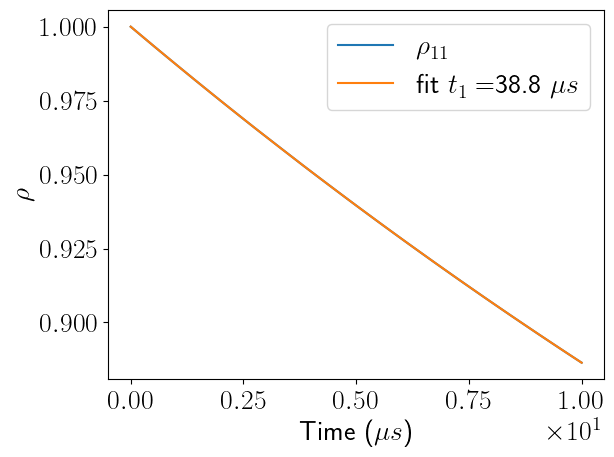

[968.06902883 807.81282221 532.45512621 382.94105132 296.18808393
 240.64036644 202.31877924 174.37972131 153.15071217 136.48972491
 123.0744574  102.82251508  88.27189086  77.31825372  68.77705899
  61.93171781  56.32360619  51.64545836  47.68394704  44.28626452
  41.34015042  38.76123173]


In [70]:
# Classical
tlist = np.linspace(1, 10e6, 100000) # in ps
t1_list_345mT_classical = np.array([])
t1d_list_345mT_classical = np.array([])

rho0 = basis(2,0)*basis(2,0).dag()
e_ops = []
rho_list = []
options=Options()
options.nsteps=5000

for k in range(len(Temp_list)):
    temp = Temp_list[k]
    print(temp)
    specDensityX = lambda w : spectral_density_classical(w, freqs=freq, coup=gcoupS[:,0]*0.345, T=temp, sigma=2)/hbar**2
    specDensityY = lambda w : spectral_density_classical(w, freqs=freq, coup=gcoupS[:,1]*0.345, T=temp, sigma=2)/hbar**2
    specDensityZ = lambda w : spectral_density_classical(w, freqs=freq, coup=gcoupS[:,2]*0.345, T=temp, sigma=2)/hbar**2
    aops = [[sigmax(),specDensityX], [sigmay(),specDensityY], [sigmaz(),specDensityZ]]
    
    results_k = brmesolve(H345/(hbar), rho0, tlist, a_ops=aops, e_ops=e_ops, progress_bar = True)
    rho_list.append(results_k.states) # saving states for later
    rho11_k = np.array([results_k.states[j].full()[0,0] for j in range(len(tlist))]) # first element of rho vs time 
    

    #f, df = curve_fit(t1_func_thermal, tlist/1e6, np.abs(rho11_k))
    f, df = curve_fit(t1_func_classical, tlist/1e6, np.abs(rho11_k))
    #f, df = curve_fit(t1_func, tlist/1e6, np.abs(rho11_k))
    #print('saturation value difference', f[1]-rho11_k[-1])
    #t1, t1d = f[0], df[0,0]
    t1, t1d = f, df
    t1_list_345mT_classical = np.append(t1_list_345mT_classical, t1)
    t1d_list_345mT_classical = np.append(t1d_list_345mT_classical, t1d)
    ##########################################################################################################################
    ################## PLOTTING ################################################
    #fit = np.array([t1_func_classical(m, f)  for m in tlist/1e6])
    fit = np.array([t1_func_classical(m, f)  for m in tlist/1e6])
    #fit = np.array([t1_func(m, f[0],f[1])  for m in tlist/1e6])
    plt.figure()
    plt.plot(tlist/1e6, np.abs(rho11_k))
    plt.plot(tlist/1e6, fit)
    #plt.plot(tlist/1e6, fit_thermal)
    plt.xlabel(r"Time ($\mu s$)")
    plt.ylabel(r"$\rho$")
    plt.legend([r"$\rho_{11}$", r"fit $t_1 = $"+str(np.round(f,2)[0])+r"$\ \mu s$", r"fit_thermal $t_1 = $"+str(np.round(fthermal,2)[0])+r"$\ \mu s$"])
    plt.show()
    ############################################################################################################################
np.save('saved variables/t1_list_345mT_classical', t1_list_345mT_classical)
np.save('saved variables/t1d_list_345mT_classical', t1d_list_345mT_classical)
print(t1_list_345mT)  

#### Simulation done

In [71]:
tlist = np.linspace(1, 10000e6, 2000) # in ps

Text(0, 0.5, '$T_1 [\\mu s]$')

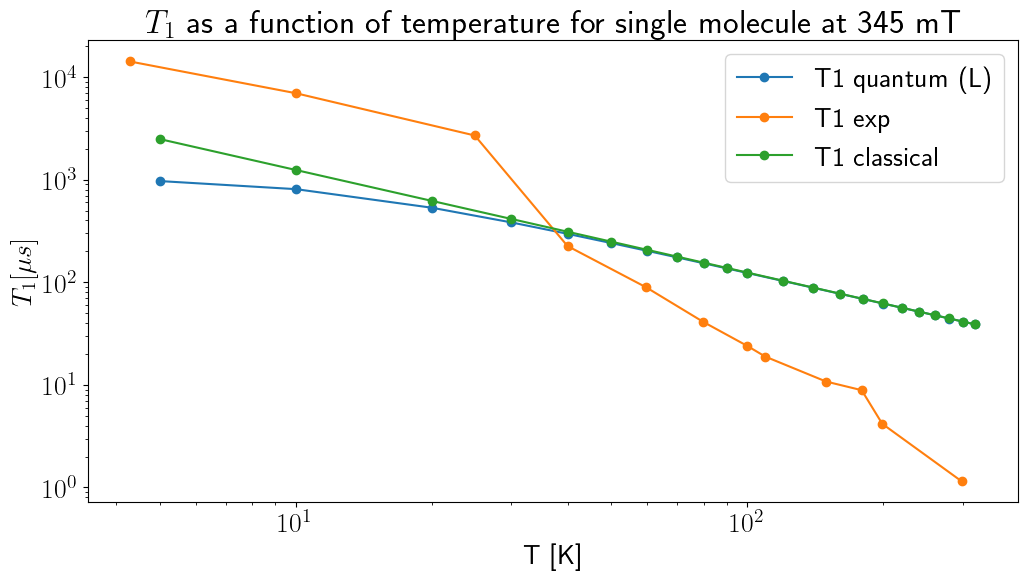

In [72]:
#tlist = np.linspace(1, 10e6, 100000) # in ps

t1exp = np.array([14163.72734, 6951.95423, 2691.61351,225.3970881,89.17022735,41.0253116,23.92805806,18.87486711,10.77391862,
                  8.873229094,4.171377424,1.143754573])
t2exp = np.array([2.709966603,3.084314127,3.362185823,3.290454844,3.018511437,2.829407455,2.540192367,2.330255261,2.047428917,
                  1.798929603,1.449961246, 0.84569149])
temp_exp = np.array([4.292624643, 9.998683733, 24.90051857, 39.95789327, 59.68654518, 79.87897033, 99.98683733, 109.4868393, 
                     149.3539422, 179.0832077, 198.9289628, 298.5702735])

t1_list_345mT = np.load('saved variables/t1_list_345mT.npy')
t1d_list_345mT = np.load('saved variables/t1d_list_345mT.npy')

t1_list_345mT_classical = np.load('saved variables/t1_list_345mT_classical.npy')
t1d_list_345mT_classical = np.load('saved variables/t1d_list_345mT_classical.npy')

plt.figure(figsize=(12,6))
plt.plot(Temp_list, t1_list_345mT,'-o')#, yerr = t1d_list_345mT, fmt='-o')
plt.plot(temp_exp, t1exp,'-o')
plt.plot(Temp_list, t1_list_345mT_classical,'-o')

plt.xscale('log')
plt.yscale('log')
plt.title(r"$T_1$ as a function of temperature for single molecule at 345 mT")
plt.legend(['T1 quantum (L)', 'T1 exp', 'T1 classical'])
plt.xlabel('T [K]')
plt.ylabel(r"$T_1 [\mu s]$")

Text(0, 0.5, '$T_1 [\\mu s]$')

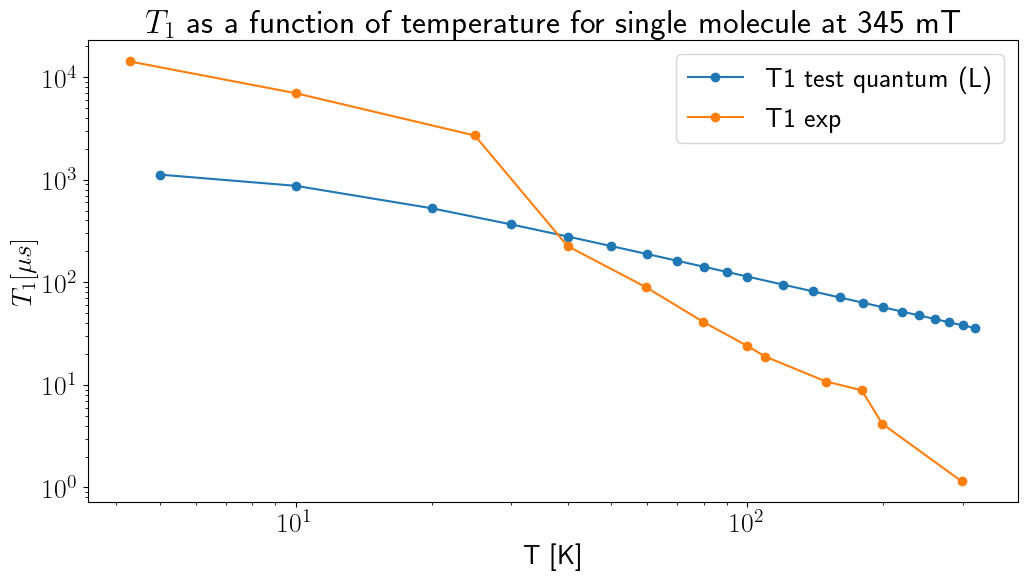

In [73]:
plt.figure(figsize=(12,6))
plt.plot(Temp_list, t1_list_test,'-o')
plt.plot(temp_exp, t1exp,'-o')

plt.xscale('log')
plt.yscale('log')
plt.title(r"$T_1$ as a function of temperature for single molecule at 345 mT")
plt.legend(['T1 test quantum (L)', 'T1 exp'])
plt.xlabel('T [K]')
plt.ylabel(r"$T_1 [\mu s]$")

## T2 Dynamics

In [41]:
tlist_t2 = np.linspace(1, 3e6, 10000) # in ps
rho0 = basis(2,0)*basis(2,1).dag()
rho0

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = False
Qobj data =
[[0. 1.]
 [0. 0.]]

In [42]:
tlist_t2 = np.linspace(1, 3e6, 10000) # in ps
rho0 = basis(2,0)*basis(2,1).dag()

e_ops = []
specDensityX = lambda w : spectral_density_quantum(w, freqs=freq/hbar, coup=gcoupS[:,0]/hbar, T=Temp, sigma=2)
specDensityY = lambda w : spectral_density_quantum(w, freqs=freq/hbar, coup=gcoupS[:,1]/hbar, T=Temp, sigma=2)
specDensityZ = lambda w : spectral_density_quantum(w, freqs=freq/hbar, coup=gcoupS[:,2]/hbar, T=Temp, sigma=2)
aops = [[sigmax(),specDensityX], [sigmay(),specDensityY], [sigmaz(),specDensityZ]]
    
results_k = brmesolve(H/(hbar), rho0, tlist_t2, a_ops=aops, e_ops=e_ops, progress_bar=True)

rho12 = np.array([results_k.states[j].full()[0,1] for j in range(len(tlist_t2))]) # 12 element of rho vs time 

10.0%. Run time:   1.69s. Est. time left: 00:00:00:15
20.0%. Run time:   3.38s. Est. time left: 00:00:00:13
30.0%. Run time:   5.06s. Est. time left: 00:00:00:11
40.0%. Run time:   6.83s. Est. time left: 00:00:00:10
50.0%. Run time:   8.51s. Est. time left: 00:00:00:08
60.0%. Run time:  10.19s. Est. time left: 00:00:00:06
70.0%. Run time:  11.87s. Est. time left: 00:00:00:05
80.0%. Run time:  13.54s. Est. time left: 00:00:00:03
90.0%. Run time:  15.24s. Est. time left: 00:00:00:01
Total run time:  16.92s


In [43]:
def t2_func(x,t2):
    return np.exp(-x/t2)

In [44]:
t2, t2d = curve_fit(t2_func, tlist_t2/1e6, np.abs(rho12))
t2

array([0.68723339])

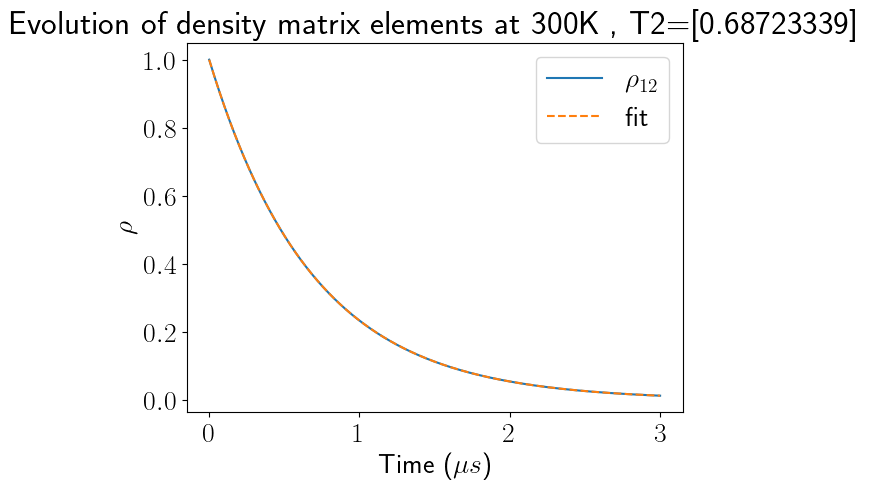

In [92]:

fit = np.array([t2_func(k,t2)  for k in tlist_t2/1e6])

plt.figure()
plt.plot(tlist_t2/1e6, np.abs(rho12))
plt.plot(tlist_t2/1e6, fit, '--')
plt.xlabel(r"Time ($\mu s$)")
plt.ylabel(r"$\rho$")
plt.title("Evolution of density matrix elements at "+str(Temp)+"K , T2="+str(t2))
plt.legend([r"$\rho_{12}$", r"fit"])
plt.show()

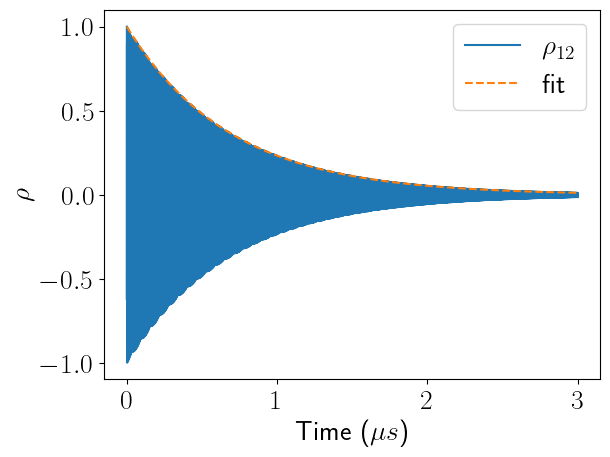

In [94]:
fit = np.array([t2_func(k,t2)  for k in tlist_t2/1e6])

plt.figure()
plt.plot(tlist_t2/1e6, np.real(rho12))
plt.plot(tlist_t2/1e6, fit, '--')
plt.xlabel(r"Time ($\mu s$)")
plt.ylabel(r"$\rho$")
#plt.title("Evolution of density matrix elements at "+str(Temp)+"K , T2="+str(np.round(t2,3)))
plt.legend([r"$\rho_{12}$", r"fit "])
plt.show()

In [ ]:
# Temperature Scan 

t2_list = np.array([])
t2d_list = np.array([])

e_ops = []
rho_list = []

for k in range(len(Temp_list)):
    
    temp = Temp_list[k]
    print("calculating t2 for ",temp, " K")
    
    specDensityX = lambda w : spectral_density_quantum(w, freqs=freq/hbar, coup=gcoupS[:,0]/hbar, T=temp, sigma=2)
    specDensityY = lambda w : spectral_density_quantum(w, freqs=freq/hbar, coup=gcoupS[:,1]/hbar, T=temp, sigma=2)
    specDensityZ = lambda w : spectral_density_quantum(w, freqs=freq/hbar, coup=gcoupS[:,2]/hbar, T=temp, sigma=2)
    aops = [[sigmax(),specDensityX], [sigmay(),specDensityY], [sigmaz(),specDensityZ]]
    
    results_k = brmesolve(H/(hbar), rho0, tlist_t2, a_ops=aops, e_ops=e_ops)#, progress_bar=True)
    rho_list.append(results_k.states) # saving states for later
    rho12_k = np.array([results_k.states[j].full()[0,1] for j in range(len(tlist_t2))]) # first element of rho vs time 
    t2, t2d = curve_fit(t2_func, tlist_t2/1e6, np.abs(rho12_k))
    t2_list = np.append(t2_list, t2)
    t2d_list = np.append(t2d_list, t2d)


np.save('saved variables/t2_list', t2_list)
np.save('saved variables/t2d_list', t2d_list)
print(t2_list)  

rho12_vals = np.array([rho_list[-1][m].full()[0,1] for m in range(len(tlist_t2))])
rho21_vals = np.array([rho_list[-1][m].full()[1,0] for m in range(len(tlist_t2))])
fit = np.array([t2_func(k,t2_list[-1])  for k in tlist_t2/1e6])

plt.figure()
plt.plot(tlist_t2/1e6, np.abs(rho12_vals))
plt.plot(tlist_t2/1e6, np.abs(rho21_vals))
plt.plot(tlist_t2/1e6, fit)
plt.xlabel(r"Time ($\mu s$)")
plt.ylabel(r"$\rho$")
plt.title("Evolution of density matrix elements at "+str(Temp_list[-1])+"K , T2="+str(np.round(t2_list[-1],3)))
plt.legend([r"$\rho_{12}$", r"$\rho_{21}$", "fit"])
plt.show()

In [ ]:
# Temperature Scan 

t2_list_classical = np.array([])
t2d_list_classical = np.array([])

e_ops = []
rho_list = []

for k in range(len(Temp_list)):
    
    temp = Temp_list[k]
    print("calculating t2 for ",temp, " K")
    
    specDensityX = lambda w : spectral_density_classical(w, freqs=freq/hbar, coup=gcoupS[:,0]/hbar, T=temp, sigma=2)
    specDensityY = lambda w : spectral_density_classical(w, freqs=freq/hbar, coup=gcoupS[:,1]/hbar, T=temp, sigma=2)
    specDensityZ = lambda w : spectral_density_classical(w, freqs=freq/hbar, coup=gcoupS[:,2]/hbar, T=temp, sigma=2)
    aops = [[sigmax(),specDensityX], [sigmay(),specDensityY], [sigmaz(),specDensityZ]]
    
    results_k = brmesolve(H/(hbar), rho0, tlist_t2, a_ops=aops, e_ops=e_ops)#, progress_bar=True)
    rho_list.append(results_k.states) # saving states for later
    rho12_k = np.array([results_k.states[j].full()[0,1] for j in range(len(tlist_t2))]) # first element of rho vs time 
    t2, t2d = curve_fit(t2_func, tlist_t2/1e6, np.abs(rho12_k))
    t2_list_classical = np.append(t2_list_classical, t2)
    t2d_list_classical = np.append(t2d_list_classical, t2d)


np.save('saved variables/t2_list_classical', t2_list_classical)
np.save('saved variables/t2d_list_classical', t2d_list_classical)
print(t2_list)  

rho12_vals = np.array([rho_list[-1][m].full()[0,1] for m in range(len(tlist_t2))])
rho21_vals = np.array([rho_list[-1][m].full()[1,0] for m in range(len(tlist_t2))])
fit = np.array([t2_func(k,t2_list[-1])  for k in tlist_t2/1e6])

plt.figure()
plt.plot(tlist_t2/1e6, np.abs(rho12_vals))
plt.plot(tlist_t2/1e6, np.abs(rho21_vals))
plt.plot(tlist_t2/1e6, fit)
plt.xlabel(r"Time ($\mu s$)")
plt.ylabel(r"$\rho$")
plt.title("Evolution of density matrix elements at "+str(Temp_list[-1])+"K , T2="+str(np.round(t2_list_classical[-1],3)))
plt.legend([r"$\rho_{12}$", r"$\rho_{21}$", "fit"])
plt.show()

In [ ]:
#t2_list = np.load('t2_list.npy')
#t2d_list = np.load('t2d_list.npy')

In [ ]:
# plotting all curves and fittings to check if t2 calculations went properly

plt.figure()
for i in range(len(Temp_list)):
    rho12_vals = np.array([rho_list[i][m].full()[0,1] for m in range(len(tlist_t2))])
    #rho21_vals = np.array([rho_list[0][m].full()[1,0] for m in range(len(tlist_t2))])
    fit = np.array([t2_func(k,t2_list[i])  for k in tlist_t2/1e6])
    plt.plot(tlist_t2/1e6, np.abs(rho12_vals))
    #plt.plot(tlist_t2/1e6, np.abs(rho21_vals))
    plt.plot(tlist_t2/1e6, fit)
plt.xlabel(r"Time ($\mu s$)")
plt.ylabel(r"$\rho$")
plt.title(r"$\rho_{12}$")
#plt.yscale('log')
#plt.legend([str(x)+" K" for x in Temp_list])
plt.show()

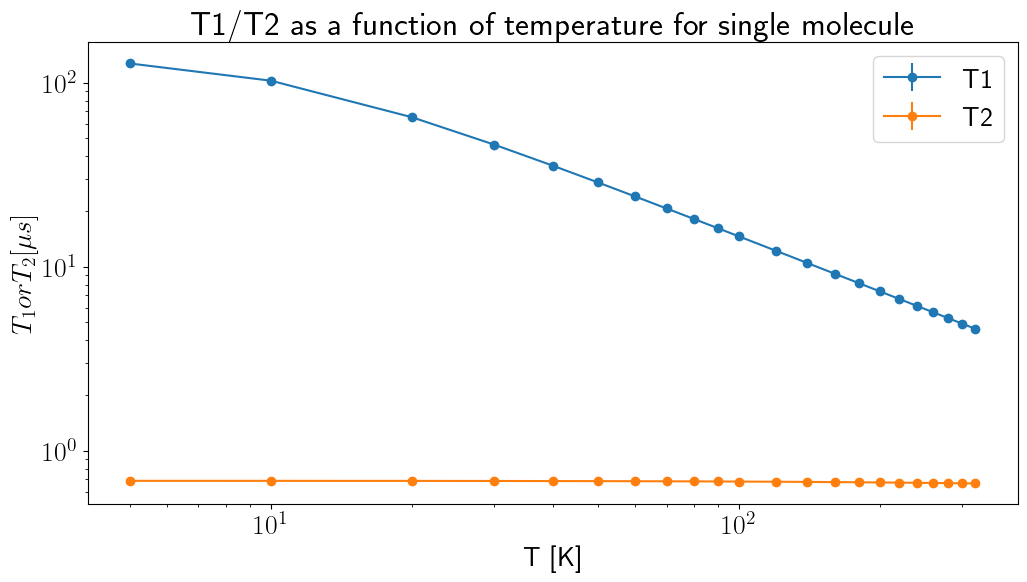

In [49]:
t2_list = np.load('saved variables/t2_list.npy')
t2d_list = np.load('saved variables/t2d_list.npy')
t1_list = np.load('saved variables/t1_list.npy')
t1d_list = np.load('saved variables/t1d_list.npy')
plt.figure(figsize=(12,6))
plt.errorbar(Temp_list, t1_list, yerr = t1d_list, fmt='-o')
plt.errorbar(Temp_list, t2_list, yerr = t2d_list, fmt='-o')
plt.xscale('log')
plt.yscale('log')
plt.title("T1/T2 as a function of temperature for single molecule")
plt.legend(['T1', 'T2'])
plt.xlabel('T [K]')
plt.ylabel(r"$T_1 or T_2 [\mu s]$")
plt.savefig('T1 and T2.png')

Text(0, 0.5, '$T_2/T_1$')

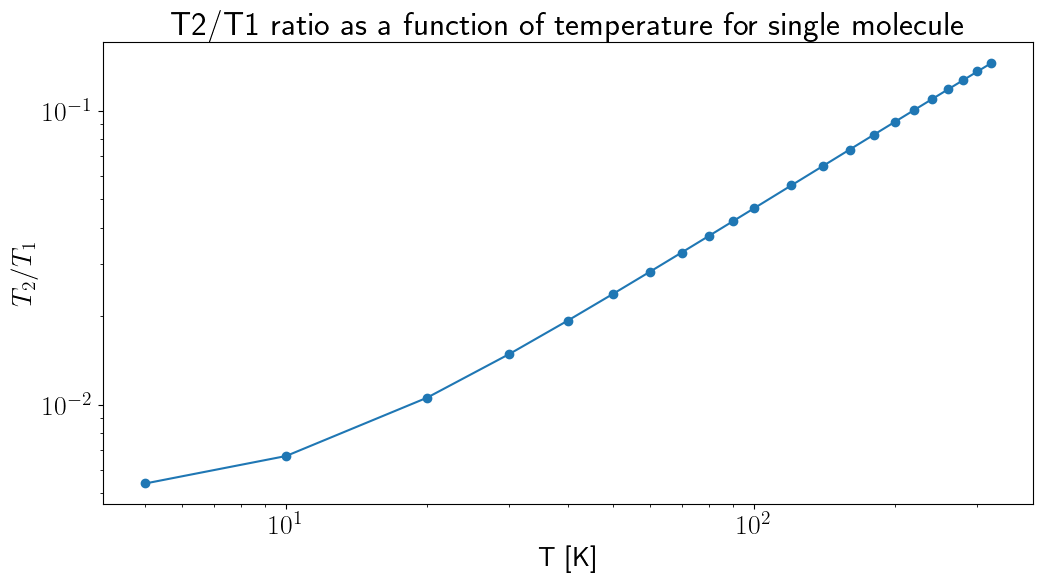

In [51]:
ratio_list = [t2_list[i]/t1_list[i] for i in range(len(t1_list))]
plt.figure(figsize=(12,6))
plt.plot(Temp_list, ratio_list, '-o')
plt.xscale('log')
plt.yscale('log')
plt.title("T2/T1 ratio as a function of temperature for single molecule")
plt.xlabel('T [K]')
plt.ylabel(r"$T_2/T_1$")

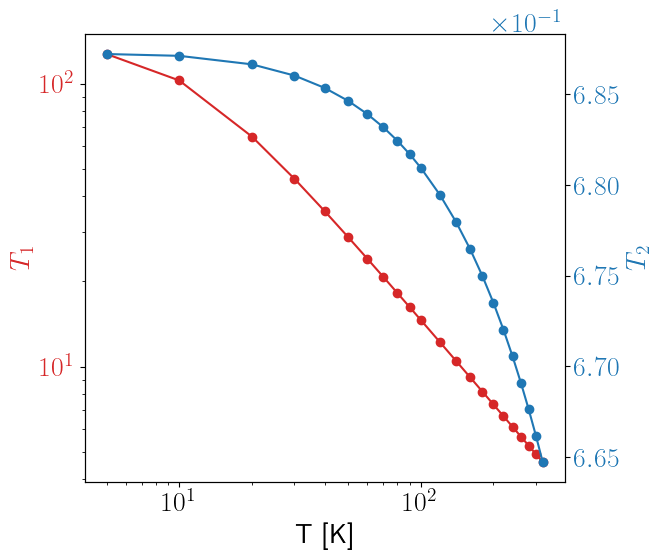

In [50]:
fig, ax1 = plt.subplots(figsize=(7,6))

color = 'tab:red'
ax1.set_xlabel('T [K]')
ax1.set_xscale('log')
ax1.set_ylabel(r"$T_1$", color=color)
ax1.set_yscale('log')
ax1.plot(Temp_list, t1_list,'-o', color=color)
ax1.tick_params(axis='y', labelcolor=color)


ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel(r"$T_2$", color=color)  # we already handled the x-label with ax1
#ax2.set_yscale('log')
ax2.plot(Temp_list, t2_list, '-o',color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

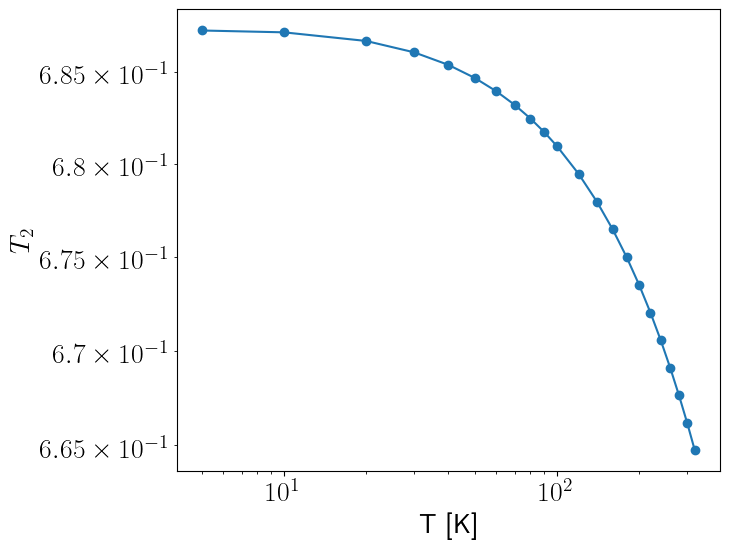

In [68]:
fig, ax1 = plt.subplots(figsize=(7,6))

#color = 'tab:blue'
ax1.set_xlabel('T [K]')
ax1.set_xscale('log')
ax1.set_ylabel(r"$T_2$")#, color=color)
ax1.set_yscale('log')
ax1.plot(Temp_list, t2_list,'-o')#, color=color)
ax1.tick_params(axis='y')#, labelcolor=color)

In [ ]:
# testing t2 dyanics at 0.345 T field
tlist_345 = np.linspace(1, 100e6, 100000) # in ps

t2_list_345mT = np.array([])
t2d_list_345mT = np.array([])

rho0 = basis(2,0)*basis(2,1).dag()
e_ops = []
rho_list = []
options=Options()
options.nsteps=5000
for k in range(len(Temp_list)):
    temp = Temp_list[k]
    specDensityX = lambda w : spectral_density_quantum(w, freqs=freq, coup=gcoupS[:,0]*0.345, T=temp, sigma=2)/hbar**2
    specDensityY = lambda w : spectral_density_quantum(w, freqs=freq, coup=gcoupS[:,1]*0.345, T=temp, sigma=2)/hbar**2
    specDensityZ = lambda w : spectral_density_quantum(w, freqs=freq, coup=gcoupS[:,2]*0.345, T=temp, sigma=2)/hbar**2
    aops = [[sigmax(),specDensityX], [sigmay(),specDensityY], [sigmaz(),specDensityZ]]
    print("temperature ", temp)
    
    results_k = brmesolve(H345/(hbar), rho0, tlist_345, a_ops=aops, e_ops=e_ops, progress_bar=True)
    rho_list.append(results_k.states) # saving states for later
    rho12_k = np.array([results_k.states[j].full()[0,1] for j in range(len(tlist_345))]) # first element of rho vs time 
    t2, t2d = curve_fit(t2_func, tlist_345/1e6, np.abs(rho12_k))
    t2_list_345mT = np.append(t2_list_345mT, t2)
    t2d_list_345mT = np.append(t2d_list_345mT, t2d)


np.save('saved variables/t2_list_345mT', t2_list_345mT)
np.save('saved variables/t2d_list_345mT', t2d_list_345mT)
print(t2_list_345mT)  
print(t2d_list_345mT)

In [ ]:
#t2_list_345mT = np.load('t2_list_345mT.npy')
#t2d_list_345mT = np.load('t2d_list_345mT.npy')

### Comparison of T1 and T2 with Experimental Data at 345 mT magnetic field

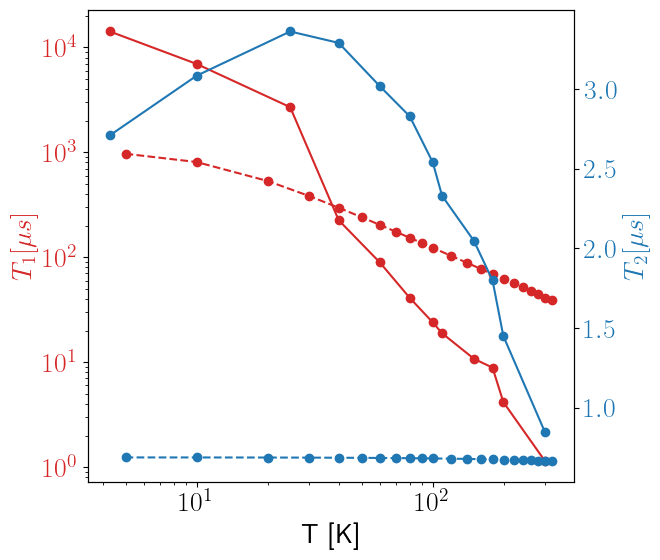

In [52]:
# adding the experimental data
t1exp = np.array([14163.72734, 6951.95423, 2691.61351,225.3970881,89.17022735,41.0253116,23.92805806,18.87486711,10.77391862,
                  8.873229094,4.171377424,1.143754573])
t2exp = np.array([2.709966603,3.084314127,3.362185823,3.290454844,3.018511437,2.829407455,2.540192367,2.330255261,2.047428917,
                  1.798929603,1.449961246, 0.84569149])
temp_exp = np.array([4.292624643, 9.998683733, 24.90051857, 39.95789327, 59.68654518, 79.87897033, 99.98683733, 109.4868393, 
                     149.3539422, 179.0832077, 198.9289628, 298.5702735])

t1_list_345mT = np.load('saved variables/t1_list_345mT.npy')
t1d_list_345mT = np.load('saved variables/t1d_list_345mT.npy')

#t2_list_345mT = np.load('t2_list_345mT.npy')
#t2d_list_345mT = np.load('t2d_list_345mT.npy')
t2_list_345mT = np.load('saved variables/t2_list.npy')
t2d_list_345mT = np.load('saved variables/t2d_list.npy')



fig, ax1 = plt.subplots(figsize=(7,6))

color = 'tab:red'
ax1.set_xlabel('T [K]')
ax1.set_xscale('log')
ax1.set_ylabel(r"$T_1 [\mu s]$", color=color)
ax1.set_yscale('log')
ax1.plot(Temp_list, t1_list_345mT,'--o', color=color)
ax1.plot(temp_exp, t1exp, '-o', color=color)
ax1.tick_params(axis='y', labelcolor=color)


ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel(r"$T_2[\mu s]$", color=color)  # we already handled the x-label with ax1
#ax2.set_yscale('log')
ax2.plot(Temp_list, t2_list_345mT, '--o',color=color)
ax2.plot(temp_exp, t2exp, '-o', color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()


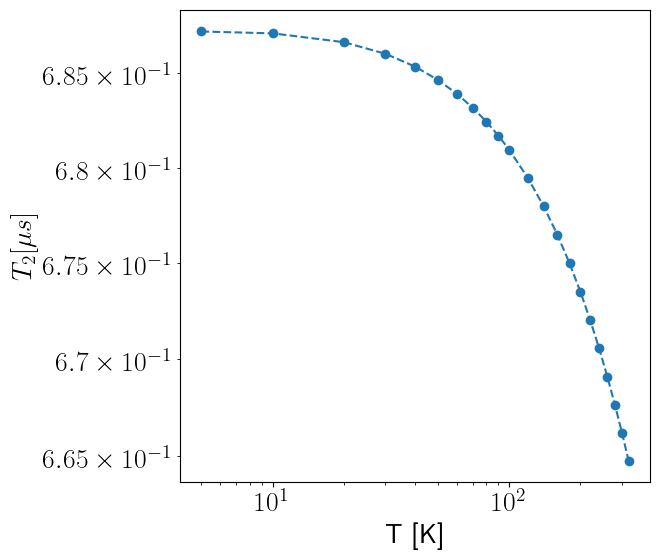

In [75]:
fig, ax1 = plt.subplots(figsize=(7,6))

#color = 'tab:blue'
ax1.set_xlabel('T [K]')
ax1.set_xscale('log')
ax1.set_ylabel(r"$T_2 [\mu s]$")#, color=color)
ax1.set_yscale('log')
ax1.plot(Temp_list, t2_list_345mT,'--o')#, color=color)
#ax1.plot(temp_exp, t2exp, '-o')#, color=color)
ax1.tick_params(axis='y')#, labelcolor=color)
#ax1.legend(['Simulation','Experiment'])
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

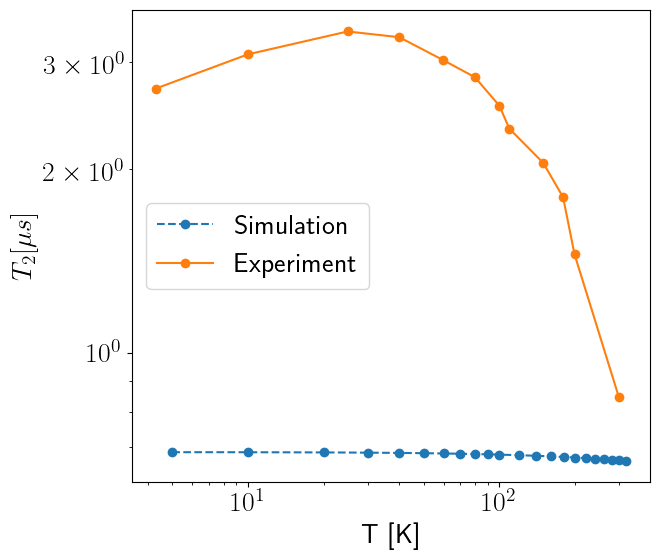

In [76]:
fig, ax1 = plt.subplots(figsize=(7,6))

#color = 'tab:blue'
ax1.set_xlabel('T [K]')
ax1.set_xscale('log')
ax1.set_ylabel(r"$T_2 [\mu s]$")#, color=color)
ax1.set_yscale('log')
ax1.plot(Temp_list, t2_list_345mT,'--o')#, color=color)
ax1.plot(temp_exp, t2exp, '-o')#, color=color)
ax1.tick_params(axis='y')#, labelcolor=color)
ax1.legend(['Simulation','Experiment'])
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()


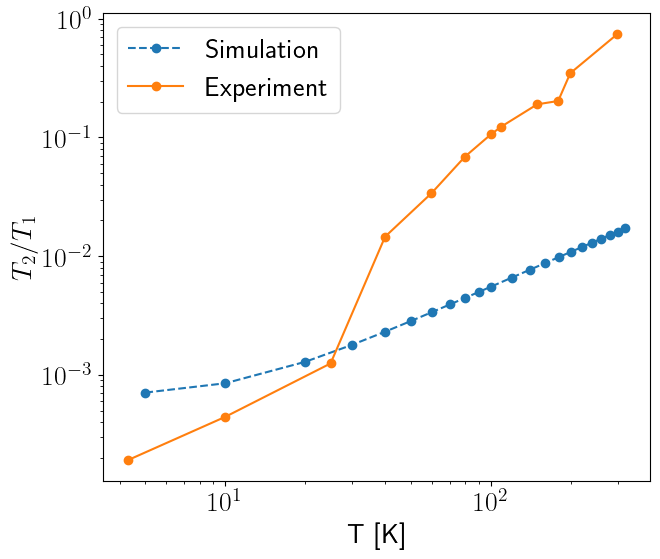

In [77]:
fig, ax1 = plt.subplots(figsize=(7,6))

#color = 'tab:green'
ax1.set_xlabel('T [K]')
ax1.set_xscale('log')
ax1.set_ylabel(r"$T_2/T_1$")#, color=color)
ax1.set_yscale('log')
ax1.plot(Temp_list, [t2_list_345mT[i]/t1_list_345mT[i] for i in range(len(Temp_list))],'--o')#, color=color)
ax1.plot(temp_exp, [t2exp[i]/t1exp[i] for i in range(len(temp_exp))] , '-o')#, color=color)
ax1.tick_params(axis='y')#, labelcolor=color)
ax1.legend(['Simulation','Experiment'])
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

# SVD Mode projection

In [24]:
# performing SVD, 
gcoupTest = np.zeros((Np, 3),dtype=float) # defining a place holder for couplings
for k in range(Np):
    for j in range(3):
        gcoupTest[k,:] += alpha * dgx[k,:,j] * Bvector[j] * (1/2) * np.sqrt(hbar/(2*freq[k]/hbar))# only thing missing from here is Pauli matrix. Everything else is contained.
        #therefore, couplings will have units of energy as meV

U, L, Vdag = LA.svd(gcoupTest, full_matrices=False)  # note: the output of this funciton is U*S*Vh
print('\n singular values are ', L)

# Collecting columns of U that correspond to non-zero singular values
threshold = 1.e-12
Lnonzero = np.where(L > threshold)[0] # indices where the singular value is non-zero
Np_new = len(Lnonzero)  # total nonzero singular values

print('\n indices of non-zero singular values=', Lnonzero)
print('\n number of non-zeor singular values=', Np_new)

Usys = U[:,Lnonzero]
print('shape of Usys', np.shape(Usys))

# defining projection operators with the SVD Usys
A = Qobj(Usys)
#A = Qobj(gcoupS) # regular mode projection
P = A*(A.dag()*A).inv()*A.dag()
I = qeye(Np)
Q = I-P

print('shape of projection operator is ', np.shape(P))

Omega = Qobj(np.diag(freq**2)) # Hessian
Omega_s = P*Omega*P
Omega_b = Q*Omega*Q
val_s, vecs_s = Omega_s.eigenstates()
val_b, vecs_b = Omega_b.eigenstates()

Pnonzero = np.where(val_s > 1.e-9)[0]
Qnonzero = np.where(val_b > 1.e-9)[0]

# collecting nonzero-eigenvalues^0.5 of omega_s and omega_b
omega_s = np.real(np.sqrt(val_s[Pnonzero]))
omega_b = np.real(np.sqrt(val_b[Qnonzero]))
Ks = vecs_s[Pnonzero]
Kb = vecs_b[Qnonzero]

ns = len(Pnonzero)
nb = len(Qnonzero)
print('\n number of sys  phonon mode =', len(Pnonzero))
print('\n number of bath phonon mode =', len(Qnonzero))
print('With SVD mode projection, system modes cm-1 = ', omega_s/cm2mev)
print('With SVD mode projection, system modes meV = ', omega_s)
#print('system modes**2 cm-1 = ', omega_s**2/cm2mev)
#print('system modes**2 meV = ', omega_s**2)


 singular values are  [3.10975093e-05 1.93143530e-05 1.09395332e-05]

 indices of non-zero singular values= [0 1 2]

 number of non-zeor singular values= 3
shape of Usys (190, 3)
shape of projection operator is  (190, 190)

 number of sys  phonon mode = 3

 number of bath phonon mode = 187
With SVD mode projection, system modes cm-1 =  [170.05228774 352.20783648 533.98046135]
With SVD mode projection, system modes meV =  [21.08379664 43.6682064  66.20513965]


In [25]:
# Entropy of the projected system modes.import numpy as np
from scipy.stats import entropy

pk0 = np.squeeze(Ks[0].full().real)**2
pk1 = np.squeeze(Ks[1].full().real)**2
pk2 = np.squeeze(Ks[2].full().real)**2

print(entropy(pk0, base=np.e), entropy(pk1, base=np.e), entropy(pk2, base=np.e))

1.9636275846559728 3.224787498040543 3.4235869406112407


In [26]:
one_hot_basis = np.zeros(len(freq))
one_hot_basis[0] = 1
entropy(one_hot_basis, base=np.e)

0.0

In [27]:
veclist = np.hstack((Ks,Kb))
gnewX = np.real(np.squeeze( (Qobj(gcoupS[:,0]).transform(veclist)).full()[:ns] ))
gnewY = np.real(np.squeeze( (Qobj(gcoupS[:,1]).transform(veclist)).full()[:ns] ))
gnewZ = np.real(np.squeeze( (Qobj(gcoupS[:,2]).transform(veclist)).full()[:ns] ))
# note: I have taken real parts only after inspecting that the imaginary parts are zeros.
print(gnewX, gnewY, gnewZ)

[ 8.82128840e-05  1.60675426e-04 -8.18859304e-05] [ 3.24822206e-05 -9.34571237e-05  3.95482160e-05] [6.11788430e-05 8.25845475e-05 1.59819524e-04]


In [28]:
L = P*Omega*Q + Q*Omega*P
newL = L.transform(veclist).tidyup(atol=1e-6)
newL

Quantum object: dims = [[190], [190]], shape = (190, 190), type = oper, isherm = True
Qobj data =
[[    0.             0.             0.         ...   549.88490675
  -2034.69847177  1522.66222051]
 [    0.             0.             0.         ...  1490.49011054
  -2239.24944268  2708.59015384]
 [    0.             0.             0.         ... -2236.99445614
   -622.16677135  -311.7531786 ]
 ...
 [  549.88490675  1490.49011054 -2236.99445614 ...     0.
      0.             0.        ]
 [-2034.69847177 -2239.24944268  -622.16677135 ...     0.
      0.             0.        ]
 [ 1522.66222051  2708.59015384  -311.7531786  ...     0.
      0.             0.        ]]

In [29]:
gamma_prime = np.real(newL.full()[:ns,ns:]) # the first index for gamma prime is for system phonon and second for bath phonon
Qobj(gamma_prime)

Quantum object: dims = [[3], [187]], shape = (3, 187), type = oper, isherm = False
Qobj data =
[[ 1.25245512e+00  2.01676996e-01 -7.55676323e+00  1.26396849e+01
  -1.06638983e+01 -4.07620893e+00  5.30714920e-01  2.28432553e+00
  -1.54530484e+01 -1.41383183e+01 -5.28414760e+01 -5.81306147e+00
  -6.43523092e+00  3.43067280e+00 -2.90683993e+00 -2.68904638e+01
   1.03843422e+01  4.22661752e+01 -2.57163980e+01 -6.45645892e+00
   6.89781642e+01 -1.81670128e+01  4.72324934e+01 -7.67600442e+01
   8.76288022e+00  1.98548325e+01 -9.37287173e+01 -1.17242136e+02
  -2.06376037e+00  5.46760703e+01 -3.91504433e+01 -1.47972821e+01
   1.17556153e+02 -4.49086182e+01  2.02239802e+02 -8.90743468e+01
   1.33032512e+02  1.93765289e+01 -2.74575291e+00 -8.22198882e+01
   6.06604327e+01 -2.07704634e+01 -1.23854026e+02 -3.72611166e+00
   4.28600784e+01 -2.94093707e+01 -6.34802073e+01  2.04166519e+02
   3.03149955e+01 -3.76336942e+01  1.44705364e+02  5.01948130e+01
  -2.33943854e+02  6.91401598e+00  1.62251591e+

In [30]:
omega_s/cm2mev

array([170.05228774, 352.20783648, 533.98046135])

## Analysis of projected modes

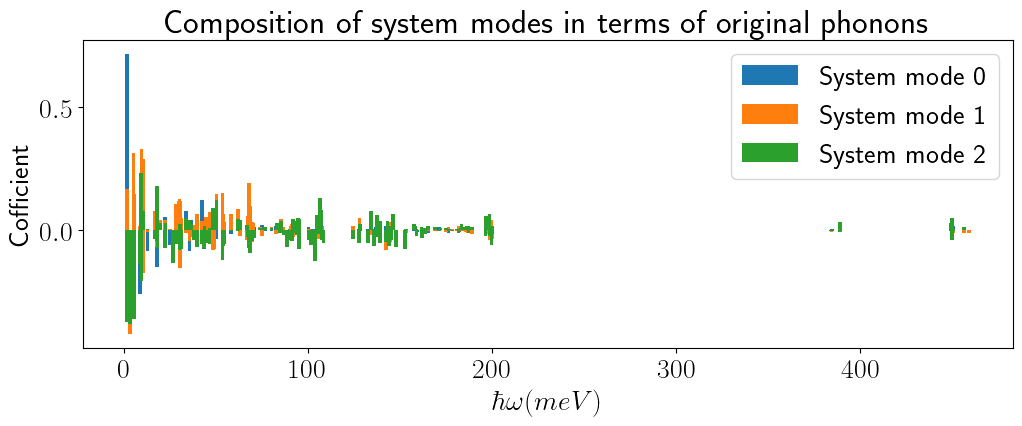

In [31]:
plt.figure(figsize=(12,4))
for i in range(len(Ks)):
    plt.bar(freq,np.squeeze(Ks[i].full().real), width=2)

plt.title(r"Composition of system modes in terms of original phonons")
plt.xlabel(r"$\hbar \omega (meV)$")
plt.ylabel(r"Cofficient")
#plt.yscale('log')
plt.legend(['System mode 0','System mode 1','System mode 2'])
plt.show()

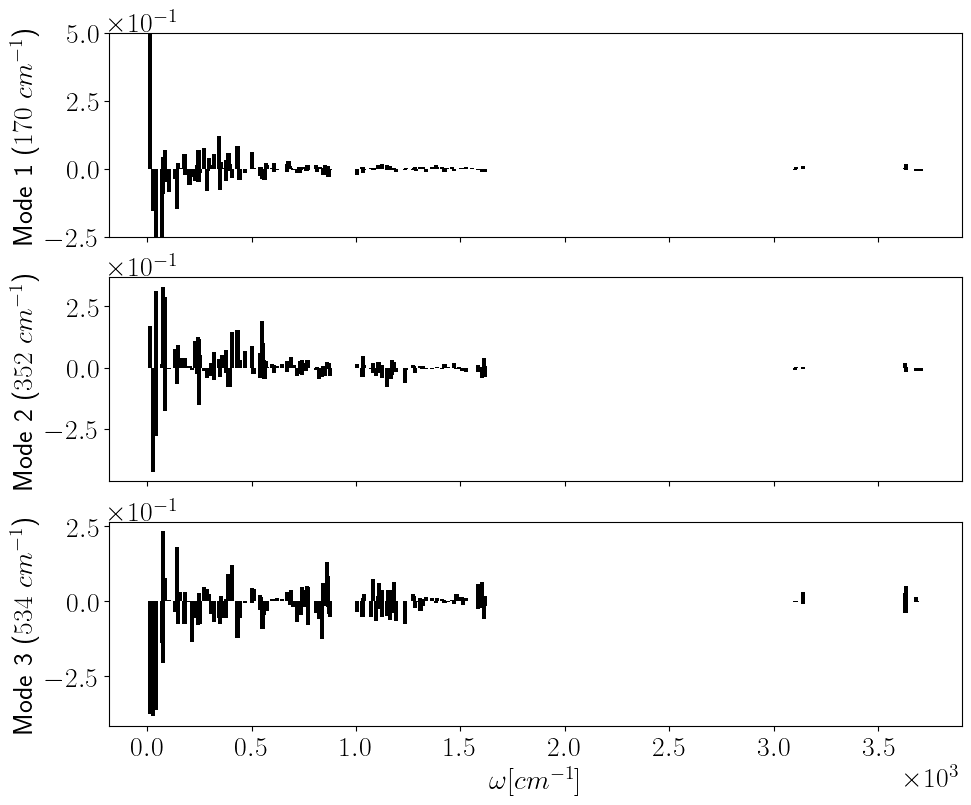

In [75]:
plt.rcParams['text.usetex'] = True 
plt.rcParams["axes.formatter.limits"]=(0,0)
plt.rcParams.update({'font.size': 20})

#fig, axs = plt.subplots(3, sharex=True)
fig, axs = plt.subplots(3,1,figsize=(11,9),sharex=True, gridspec_kw={'height_ratios': [1, 1,1]})
#fig = plt.figure(figsize=(7, 9))
#gs = fig.add_gridspec(3, hspace=0)
#axs = gs.subplots(sharex=True, sharey=False)

color = 'tab:blue'
axs[0].set_xlabel(r"$\omega [cm^{-1}]$")
axs[0].set_ylabel(r"Mode 1 ($170\ cm^{-1}$)", color='k')
axs[0].set_ylim([-0.250, 0.5])
axs[0].bar(freq/cm2mev,np.squeeze(Ks[0].full().real), width=20, color='k')
#axs[0].fill_between(xspec/cm2mev, np.array(yspec), 0, color='blue', alpha=.1)
axs[0].tick_params(axis='y', labelcolor='k')

#ax2 = axs[0].twinx()  # instantiate a second axes that shares the same x-axis

#color = 'tab:red'
#ax2.set_ylabel(r"$|\partial g_{zz}/\partial \hat x_k|$", color=color)  # we already handled the x-label with ax1
#ax2.set_yscale('log')
#ax2.bar(freq[:highfreq]/cm2mev, gnorm, width=2.5, color=color)
#ax2.tick_params(axis='y', labelcolor=color)
#ax2.set_ylim([0, 10])


#############


color = 'tab:blue'
axs[1].set_xlabel(r"$\omega [cm^{-1}]$")
axs[1].set_ylabel(r"Mode 2 ($352\ cm^{-1}$)", color='k')
#axs[1].set_ylim([0, 5])
axs[1].bar(freq/cm2mev,np.squeeze(Ks[1].full().real), width=20, color='k')
#axs[1].fill_between(xspec/cm2mev, np.array(yspec), 0, color='blue', alpha=.1)
axs[1].tick_params(axis='y', labelcolor='k')

#ax2 = axs[1].twinx()  # instantiate a second axes that shares the same x-axis

#color = 'tab:red'
#ax2.set_ylabel(r"$|\partial g_{yz}/\partial \hat x_k|$", color=color)  # we already handled the x-label with ax1
#ax2.set_yscale('log')
#ax2.bar(freq[:highfreq]/cm2mev, gnorm, width=2.5, color=color)
#ax2.tick_params(axis='y', labelcolor=color)
#ax2.set_ylim([0, 10])


#############

color = 'tab:blue'
axs[2].set_xlabel(r"$\omega [cm^{-1}]$")
axs[2].set_ylabel(r"Mode 3 ($534\ cm^{-1}$)", color='k')
#axs[2].set_ylim([0, 5])
axs[2].bar(freq/cm2mev,np.squeeze(Ks[2].full().real), width=20, color='k')
#axs[2].fill_between(xspec/cm2mev, np.array(yspec), 0, color='blue', alpha=.1)
axs[2].tick_params(axis='y', labelcolor='k')

#ax2 = axs[2].twinx()  # instantiate a second axes that shares the same x-axis

#color = 'tab:red'
#ax2.set_ylabel(r"$|\partial g_{xz}/\partial \hat x_k|$", color=color)  # we already handled the x-label with ax1
#ax2.set_yscale('log')
#ax2.bar(freq[:highfreq]/cm2mev, gnorm, width=2.5, color=color)
#ax2.tick_params(axis='y', labelcolor=color)
#ax2.set_ylim([0, 10])


# Hide x labels and tick labels for all but bottom plot.
for ax in axs:
    ax.label_outer()

In [34]:
# printing out projected modes
np.save('projected_mode_0', np.squeeze(Ks[0].full().real))
np.save('projected_mode_1', np.squeeze(Ks[1].full().real))
np.save('projected_mode_2', np.squeeze(Ks[2].full().real))

In [ ]:
def write_normalmode_xsf(coords, normal_modes, printlist, Usys=None):
    from periodictable import elements
    nats = len(coords)
    
    if Usys is not None:
        nmode, nsys = Usys.shape

    for k in printlist:
        if Usys is None:
            output = open('xsf/normalmode_%d.xsf'%k,'w')
            vec = normal_modes[k]
        else:
            output = open('xsf/proj_normalmode_%d.xsf'%k,'w')
            vec = np.zeros(3*nats)
            for i in range(nmode):
                vec += normal_modes[i] * Usys[i,k].real
        output.write("ATOMS\n")

        j = 0 
        for i in range(nats):
            symbol = coords[i][0]
            artnumber = elements.symbol(symbol).number
            vx = vec[j]
            vy = vec[j+1]
            vz = vec[j+2]
            j += 3
            output.write("{}  {}  {}  {} {}  {}  {}\n".format(artnumber, coords[i][1],coords[i][2],coords[i][3], vx, vy, vz))
        output.close()


def get_modes2(fname,fgeo,nmode=None):

    # load coordinates
    logdata = open(fgeo).readlines()
    nats = int(logdata[0])
    coords = []
    for i in range(2,2+nats):
        xyz = logdata[i].split()
        #print(xyz)
        coords.append(xyz)

    logdata = open(fname).readlines()
    logdata = logdata[1:]

    normal_modes = np.zeros((nmode,3*nats))
    for i in range(nmode):
        j = i*5 + 1
        line = logdata[j]
        mode_vec = line.split()
        mode_vec = np.array(mode_vec)
        mode_vec = mode_vec.astype(float)
        normal_modes[i,:] = mode_vec
    
    return coords, normal_modes




fgeo = 'optimized.xyz'
fname0 = 'spin_phonon_bare.dat'
coords, normal_modes = get_modes2(fname0,fgeo,nmode=len(freq))
usysTest = np.squeeze(np.array([Ks[0].full(), Ks[1].full(),Ks[2].full()])).transpose()
write_normalmode_xsf(coords, normal_modes, range(len(omega_s)), usysTest )

In [ ]:
np.squeeze(np.array([Ks[0].full(), Ks[1].full(),Ks[2].full()])).transpose().shape

### Spectral Densities of projected and bath modes

In [78]:
Temp = 300

In [79]:
def spectral_density_coupled_modes_classical(w, gcoup, gamma_coup, omega_s, omega_b, T=10, sigma=2):
    '''
    Generates spectral density of system modes affecting the spin system. The system modes are coupled to the bath
    modes. The units of gcoup, gamma_coup, omega_s and omega_b should all be energy.
    The units of spectral density are Eng^2 s. Therefore, division by hbar^2 must be done afterwards.
    '''
    kB = 8.6173e-2 # meV/K, Boltzmann constant
    #gamma = 2 # dampng meV
    S = 0

    for r in range(len(omega_s)):
        for rp in range(len(omega_s)):
            wr = omega_s[r]/hbar # freq of system phonon r
            wrp = omega_s[rp]/hbar # freq of system phonon rp
            cr = gcoup[r]/(np.sqrt(hbar/wr)) # energy / length
            crp = gcoup[rp]/(np.sqrt(hbar/wrp)) # energy / length

            for j in range(len(omega_b)):
                wj = omega_b[j]/hbar # freq of bath phonons
                gamma = sigma #0.2*wj # dampng rate = 20 % of mode frequency
                grj = gamma_coup[r,j]/( np.sqrt(hbar/wr)*np.sqrt(hbar/wj) ) # energy/length^2
                grpj = gamma_coup[rp, j]/( np.sqrt(hbar/wrp)*np.sqrt(hbar/wj) )# energy/length^2
                factor1 = (wj**2 - w**2)**2 + (gamma**2)*(w**2)
                factor2 = (wr**2-w**2)*(wrp**2-w**2)
                S += (cr*crp)*(grj*grpj)*(2*gamma*kB*T)/(factor1*factor2)
                #S += (2*gamma*kB*T)/(factor1*factor2)
    return S

In [80]:
gnewX, gnewY, gnewZ

(array([ 8.82128840e-05,  1.60675426e-04, -8.18859304e-05]),
 array([ 3.24822206e-05, -9.34571237e-05,  3.95482160e-05]),
 array([6.11788430e-05, 8.25845475e-05, 1.59819524e-04]))

In [86]:
x = np.linspace(0,freq[-1], 1000)
yX = [spectral_density_coupled_modes_classical(x/hbar,gnewX,gamma_prime,omega_s, omega_b, T=Temp)/hbar**2 for x in x]
yY = [spectral_density_coupled_modes_classical(x/hbar,gnewY,gamma_prime,omega_s, omega_b, T=Temp)/hbar**2 for x in x]
yZ = [spectral_density_coupled_modes_classical(x/hbar,gnewZ,gamma_prime,omega_s, omega_b, T=Temp)/hbar**2 for x in x]


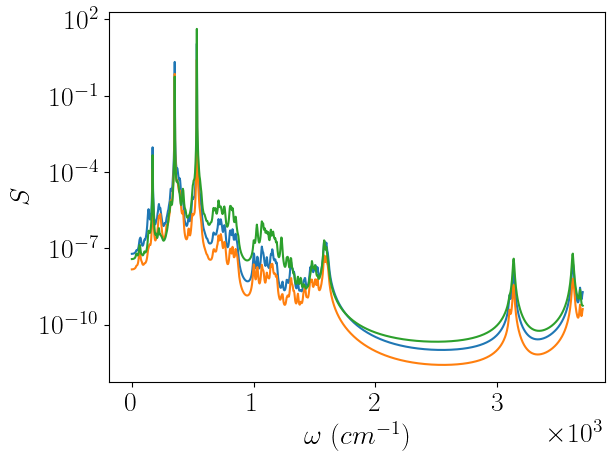

In [87]:
plt.figure()
plt.plot(x/cm2mev,yX)
plt.plot(x/cm2mev,yY)
plt.plot(x/cm2mev,yZ)
#plt.plot(omega_s/cm2mev, [spectral_density_coupled_modes_classical(x/hbar,gnewX,gamma_prime,omega_s, omega_b, Temp) for x in omega_s[:165]], 'x')
#plt.plot(omega_b[:165]/cm2mev, [spectral_density_coupled_modes_classical(x/hbar,gnewX,gamma_prime,omega_s, omega_b, Temp) for x in omega_b[:165]], '.')
plt.yscale('log')
plt.ylabel(r"$S$")
plt.xlabel(r"$\omega\ (cm^{-1})$")
#plt.legend([r"$\sigma_x$", r"$\sigma_y$", r"$\sigma_z$"])
plt.show()

In [83]:
gamma_prime[2,:].shape

(187,)

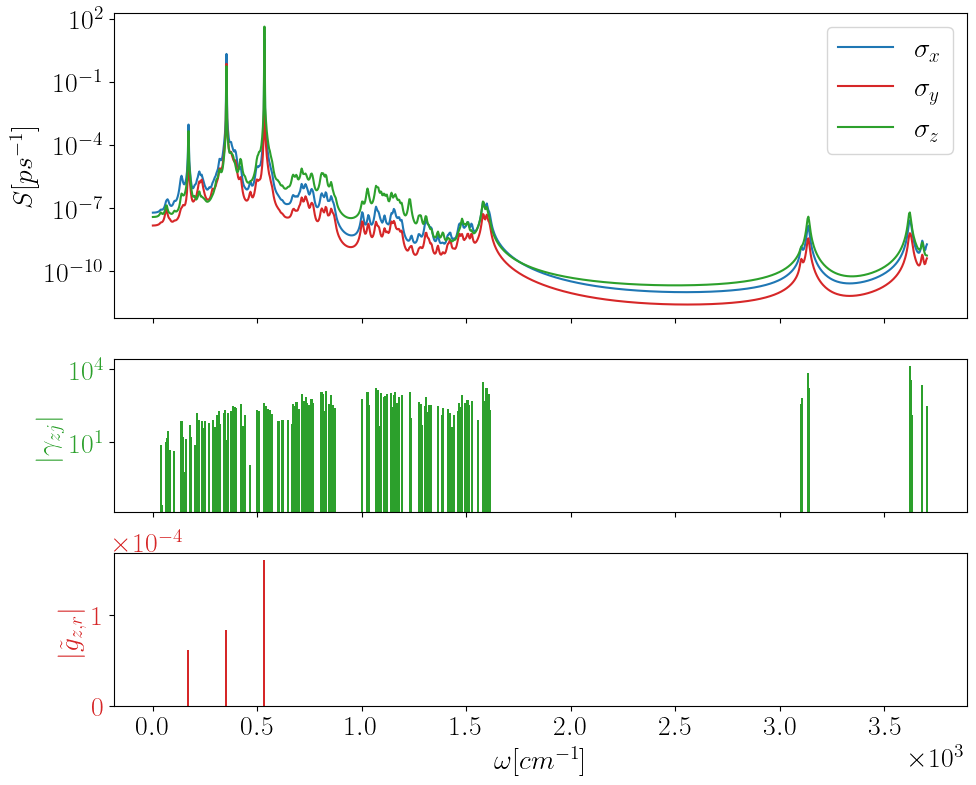

In [96]:
plt.rcParams['text.usetex'] = True 
plt.rcParams["axes.formatter.limits"]=(0,0)
plt.rcParams.update({'font.size': 20})

#fig, axs = plt.subplots(3, sharex=True)
fig, axs = plt.subplots(3,1,figsize=(11,9),sharex=True, gridspec_kw={'height_ratios': [2, 1, 1]})
#fig = plt.figure(figsize=(7, 9))
#gs = fig.add_gridspec(3, hspace=0)
#axs = gs.subplots(sharex=True, sharey=False)


color = 'tab:blue'
axs[0].set_xlabel(r"$\omega [cm^{-1}]$")
axs[0].set_ylabel(r"$S [ps^{-1}]$")
#axs[0].set_ylim([0, 5])
axs[0].plot(x/cm2mev,np.array(yX),color='tab:blue')
axs[0].plot(x/cm2mev,np.array(yY),color='tab:red')
axs[0].plot(x/cm2mev,np.array(yZ),color='tab:green')
#axs[0].fill_between(x/cm2mev, np.array(yZ), 0, color='blue', alpha=.1)
#axs[0].tick_params(axis='y', labelcolor=color)
axs[0].set_yscale('log')
axs[0].legend([r"$\sigma_x$", r"$\sigma_y$", r"$\sigma_z$"])

#ax2 = axs[0].twinx()  # instantiate a second axes that shares the same x-axis

#color = 'tab:red'
#ax2.set_ylabel(r"$|\gamma_{z,j}|$", color=color)  # we already handled the x-label with ax1
#ax2.set_yscale('log')
#ax2.bar(omega_b/cm2mev, np.abs(gamma_prime[2,:]), width=10, color=color)
#ax2.tick_params(axis='y', labelcolor=color)
#ax2.set_yscale('log')

#ax2.bar(omega_s/cm2mev, np.abs(gnewZ), width=10, color='tab:black')
#############

color = 'tab:green'
axs[1].set_xlabel(r"$\omega [cm^{-1}]$")
axs[1].set_ylabel(r"$|\gamma_{zj}|$", color=color)
#axs[0].set_ylim([0, 5])
axs[1].bar(omega_b/cm2mev, np.abs(gamma_prime[2,:]), width=10, color=color)
axs[1].tick_params(axis='y', labelcolor=color)
axs[1].set_yscale('log')

##############################


color = 'tab:red'
axs[2].set_xlabel(r"$\omega [cm^{-1}]$")
axs[2].set_ylabel(r"$|\tilde{g}_{z,r}|$", color=color)
#axs[0].set_ylim([0, 5])
axs[2].bar(omega_s/cm2mev, np.abs(gnewZ), width=10, color=color)
axs[2].tick_params(axis='y', labelcolor=color)
#axs[2].set_yscale('log')
# Hide x labels and tick labels for all but bottom plot.
for ax in axs:
    ax.label_outer()

In [ ]:
spectral_density_classical(w_split/hbar, freqs=freq, coup=gcoupS[:,2], T=5, sigma=2)/hbar**2

In [ ]:
spectral_density_coupled_modes_classical(w_split/hbar,gnewZ,gamma_prime,omega_s, omega_b, T=5)/hbar**2

In [ ]:
y = np.linspace(0,freq[-1], 1000)
#yX = [spectral_density_coupled_modes_classical(x/hbar,gnewX,gamma_prime,omega_s, omega_b, T=Temp) for x in x]
#yY = [spectral_density_coupled_modes_classical(x/hbar,gnewY,gamma_prime,omega_s, omega_b, T=Temp) for x in x]
xZ = [spectral_density_coupled_modes_classical(y/hbar,gnewZ,gamma_prime,omega_s, omega_b, T=Temp) for y in y]


In [ ]:
## NOTE: need to add the movies of these modes from orca.

In [ ]:
print(gamma_prime.shape, gnewX.shape)

# Spin dyanmics after Mode Projection

### Method 4

Using Refield dyanmics wiht coupled oscillator spectral density

In [ ]:
1/np.pi

In [ ]:
np.sqrt(np.pi)

In [ ]:
np.sqrt(2/np.pi)

In [ ]:
np.sqrt(np.pi/2)

In [97]:
# Temperature Scan, multiple runs
Temp_list = [5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 120, 140, 160, 180, 200, 220, 240, 260, 280, 300, 320]
tlist = np.linspace(1, 3000e6, 1000) # in ps

In [ ]:
t1_list_coupled = np.array([])
t1d_list_coupled = np.array([])

rho0 = basis(2,0)*basis(2,0).dag()
e_ops = []
rho_list = []

for k in range(len(Temp_list)):
    temp = Temp_list[k]
    specDensityX = lambda w : 1.35*spectral_density_coupled_modes_classical(w,gnewX,gamma_prime,omega_s, omega_b, T=temp, sigma=2)/hbar**2
    specDensityY = lambda w : 1.35*spectral_density_coupled_modes_classical(w,gnewY,gamma_prime,omega_s, omega_b, T=temp, sigma=2)/hbar**2
    specDensityZ = lambda w : 1.35*spectral_density_coupled_modes_classical(w,gnewZ,gamma_prime,omega_s, omega_b, T=temp, sigma=2)/hbar**2
    
    #specDensityX = lambda w : spectral_density_classical(w, freqs=omega_s, coup=gnewX, T=temp, sigma=2)/hbar**2
    #specDensityY = lambda w : spectral_density_classical(w, freqs=omega_s, coup=gnewY, T=temp, sigma=2)/hbar**2
    #specDensityZ = lambda w : spectral_density_classical(w, freqs=omega_s, coup=gnewZ, T=temp, sigma=2)/hbar**2
    
    
    aops = [[sigmax(),specDensityX], [sigmay(),specDensityY], [sigmaz(),specDensityZ]]
    
    print("temperature ", temp)
    results_k = brmesolve(H/(hbar), rho0, tlist, a_ops=aops, e_ops=e_ops)
    rho_list.append(results_k.states) # saving states for later
    rho11_k = np.array([results_k.states[j].full()[0,0] for j in range(len(tlist))]) # first element of rho vs time 
    t1, t1d = curve_fit(t1_func_classical, tlist/1e6, np.abs(rho11_k))
    t1_list_coupled = np.append(t1_list_coupled, t1)
    t1d_list_coupled = np.append(t1d_list_coupled, t1d)


np.save('saved variables/t1_list_coupled', t1_list_coupled)
np.save('saved variables/t1d_list_coupled', t1d_list_coupled)
print(t1_list_coupled)  

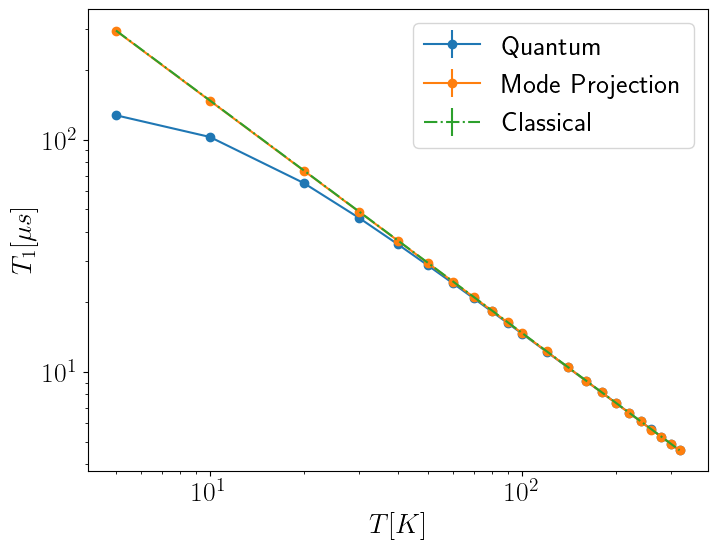

In [98]:
t1_list_coupled = np.load('saved variables/t1_list_coupled.npy')
t1d_list_coupled = np.load('saved variables/t1d_list_coupled.npy')
t1_list = np.load('saved variables/t1_list.npy')
t1d_list = np.load('saved variables/t1d_list.npy')
t1_list_classical = np.load('saved variables/t1_list_classical.npy')
t1d_list_classical = np.load('saved variables/t1d_list_classical.npy')

plt.figure(figsize=(8,6))
plt.errorbar(Temp_list, t1_list, yerr = t1d_list, fmt='-o')
plt.errorbar(Temp_list, t1_list_coupled, yerr = t1d_list_coupled, fmt='-o')
plt.errorbar(Temp_list, t1_list_classical, yerr = t1d_list_classical, fmt='-.')
plt.xscale('log')
plt.yscale('log')
#plt.title(r"$T_1$ as a function of temperature for single molecule")
plt.legend([r"Quantum", r"Mode Projection",r"Classical"])
plt.xlabel(r"$T [K]$")
plt.ylabel(r"$T_1 [\mu s]$")
plt.show()

In [ ]:
#t1_list_coupled = np.load('saved variables/t1_list_coupled.npy')
#t1d_list_coupled = np.load('saved variables/t1d_list_coupled.npy')
t1_list = np.load('saved variables/t1_list.npy')
t1d_list = np.load('saved variables/t1d_list.npy')
#t1_list_classical = np.load('saved variables/t1_list_classical.npy')
#t1d_list_classical = np.load('saved variables/t1d_list_classical.npy')

plt.figure(figsize=(8,6))
plt.errorbar(Temp_list, t1_list, yerr = t1d_list, fmt='-o')
plt.errorbar(Temp_list, t1_list_coupled, yerr = t1d_list_coupled, fmt='-o')
plt.errorbar(Temp_list, t1_list_classical, yerr = t1d_list_classical, fmt='-o')
plt.xscale('log')
plt.yscale('log')
#plt.title(r"$T_1$ as a function of temperature for single molecule")
plt.legend([r"Quantum", r"Mode Projection",r"Classical"])
plt.xlabel(r"$T [K]$")
plt.ylabel(r"$T_1 [\mu s]$")
plt.show()

In [ ]:
rho0 = basis(2,0)*basis(2,0).dag()
e_ops = []
specDensityX = lambda w : 1*spectral_density_coupled_modes_classical(w,gnewX,gamma_prime,omega_s, omega_b, T=temp)/hbar**2
specDensityY = lambda w : 1*spectral_density_coupled_modes_classical(w,gnewY,gamma_prime,omega_s, omega_b, T=temp)/hbar**2
specDensityZ = lambda w : 1*spectral_density_coupled_modes_classical(w,gnewZ,gamma_prime,omega_s, omega_b, T=temp)/hbar**2
aops = [[sigmax(),specDensityX], [sigmay(),specDensityY], [sigmaz(),specDensityZ]]
    

results_k = brmesolve(H/(hbar), rho0, tlist, a_ops=aops, e_ops=e_ops)
rho11_k = np.array([results_k.states[j].full()[0,0] for j in range(len(tlist))]) # first element of rho vs time 
t1, t1d = curve_fit(t1_func, tlist/1e6, np.abs(rho11_k))

print(t1, t1d)


#### T2 with mode projection

In [ ]:
# Temperature Scan 


tlist_t2 = np.linspace(1, 3e6, 10000) # in ps
rho0 = basis(2,0)*basis(2,1).dag()

t2_list_coupled = np.array([])
t2d_list_coupled = np.array([])

e_ops = []
rho_list = []

for k in range(len(Temp_list)):
    
    temp = Temp_list[k]
    print("calculating t2 for ",temp, " K")
    
    specDensityX = lambda w : 1*spectral_density_coupled_modes_classical(w,gnewX,gamma_prime,omega_s, omega_b, T=temp)/hbar**2
    specDensityY = lambda w : 1*spectral_density_coupled_modes_classical(w,gnewY,gamma_prime,omega_s, omega_b, T=temp)/hbar**2
    specDensityZ = lambda w : 1*spectral_density_coupled_modes_classical(w,gnewZ,gamma_prime,omega_s, omega_b, T=temp)/hbar**2
    aops = [[sigmax(),specDensityX], [sigmay(),specDensityY], [sigmaz(),specDensityZ]]
    
    results_k = brmesolve(H/(hbar), rho0, tlist_t2, a_ops=aops, e_ops=e_ops)#, progress_bar=True)
    rho_list.append(results_k.states) # saving states for later
    rho12_k = np.array([results_k.states[j].full()[0,1] for j in range(len(tlist_t2))]) # first element of rho vs time 
    t2, t2d = curve_fit(t2_func, tlist_t2/1e6, np.abs(rho12_k))
    t2_list_coupled = np.append(t2_list_coupled, t2)
    t2d_list_coupled = np.append(t2d_list_coupled, t2d)


np.save('t2_list_coupled', t2_list_coupled)
np.save('t2d_list_coupled', t2d_list_coupled)
print(t2_list_coupled)  

rho12_vals = np.array([rho_list[-1][m].full()[0,1] for m in range(len(tlist_t2))])
rho21_vals = np.array([rho_list[-1][m].full()[1,0] for m in range(len(tlist_t2))])
fit = np.array([t2_func(k,t2_list[-1])  for k in tlist_t2/1e6])

plt.figure()
plt.plot(tlist_t2/1e6, np.abs(rho12_vals))
plt.plot(tlist_t2/1e6, np.abs(rho21_vals))
plt.plot(tlist_t2/1e6, fit)
plt.xlabel(r"Time ($\mu s$)")
plt.ylabel(r"$\rho$")
plt.title("Evolution of density matrix elements at "+str(Temp_list[-1])+"K , T2="+str(np.round(t2_list[-1],3)))
plt.legend([r"$\rho_{12}$", r"$\rho_{21}$", "fit"])
plt.show()

### Comparison with trivial cutoff

In [ ]:
# defining cutoff modes
def cutoff(gcoup, tol, freq):
    counter = 0
    gcoup_out = copy.deepcopy(gcoup)
    for i in range(len(gcoup)):   
        if np.abs(gcoup[i])<tol:
            gcoup_out[i] = 0
            counter += 1
        else:
            print("mode ", freq[i]/cm2mev, "with coupling ", gcoup[i], " passed")
    print('modes cut ', counter, ' , remaining', len(gcoup)-counter)
    return gcoup_out

In [ ]:
tol = np.max(gcoupS)*0.5# setting cutoff tolerance at 8% of max value
print("coupling through sigma X ")
gcoup_cut0 = cutoff(gcoupS[:,0], tol, freq)

print("coupling through sigma Y ")
gcoup_cut1 = cutoff(gcoupS[:,1], tol, freq)

#tol = np.max(gcoupS)*0.9
print("coupling through sigma Z ")
gcoup_cut2 = cutoff(gcoupS[:,2], tol, freq)

In [ ]:
freq[0]/cm2mev

In [ ]:
Temp_list = [5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 120, 140, 160, 180, 200, 220, 240, 260, 280, 300, 320]
tlist = np.linspace(1, 300e6, 1000) # in ps

In [ ]:
t1_list_cut_classical = np.array([])
t1d_list_cut_classical = np.array([])

rho0 = basis(2,0)*basis(2,0).dag()
e_ops = []
rho_list = []

for k in range(len(Temp_list)):
    temp = Temp_list[k]
    #specDensityX = lambda w : spectral_density_classical(w, freqs=[freq[0]], coup=[gcoupS[0,0]], T=temp, sigma=2)/hbar**2
    specDensityX = lambda w : spectral_density_classical(w, freqs=freq, coup=gcoup_cut0, T=temp, sigma=2)/hbar**2
    specDensityY = lambda w : spectral_density_classical(w, freqs=freq, coup=gcoup_cut1, T=temp, sigma=2)/hbar**2
    specDensityZ = lambda w : spectral_density_classical(w, freqs=freq, coup=gcoup_cut2, T=temp, sigma=2)/hbar**2
    aops = [[sigmax(),specDensityX], [sigmay(),specDensityY], [sigmaz(),specDensityZ]]
    print('temperature', temp)
    results_k = brmesolve(H/(hbar), rho0, tlist, a_ops=aops, e_ops=e_ops)
    rho_list.append(results_k.states) # saving states for later
    rho11_k = np.array([results_k.states[j].full()[0,0] for j in range(len(tlist))]) # first element of rho vs time 
    t1, t1d = curve_fit(t1_func_classical, tlist/1e6, np.abs(rho11_k))
    t1_list_cut_classical = np.append(t1_list_cut_classical, t1)
    t1d_list_cut_classical = np.append(t1d_list_cut_classical, t1d)


np.save('saved variables/t1_list_cut_classical', t1_list_cut_classical)
np.save('saved variables/t1d_list_cut_classical', t1d_list_cut_classical)
print(t1_list_cut_classical)  

In [ ]:
t1_list_coupled = np.load('saved variables/t1_list_coupled.npy')
t1d_list_coupled = np.load('saved variables/t1d_list_coupled.npy')
t1_list_cut_classical = np.load('saved variables/t1_list_cut_classical.npy')
t1d_list_cut_classical = np.load('saved variables/t1d_list_cut_classical.npy')
t1_list_classical = np.load('saved variables/t1_list_classical.npy')
t1d_list_classical = np.load('saved variables/t1d_list_classical.npy')

plt.figure(figsize=(8,6))
plt.errorbar(Temp_list, t1_list_classical, yerr = t1d_list_classical, fmt='-o')
plt.errorbar(Temp_list, t1_list_coupled, yerr = t1d_list_coupled, fmt='-o')
plt.errorbar(Temp_list, t1_list_cut_classical, yerr = t1d_list_cut_classical, fmt='-o')


plt.xscale('log')
plt.yscale('log')
#plt.title(r"$T_1$ as a function of temperature for single molecule")
plt.legend(["Full Modes", "Mode Projection","Trivial Cutoff"])
plt.xlabel('T [K]')
plt.ylabel(r"$T_1 [\mu s]$")
plt.show()

In [ ]:

fig, ax1 = plt.subplots(figsize=(7,6))

color = 'tab:red'
ax1.set_xlabel('T [K]')
ax1.set_xscale('log')
ax1.set_ylabel(r"$T_1$ for Full Modes / Projected Modes")#, color=color)
ax1.set_yscale('log')
ax1.errorbar(Temp_list, t1_list_classical, yerr = t1d_list_classical, fmt='-o', color=color)
ax1.errorbar(Temp_list, t1_list_coupled, yerr = t1d_list_coupled, fmt='-o', color='tab:green')
ax1.tick_params(axis='y')#, labelcolor=color)


ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel(r"$T_1$ for Trivial Cutoff", color=color)  # we already handled the x-label with ax1
ax2.set_yscale('log')
ax2.set_xscale('log')
ax2.errorbar(Temp_list, t1_list_cut_classical, yerr = t1d_list_cut_classical, fmt='-o')
ax2.tick_params(axis='y', labelcolor=color)

#fig.tight_layout()  # otherwise the right y-label is slightly clipped
#plt.show()


In [ ]:
omega_s/cm2mev

In [ ]:
np.array([170, 352, 533])*cm2mev

In [ ]:
gnewZ

In [ ]:
(-7.49 , -10.2, -3.16)